In [1]:
import re
import time
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.text as textfig 
import matplotlib.patches as patches
import glob
import matplotlib.text as text

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import scipy.constants as csts
from matplotlib.legend_handler import HandlerTuple
from matplotlib.offsetbox import AnchoredText
from scipy import odr
from scipy.odr import *
import matplotlib.image as mpimg

import matplotlib as mpl

import math

from numpy.random import default_rng
from pathlib import Path
from tqdm import tqdm
from datetime import date
from scipy.special import erf, factorial, gamma, j0
from collections import namedtuple 
from functools import partial
from sympy import symbols, solve

col_width = 3 + 3.0 / 8  # inches (https://journals.aps.org/prl/info/infoL.html
n_col = 1  # figure width in columns unit
aspect_ratio = 1

# set figures size to PRL format
fig_width_pt = 2*246.0  # Get this from LaTeX using \\showthe\\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean*1.1       # height in inches
fig_size = [fig_width,fig_height]

def setup_mpl():
    global col_width, n_col, aspect_ratio

    fig_width = col_width * n_col
    fig_height = fig_width / csts.golden * aspect_ratio
    mpl.rcParams["figure.figsize"] = (fig_width, fig_height)
    mpl.rcParams["figure.dpi"] = 300
    mpl.rcParams["axes.linewidth"] = 1
    mpl.rcParams["lines.linewidth"] = 1
    mpl.rcParams["patch.linewidth"] = 0.5
    mpl.rcParams["text.usetex"] = True
    mpl.rcParams["font.size"] = 16
    mpl.rcParams["legend.fontsize"] = 16
    mpl.rcParams["legend.title_fontsize"] = 16
    mpl.rcParams["axes.labelsize"] = 16
    mpl.rcParams["xtick.labelsize"] = 16
    mpl.rcParams["ytick.labelsize"] = 16
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["mathtext.fontset"] = "stix"
    mpl.rcParams["xtick.direction"] = "in"
    mpl.rcParams["ytick.direction"] = "in"
    
    latex_preamble = r"""
        \usepackage{lmodern}
        \usepackage[T1]{fontenc}
        \usepackage{gensymb}
        \usepackage{amsmath}
        \usepackage{helvet}
        \usepackage{bm}
        \renewcommand{\familydefault}{\sfdefault}
    """

    mpl.rcParams["text.latex.preamble"] = latex_preamble 

In [2]:
setup_mpl()

## Experimental Data

In [3]:
################### Anomales correlations for |dk| in [0.3 0.7] #########################

U_J = np.array([1, 2, 5, 7.5, 10, 12.5, 15, 20, 22, 26, 30, 35]) # 30-->21/04/22, 35-->22/04/22
U_J_lc = np.array([1, 2, 5, 7.5, 10, 12.5, 15])
nfiles_5k = np.array([3086, 2033, 2367, 1480, 2243, 2831, 3257, 2876, 1716, 2095, 1689]) 

############ Matlab parameters: pixel_size = 0.012, kz_sat=0.05,  Nb_modes = ((2*kmax)^3-(2*kcut)^3)/pixelsize_long^3 - 2*kz_sat*( (2*kmax)^2-(2*kcut)^2 )/pixelsize_long^3;
rho_bar = np.array([0.1120, 0.1798, 0.3761, 0.5419, 0.6673, 0.8229, 0.9960, 1.236, 2.068, 2.493, 2.436])*1e-4
err_rho_bar = np.array([0.0007, 0.0012, 0.0022, 0.0040, 0.0037, 0.0030, 0.0037, 0.0050, 0.0100, 0.0110, 0.0130])*1e-4 #SEM

#N_Omega = np.array([24.13, 51.54, 74.26, 91.44, 112.8, 136.49]) # from U/J=2 to U/J=15
N_Omega = np.array([24.13, 51.54, 74.26, 91.44, 112.8, 136.49, 180]) # check u=20 data point!
STD_N_Omega = np.array([7.40, 14.55, 21.28, 23.80, 22.14, 28.77])
SEM_N_Omega = STD_N_Omega/np.sqrt(nfiles_5k[1:7])

############ Matlab parameters: trans_int_max=15, ps 0.012, [0.3;0.7], kz 0p05 excluded
############ Extrapolate_g2_0.ipynb parameters: errors defined as SD (not SED)
amp_kmk_bare = np.array([0, 1.43, 1.29, 0.97, 0.67, 0.24, 0.15, 0, 0, 0, 0])
err_amp_kmk_bare = np.array([0.005, 0.12, 0.05, 0.09, 0.04, 0.03, 0.02, 0.005, 0.005, 0.005, 0.005])
lc_kmk = np.array([0, 0.050, 0.039, 0.039, 0.046, 0.049, 0.042])
err_lc_kmk = np.array([0, 0.002, 0.006, 0.004, 0.002, 0.003, 0.008])
amp_kmk = amp_kmk_bare*rho_bar
err_amp_kmk = rho_bar*err_amp_kmk_bare+amp_kmk_bare*err_rho_bar

################### Npairs and Prob_pairs for |dk| in [0.3 0.7] #########################

V0 = np.power(6*lc_kmk[1:7]/np.sqrt(2),3)
err_V0 = 3*(err_lc_kmk[1:7]/np.sqrt(2))*V0/(lc_kmk[1:7]/np.sqrt(2))
V_Omega = np.power(2*0.7,3)-np.power(2*0.3,3)

#Npairs = np.power(np.sqrt(2*np.pi)/6,3)*(V0/V_Omega)*amp_kmk_bare[1:7]*np.power(N_Omega,2)
#err_Npairs = Npairs*(err_V0/V0+err_amp_kmk_bare[1:7]/amp_kmk_bare[1:7]+SEM_N_Omega/N_Omega)

#Prob_pairs = 2*Npairs/N_Omega
#err_Prob_pairs = 2*err_Npairs/N_Omega # error on N_Omega (defined as the SEM) is negligible (<1%)

################### Normales correlations #########################

############ Matlab parameters: trans_int_max=13 for U/J=2, trans_int_max=15 for U/J=5, trans_int_max=28 for U/J=7.5,12.5,20,26,30 with pixelsize 0.004, trans_int_max=20 for U/J=10, trans_int_max=20 for U/J=15 with pixelsize 0.004
############ Extrapolate_g2_0.ipynb parameters: errors defined as SD (not SED)

U_J_local_v5 = np.array([2, 5, 7.5, 10, 12.5, 15, 20, 26, 30, 35])
lc_local_v5 = np.array([0.025, 0.026, 0.023, 0.027, 0.027, 0.022, 0.022, 0.025, 0.023, 0.027])
err_lc_local_v5 = np.array([0.002, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.001, 0.001, 0.002])
amp_local_v5 = np.array([0.98, 0.97, 1.04, 0.97, 1.06, 0.94, 1.03,0, 0, 0])
err_amp_local_v5 = np.array([0.08, 0.03, 0.03, 0.03, 0.08, 0.06, 0.04,0, 0, 0])

################### Width BEC #########################

U_J_BEC = np.array([2, 5, 7.5, 10, 12.5, 15])
sigma_BEC = np.array([0.022,0.021,0.021,0.021, 0.023, 0.024])
err_sigma_BEC = np.array([0.001,0.003,0.001,0.002, 0.002, 0.001])

L_BEC_Gutzwiller = np.array([20, 15, 14, 13, 13, 13])*2*math.pi # L_BEC in units of kd
err_L_BEC_Gutzwiller = np.array([1, 1, 1, 1, 1, 1])*2*math.pi # L_BEC in units of kd
sigma_BEC_0 = 1.6/L_BEC_Gutzwiller
sigma_A_0 = 0.94*sigma_BEC_0
err_sigma_A_0 = sigma_A_0*err_L_BEC_Gutzwiller/L_BEC_Gutzwiller
fluct_CoM = np.sqrt(sigma_BEC**2-sigma_BEC_0**2)
err_L_BEC_Gutzwiller = np.array([1, 1, 1, 1, 1, 1])*2*math.pi # L_BEC in units of 1/kd
err_sigma_BEC_0 = sigma_BEC_0*err_L_BEC_Gutzwiller/L_BEC_Gutzwiller
err_fluct_CoM = (1/fluct_CoM)*(sigma_BEC*err_sigma_BEC+sigma_BEC_0*err_sigma_BEC_0)
sigma_A_theo = np.sqrt(sigma_A_0**2+4*fluct_CoM**2)
err_sigma_A_theo = 4*fluct_CoM*err_fluct_CoM/sigma_A_theo

################### Condensed fraction #########################

U_J_fc = np.array([1, 2, 5, 7.5, 10, 12.5, 15, 20, 22])

fc_corr = np.array([0.98, 0.90, 0.84, 0.78, 0.74, 0.67, 0.57, 0.41, 0.21]) # corrected from the saturation fc_corr = np.array([0.98, 0.90, 0.84, 0.78, 0.74, 0.67, 0.57, 0.41, 0.09, 0.07]) 
err_fc_corr = np.array([0.02, 0.02, 0.03, 0.04, 0.04, 0.03, 0.03, 0.05, 0.06])

fc = np.array([0.95, 0.86, 0.80, 0.72, 0.68, 0.62, 0.55, 0.41, 0.09, 0.07])
err_fc = np.array([0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.02, 0.01, 0.01])

################### Heated data sets #########################

fc_heated = np.array([0.29, 0.55])
err_fc_heated = np.array([0.02, 0.02])
nfiles_heated = np.array([1853, 2403])
amp_kmk_bare_heated = np.array([0, 0.22])
err_amp_kmk_bare_heated = np.array([0.015, 0.002])
lc_heated = np.array([0.038])
err_lc_heated = np.array([0.002])
rho_bar_heated = np.array([2.009, 3.183])*1e-4
err_rho_bar_heated = np.array([0.011, 0.029])*1e-4
amp_kmk_heated = amp_kmk_bare_heated*rho_bar_heated
err_amp_kmk_heated = rho_bar_heated*err_amp_kmk_bare_heated+amp_kmk_bare_heated*err_rho_bar_heated


#####################  Connected two-body correlations #########################
G2c_0p018kd=np.array([0.0137, 0.0496, 0.0864, 0.0817, 0.0484, 0.0538, 0.0177])
err_G2c_0p018kd=np.array([0.0002, 0.0010, 0.0022, 0.0027, 0.0039, 0.0077, 0.0088])

G2c_0p030kd=np.array([0.0392, 0.1393, 0.2515, 0.2257, 0.1434, 0.1456, 0.0075])
err_G2c_0p030kd=np.array([0.0009, 0.0043, 0.0096, 0.0123, 0.0176, 0.0343, 0.0397])

G2c_0p042kd=np.array([0.0734, 0.2152, 0.3908, 0.4257, 0.2435, 0.1804, -0.1239])
err_G2c_0p042kd=np.array([0.0023, 0.0114, 0.0255, 0.0326, 0.0470, 0.0903, 0.1065])

# new analysis by Maxime with larger integration size (Nov. 2023):
# it accounts for detection efficiency
#G2c_0p18kd=np.array([2.306, 2.27 , 2.97, 3.365, 2.278, 1.81 , -1.45]) 
G2c_0p18kd=np.array([ 5.06505366,  4.77828395,  6.14550622,  7.51242403,  4.72365898, 3.94729195, -5.5121504 , -4.8525311 ])
err_G2c_0p18kd = np.array([[ 0.38173974,  0.62265911,  1.56831805,  1.42526403,  1.4184613 ,  2.94461211,  4.49617784, 15.86646098], [ 0.37823754,  0.62265911,  1.59237201,  1.42208972,  1.4159463 ,  2.96428658,  4.58242951, 16.00914808]]) # confidence interval 68% with factor 2 on G_c^2
err_G2c_0p18kd = np.array([ 0.38173974,  0.62265911,  1.56831805,  1.42526403,  1.4184613 ,  2.94461211,  4.49617784, 15.76646098]) # confidence interval 68% with factor 2 on G_c^2

/var/folders/33/dnxtnbgs4x9bd02xgsmd58v80000gp/T/ipykernel_19889/3405163340.py:13: RuntimeWarning: invalid value encountered in power
  plt.plot(UsuJscale,(1-UsuJscale/26)**(0.7), linestyle='dashed', color='limegreen',linewidth=2)


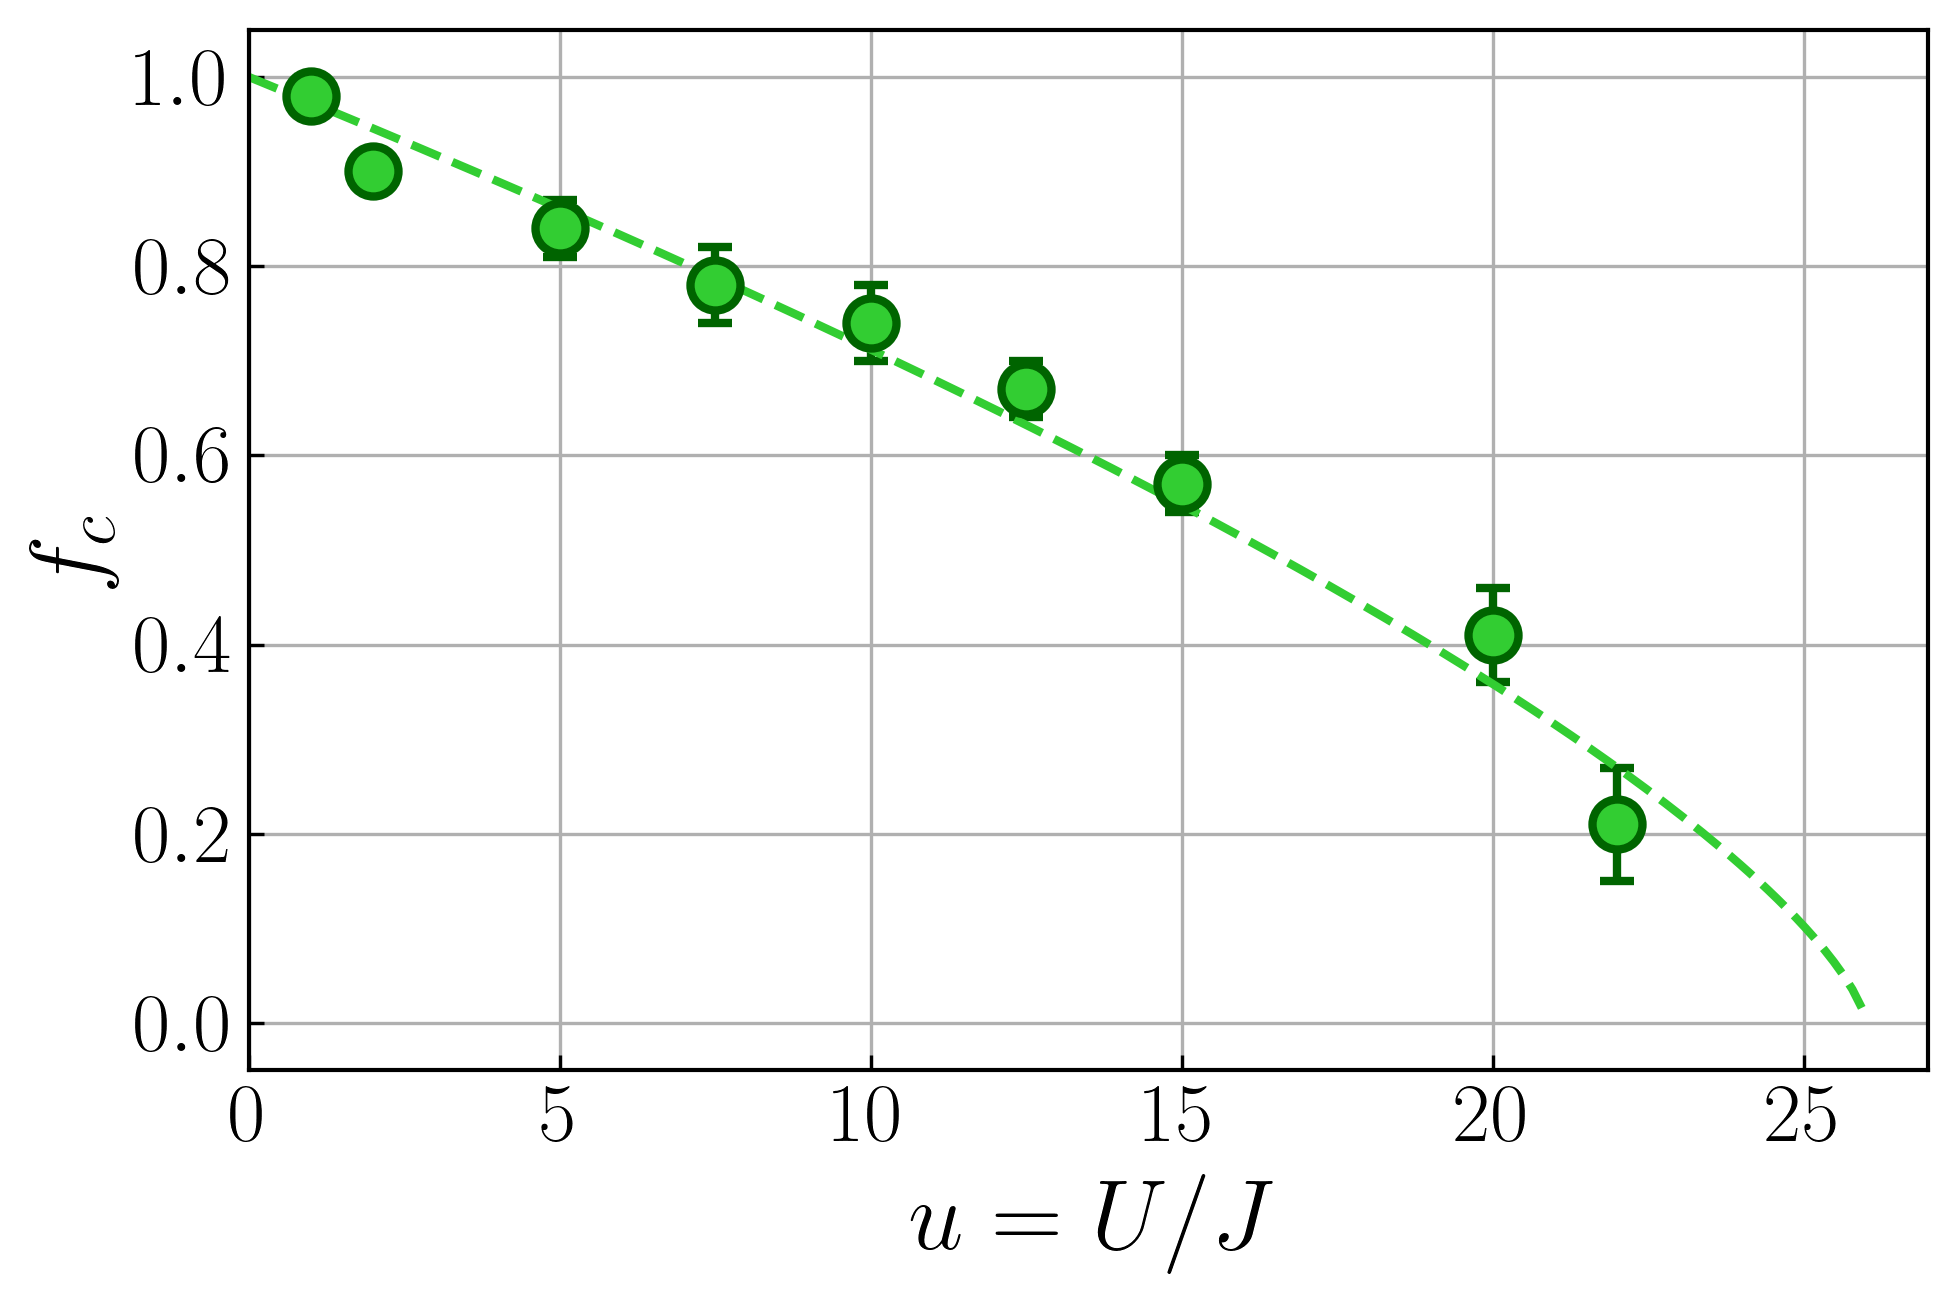

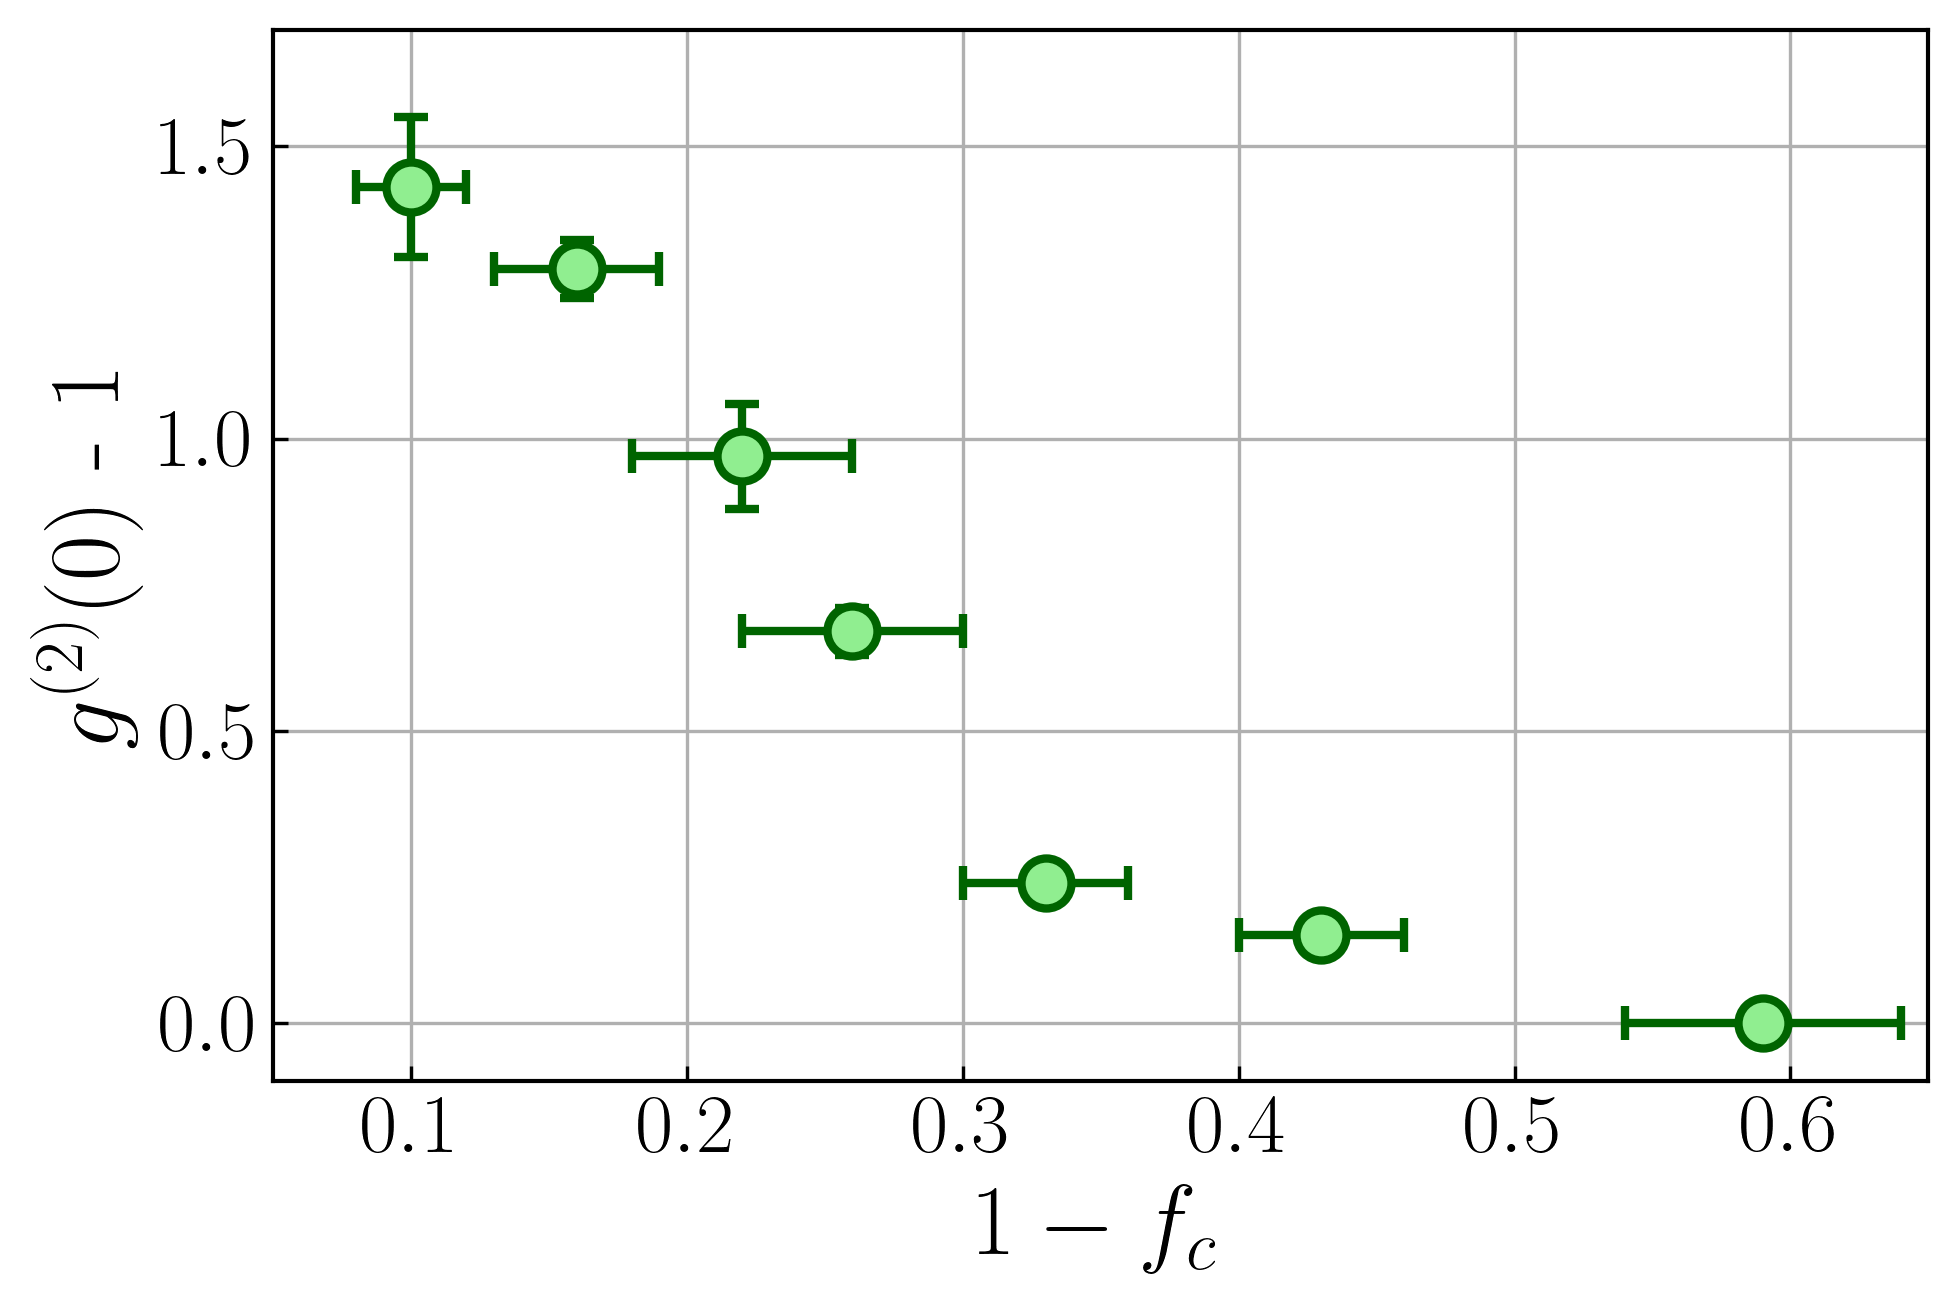

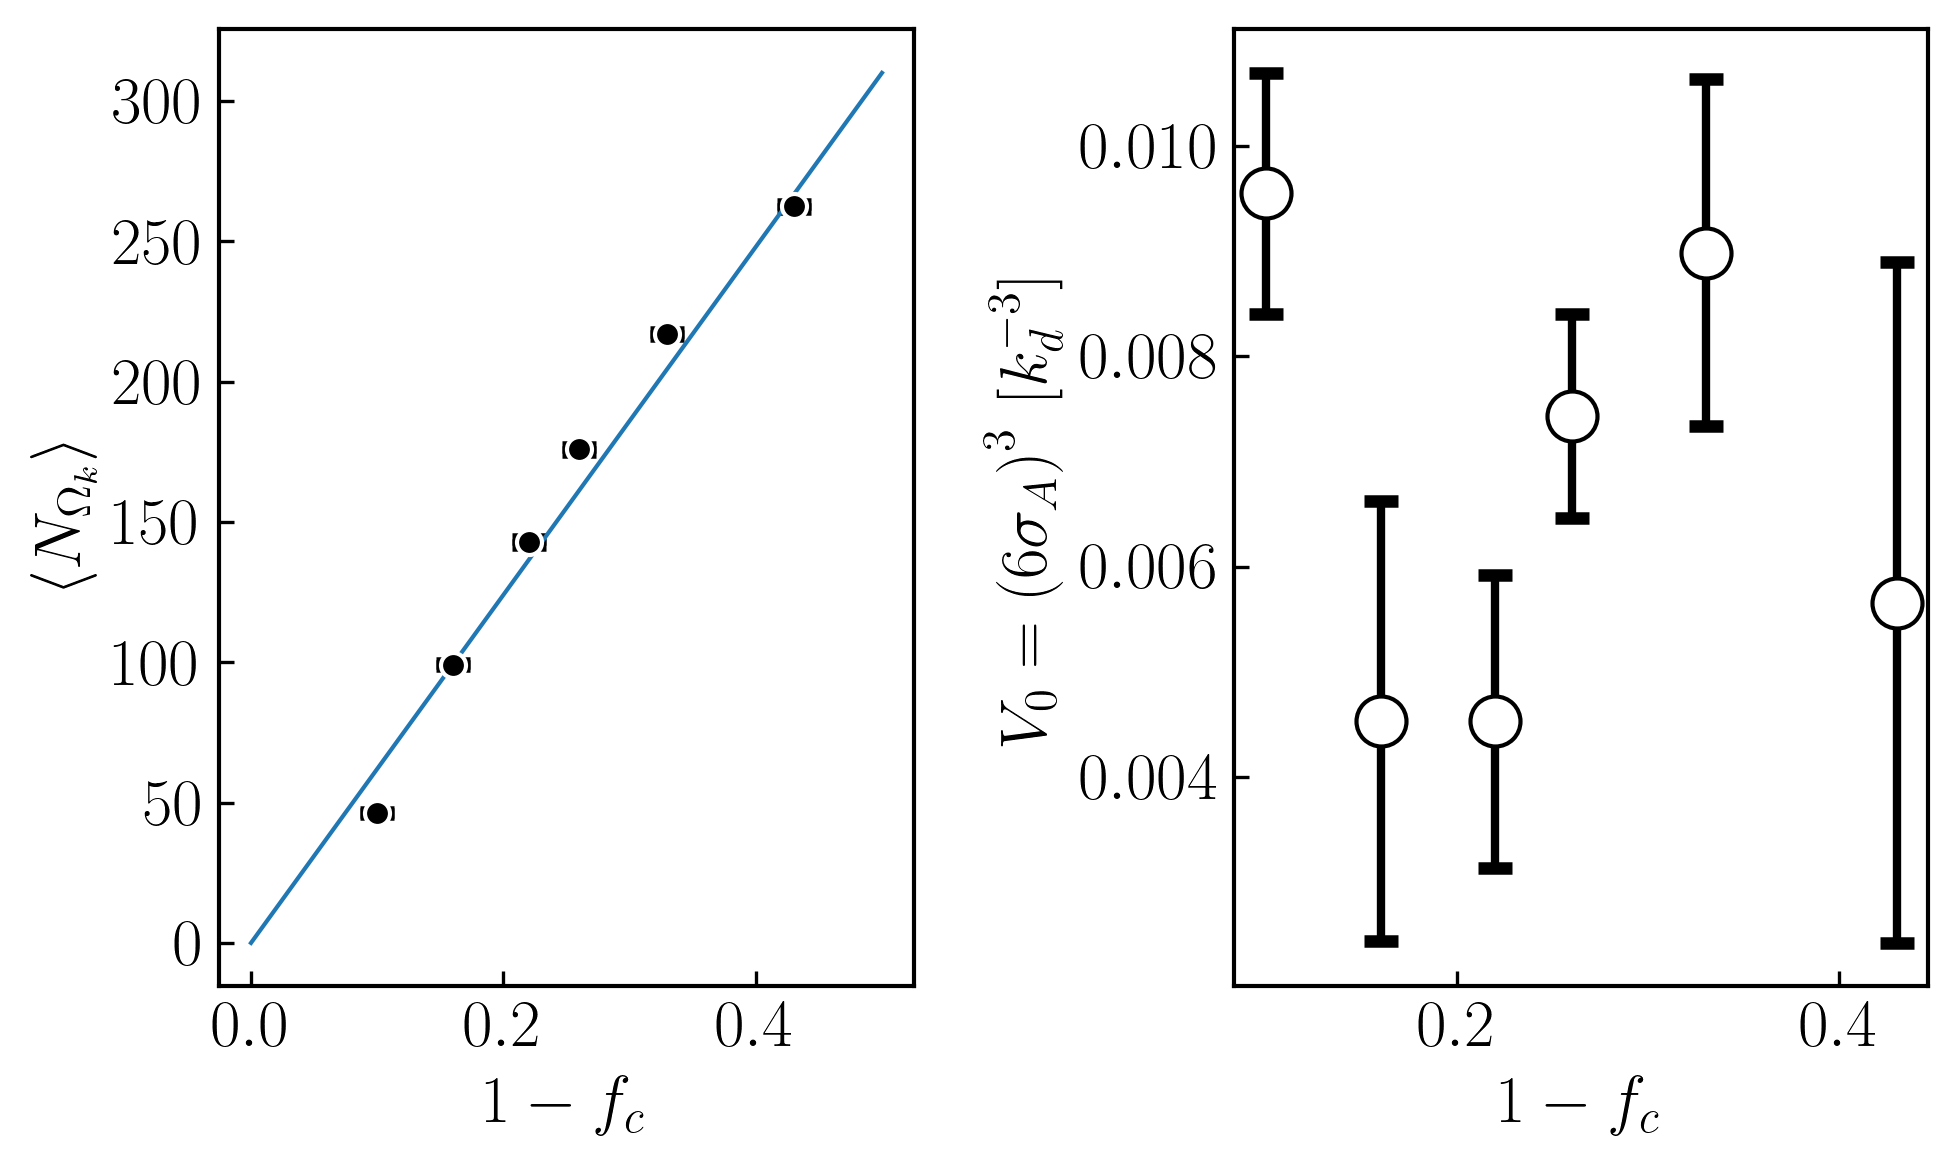

In [4]:
fig,ax=plt.subplots(1,1,figsize=[fig_width,fig_height])

plt.errorbar(U_J_fc[0:9],fc_corr[0:9],yerr=err_fc_corr[0:9],
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='limegreen',
        markeredgewidth=2.0,lw=2)

UsuJscale=np.linspace(0,30,200)
#plt.plot(U_J_fc[1:9],fc_corr[1:9], linestyle='dashed', color='limegreen',linewidth=2)
plt.plot(UsuJscale,(1-UsuJscale/26)**(0.7), linestyle='dashed', color='limegreen',linewidth=2)

plt.grid()
#ax.xaxis.set_ticks(np.arange(0, 0.7, 0.1))
#ax.yaxis.set_ticks(np.arange(0, 1.7, 0.5))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-0.05,1.05)
plt.xlim(0,27)

plt.xlabel('$u=U/J$', fontsize = 24)
plt.ylabel('$f_c$', fontsize = 24)

plt.tight_layout()

fig,ax=plt.subplots(1,1,figsize=[fig_width,fig_height])

plt.errorbar(1-fc_corr[1:8],amp_kmk_bare[1:8],yerr=err_amp_kmk_bare[1:8],xerr=err_fc_corr[1:8],
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='lightgreen',
        markeredgewidth=2.0,lw=2
            )

plt.grid()
ax.xaxis.set_ticks(np.arange(0, 0.7, 0.1))
ax.yaxis.set_ticks(np.arange(0, 1.7, 0.5))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-0.1,1.7)
plt.xlim(0.05,0.65)

plt.xlabel('$1 - f_c$', fontsize = 24)
plt.ylabel('$g^{(2)}(0)$ - 1', fontsize = 24)

plt.tight_layout()


fc_scale=np.linspace(0,0.5,1000)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=[fig_width,fig_height*0.9])

ax1.errorbar(1-fc_corr[1:7],N_Omega[0:6]/0.52,yerr=SEM_N_Omega/0.52,
             marker='.',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
             linestyle='none',
             color='black',
             markeredgecolor='white',
             markerfacecolor='black',
            )
ax1.plot(fc_scale,620*fc_scale)

ax2.errorbar(1-fc_corr[1:7],V0,yerr=err_V0,
             marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
             linestyle='none',
             color='black',
             markeredgecolor='black',
             markerfacecolor='white',
            )

ax1.set_xlabel('$1 - f_c$')#, fontsize =24)
ax1.set_ylabel(r"$\langle N_{\Omega_k} \rangle $")#,fontsize = 24)
ax2.set_xlabel('$1 - f_c$')#, fontsize = 24)
ax2.set_ylabel(r"$V_0 = \left( 6 \sigma_A \right) ^3 \, [k_d^{-3}]$")#,fontsize = 24)

plt.tight_layout()
plt.show()

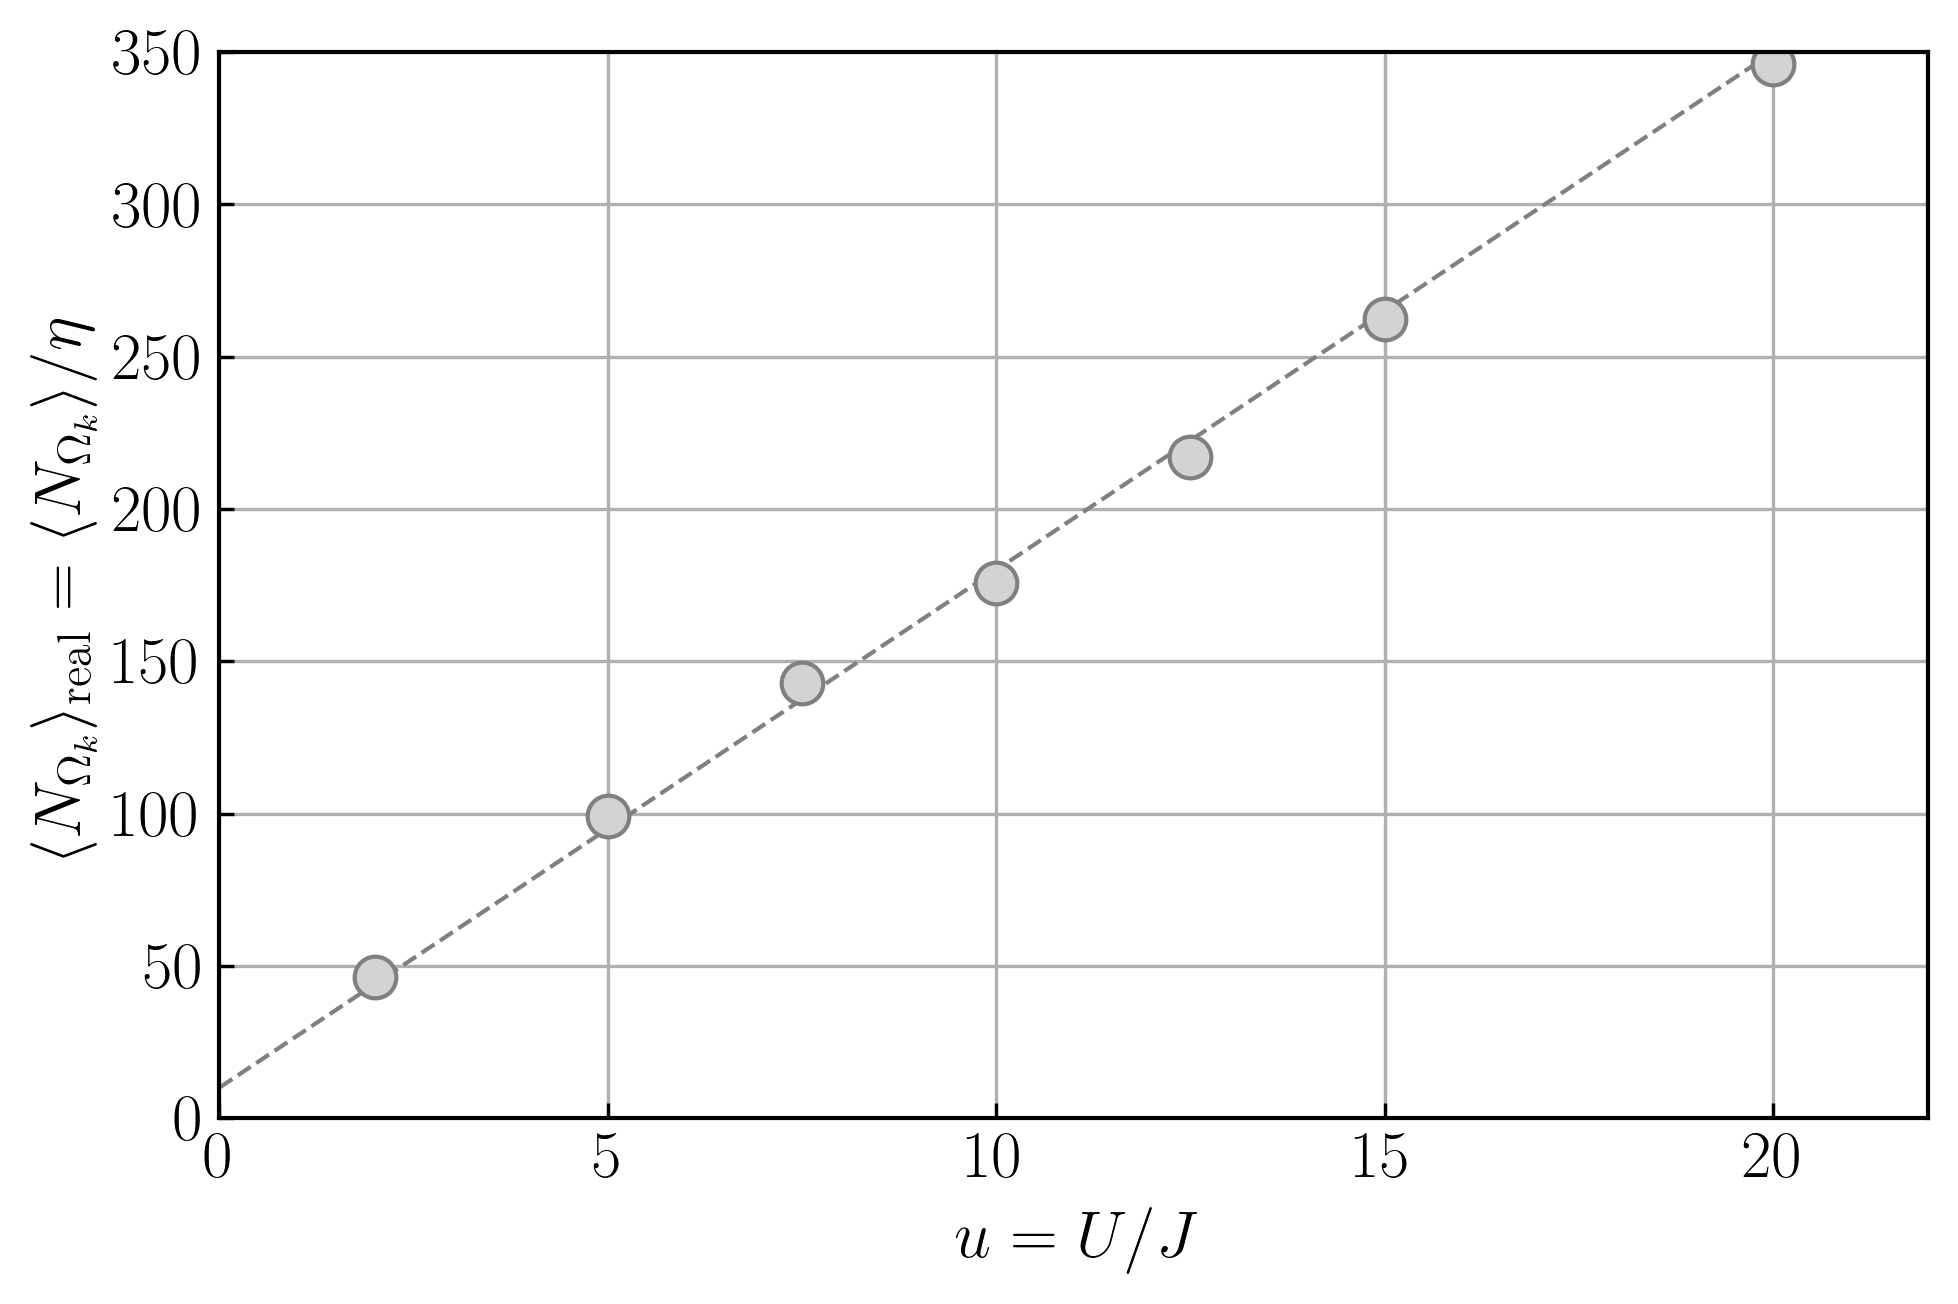

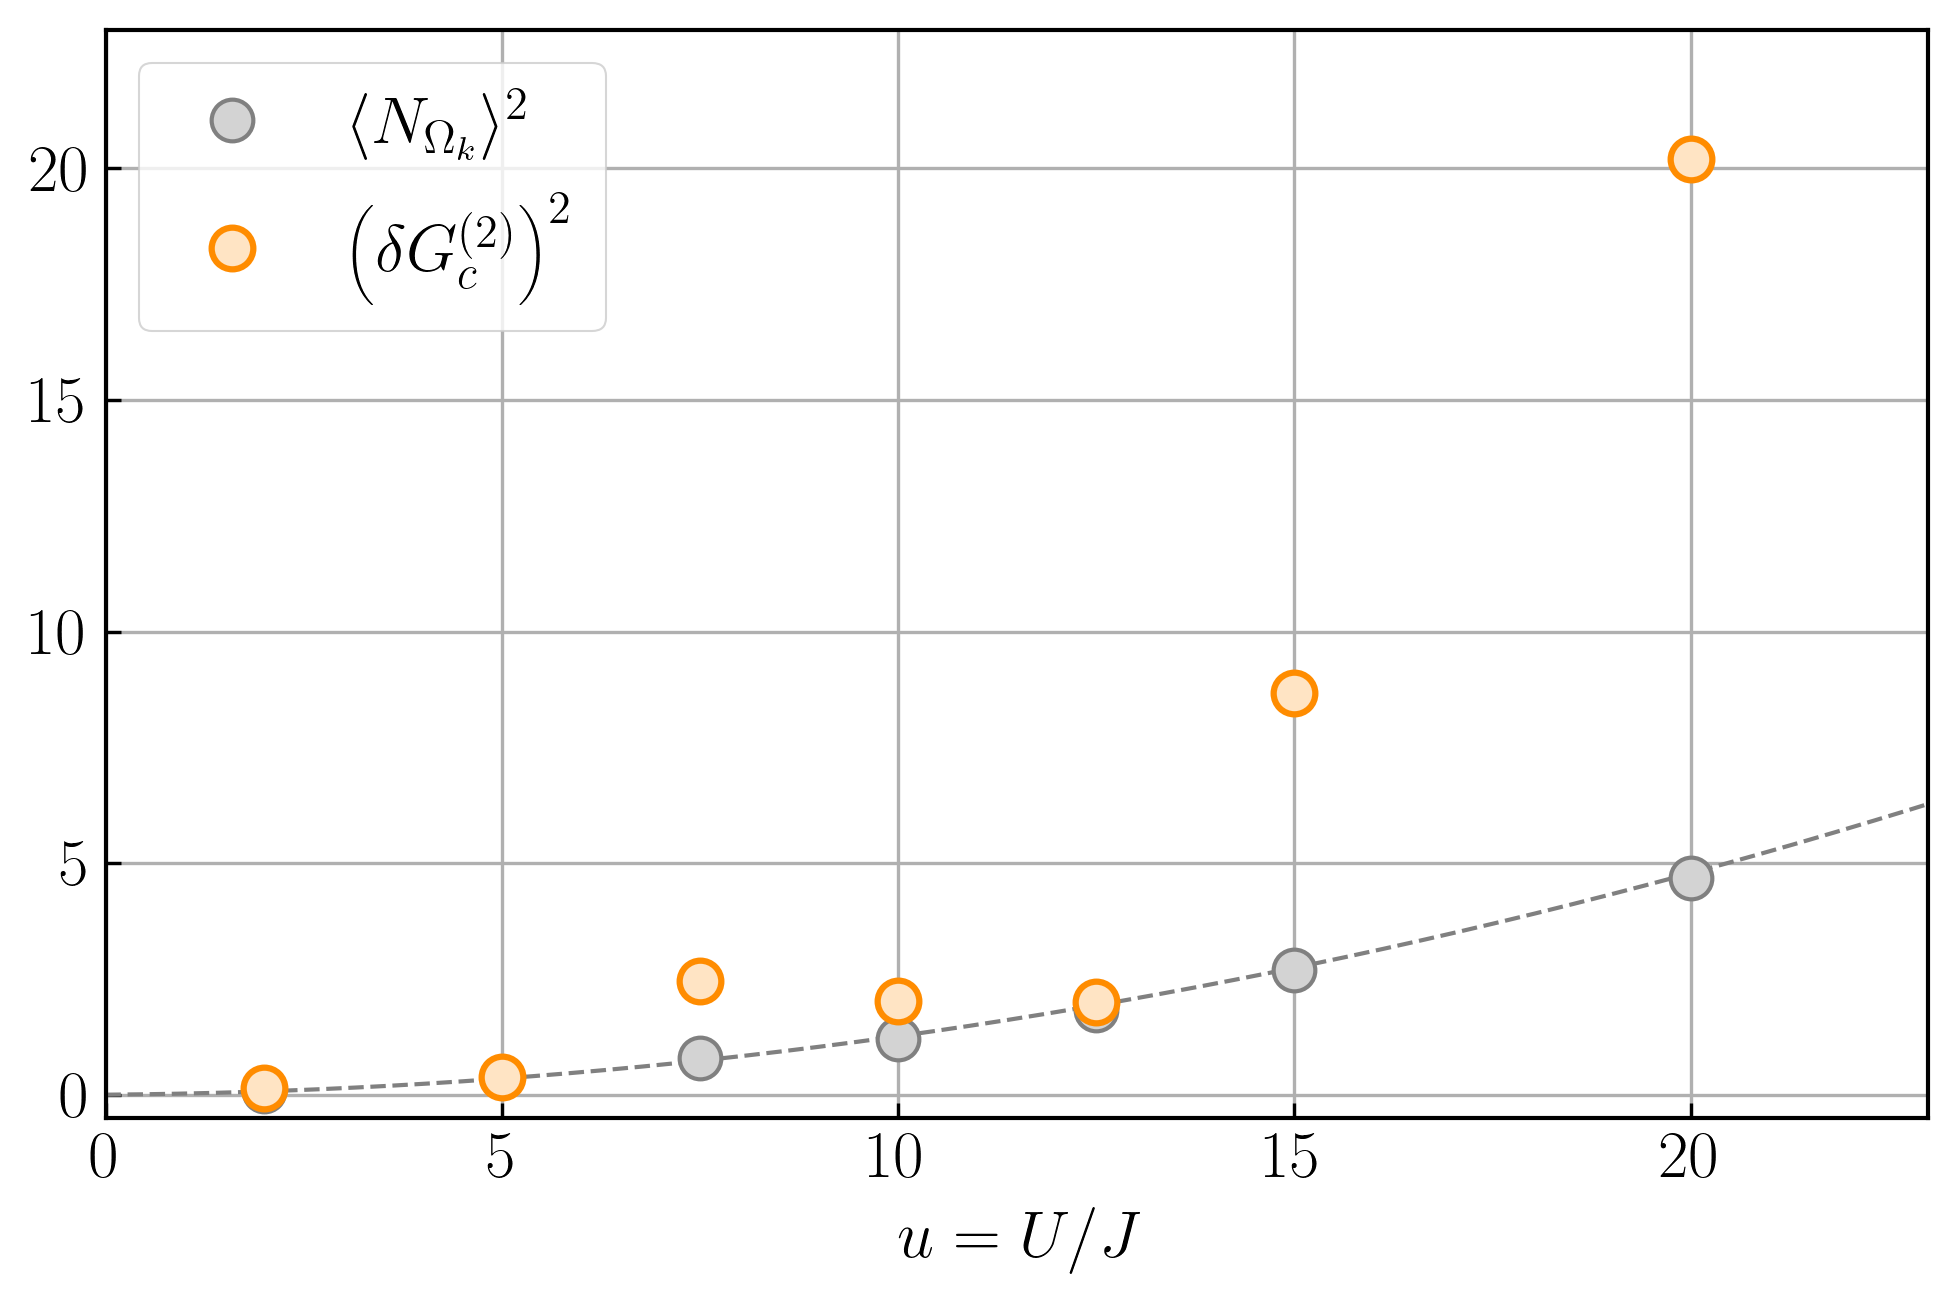

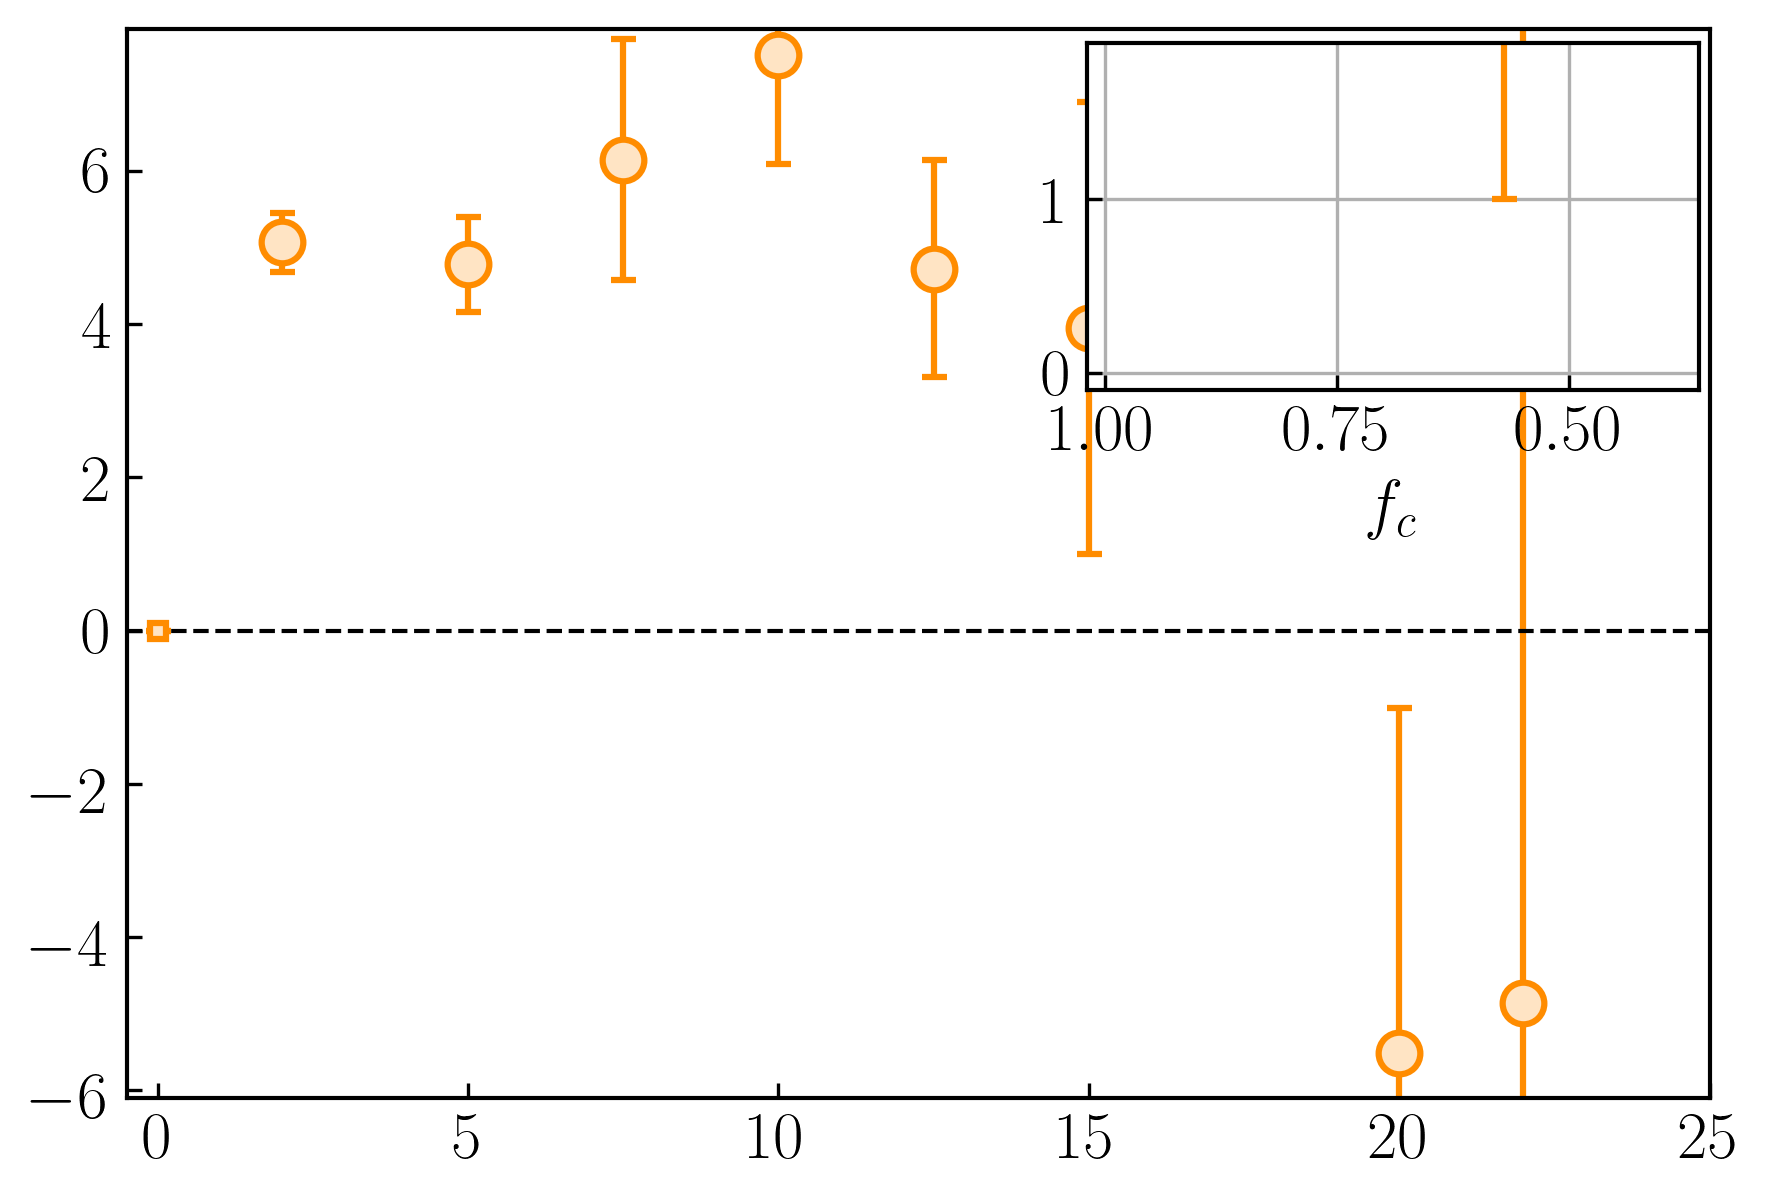

In [5]:
# Detection efficiency 
eta=0.52

u_scale=np.linspace(0,25,1000)

fig,ax=plt.subplots(figsize=[fig_width,fig_height])
plt.errorbar(U_J[1:8],N_Omega[0:7]/eta,#yerr=SEM_N_Omega,
             marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5,
             linestyle='none',
             color='grey',
             markeredgecolor='grey',
             markerfacecolor='lightgrey',
            )
plt.plot(u_scale,u_scale*17+10,linestyle='dashed',color='grey')
ax.set_ylabel(r"$\langle N_{\Omega_k} \rangle_{\rm real}=\langle N_{\Omega_k} \rangle / \eta $")#,fontsize = 24)
ax.set_xlabel('$u=U/J$')#, fontsize = 24)
plt.xlim(0,22)
plt.ylim(0,350)
plt.grid()

plt.tight_layout()
plt.savefig('Fig-mean-N_Omegak.pdf', dpi=300,bbox_inches='tight')
plt.show()


fig,ax=plt.subplots(figsize=[fig_width,fig_height])
plt.errorbar(U_J[1:8],(N_Omega/eta)**2/160**2,#yerr=SEM_N_Omega**2/350,
             label=r"$\langle N_{\Omega_k} \rangle^2$",
             marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5,
             linestyle='none',
             color='grey',
             markeredgecolor='grey',
             markerfacecolor='lightgrey',
            )
plt.plot(u_scale,(17*u_scale+10)**2/160**2,linestyle='dashed',color='grey')

plt.errorbar(U_J[1:9],err_G2c_0p18kd**2,label=r"$\left (\delta G^{(2)}_c \right)^2$",
             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
plt.legend()
ax.set_xlabel('$u=U/J$')#, fontsize = 24)
plt.xlim(0,23)
plt.ylim(-0.5,23)
plt.grid()
#plt.semilogy()

plt.tight_layout()
plt.savefig('Fig-mean-N_Omegak-dG2_c.pdf', dpi=300,bbox_inches='tight')
plt.show()





fig = plt.figure(figsize=[fig_width,fig_height])

#plt.errorbar(U_J[1:8],G2c_0p042kd/eta**2,yerr=err_G2c_0p042kd/eta**2,
plt.errorbar(U_J[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,
             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )

plt.errorbar([0],[0],yerr=0,
             marker='s',markersize=4,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )

plt.axhline(y=0, color='black', linestyle='--')
ax.set_ylabel(r"$G^{(2)}_{\rm pairing}$")#,fontsize = 24)
ax.set_xlabel('$u=U/J$')#, fontsize = 24)
#plt.grid()
plt.ylim(-6.1,7.85)
plt.xlim(-0.5,25)


# this is an inset axes over the main axes
ax1 = plt.axes([.595, .62, .3, .25])
ax1.set_xlabel('$f_c$')
#ax1.set_ylabel('$$')
plt.grid(True)
ax1.set_ylim(-0.1,1.9)
ax1.set_xlim(max(fc_corr[1:8])+0.12, min(fc_corr[1:8])-0.05)
ax1.errorbar(fc_corr[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,
             marker='o',markersize=8,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )

#G2interpol = np.interp(u_scale,U_J[1:8], 2*G2c_0p042kd/eta**2)
#plt.plot(u_scale,2*0.42*np.exp(-(u_scale-9.2)**2/5**2)/eta**2,linestyle='dashed',color='orange')
#plt.plot(u_scale,G2interpol,linestyle='dashed',color='orange')


#ax.set_ylabel(r"$G^{(2)}_{\rm pair}(0)=G^{(2)}_{\rm pair}(0)/\eta^2$")#,fontsize = 24)


plt.savefig('Fig-G2-opposite-k.pdf', dpi=300,bbox_inches='tight')
plt.show()



#G2c_norm=2*G2c_0p042kd/eta**2;
#errG2c_norm=2*G2c_0p042kd/eta**2;
#for j in range (8):
#    G2c_norm[j]=2*G2c_0p042kd[j]/eta**2/(U_J[j]*17+10);
#    errG2c_norm=2*err_G2c_0p042kd[j]/eta**2/(U_J[j]*17+10);
    
#fig,ax=plt.subplots(figsize=[fig_width,fig_height])
 
#plt.errorbar(U_J[1:9],G2c_norm,yerr=errG2c_norm,
#             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
#             linestyle='none',
#             color='darkorange',
#             markeredgecolor='darkorange',
#             markerfacecolor='bisque',
#            )



## Tommaso Data

In [6]:
currentfolder = '/Users/david/Documents/Physique/IOGS-Palaiseau/Papers/2023/BogoPairingIncreasingU/data-analysis/'
foldername = currentfolder + '/conti-Tommaso' 
#filelist= sorted(glob.glob(foldername+"/GA_shell_UUscan_*.dat"), key=str.lower)#key = natural_keys)#
filelist= sorted(glob.glob(foldername+"/G2A_shell_*.dat"), key=str.lower)#key = natural_keys)#

numfiles=len(filelist)
print('Number of Quantum Rotor files to be treated ',numfiles)

Number of Quantum Rotor files to be treated  4


In [7]:
Ttheo = []
Data_QR=[]

for k in range(len(filelist)):
#    temp = float(filelist[k][len(foldername)+18:len(foldername)+22])   
    temp = float(filelist[k][len(foldername)+12:len(foldername)+16])
    Ttheo.append(temp)

for i in range(numfiles):
    #print('Number of files treated ',i+1,' over ',numfiles)
    Data_QR.append(np.loadtxt(filelist[i]))

In [8]:
# list of U/2nJ obtained at Temp[j] from list of Data_QR[j][k,1]
indexT=1
print('temp',Ttheo[indexT])

indexT=0
U_2nJ_0p2 = Data_QR[indexT][:,1]
G2c_QR_0p2 = Data_QR[indexT][:,30] - Data_QR[indexT][:,32]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*Data_QR[indexT][:,1])/Data_QR[indexT][:,28])**2
G2c_QR_0p2*=norm_fact

indexT=1
U_2nJ_0p6 = Data_QR[indexT][:,1]
G2c_QR_0p6 = Data_QR[indexT][:,30] - Data_QR[indexT][:,32]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*Data_QR[indexT][:,1])/Data_QR[indexT][:,28])**2
G2c_QR_0p6*=norm_fact

indexT=2
U_2nJ_1p0 = Data_QR[indexT][:,1]
G2c_QR_1p0 = Data_QR[indexT][:,30] - Data_QR[indexT][:,32]
G2c_QR_1p0_notNorm = Data_QR[indexT][:,30] - Data_QR[indexT][:,32]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*Data_QR[indexT][:,1])/Data_QR[indexT][:,28])**2
G2c_QR_1p0*=norm_fact


indexT=3
U_2nJ_1p4 = Data_QR[indexT][:,1]
G2c_QR_1p4 = Data_QR[indexT][:,30] - Data_QR[indexT][:,32]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*Data_QR[indexT][:,1])/Data_QR[indexT][:,28])**2
G2c_QR_1p4*=norm_fact



temp 0.6


Text(0.5, 0, '$U/2nJ$')

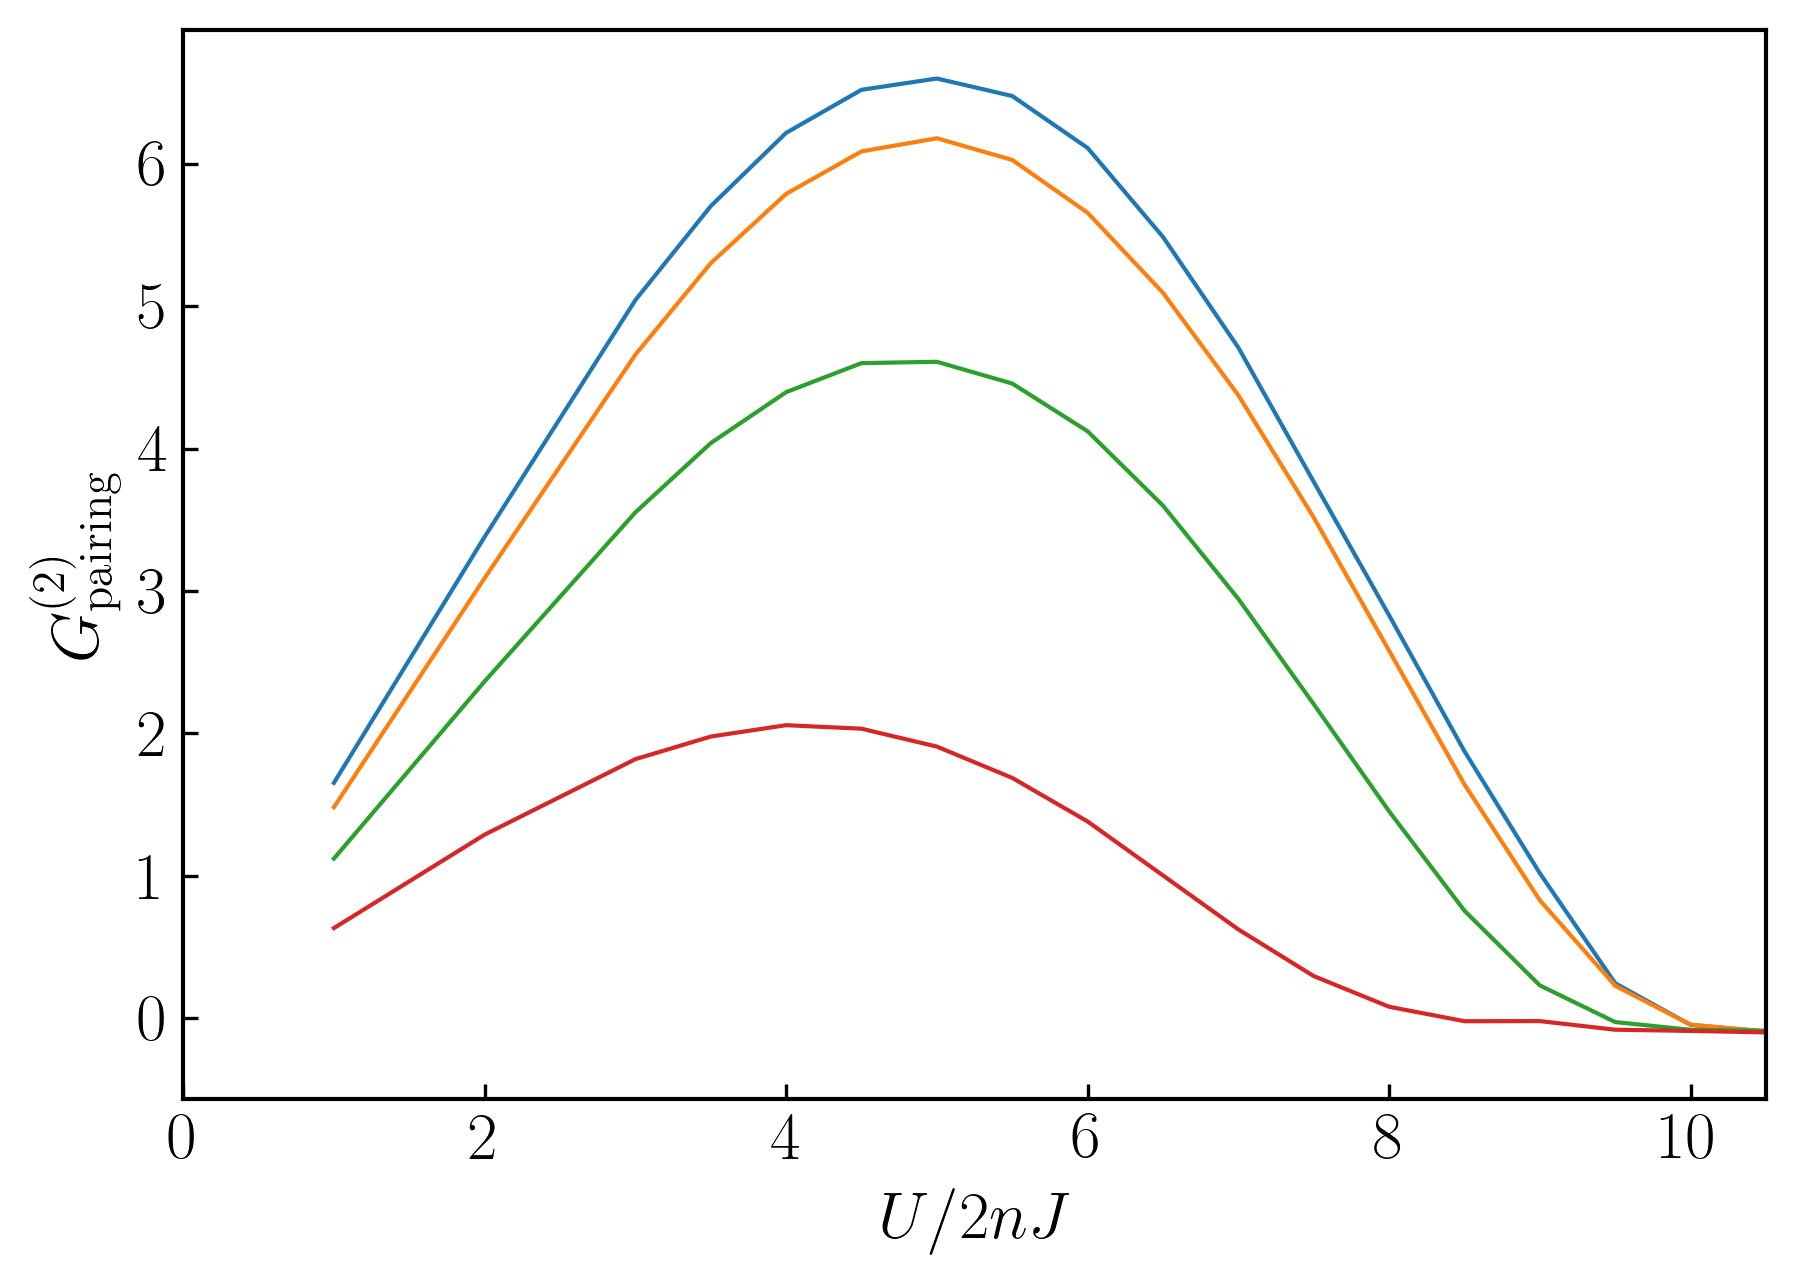

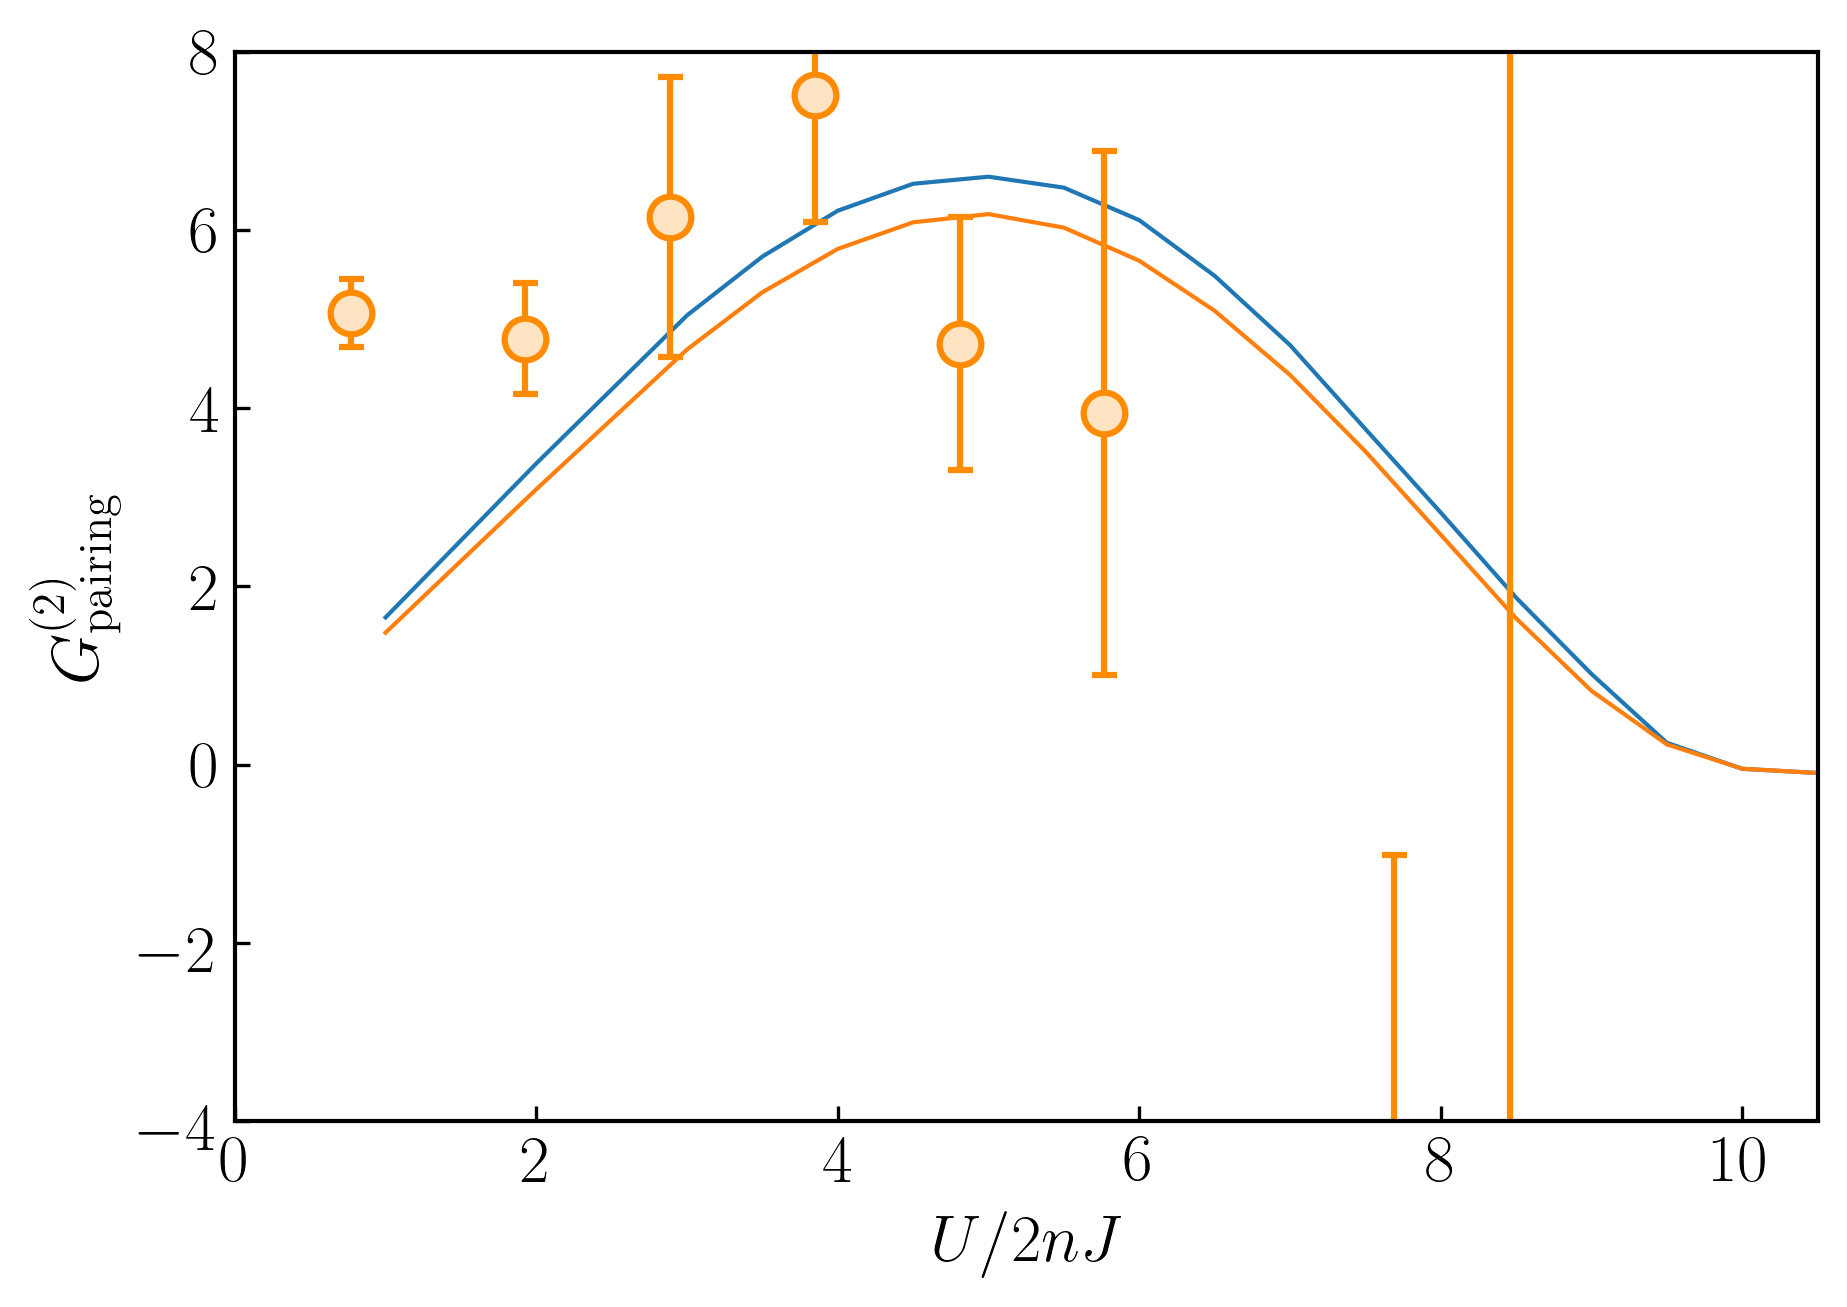

In [9]:
fig = plt.figure(figsize=[fig_width,fig_height])
plt.plot(U_2nJ_0p2,G2c_QR_0p2)
plt.plot(U_2nJ_0p2,G2c_QR_0p6)
plt.plot(U_2nJ_0p2,G2c_QR_1p0)
plt.plot(U_2nJ_0p2,G2c_QR_1p4)
#plt.plot(U_2nJ_0p2,G2c_QR_1p8)
plt.xlim(0.,10.5)
plt.ylabel(r"$G^{(2)}_{\rm pairing}$")#,fontsize = 24)
plt.xlabel('$U/2nJ$')

fig = plt.figure(figsize=[fig_width,fig_height])
plt.plot(U_2nJ_0p2,G2c_QR_0p2)
plt.plot(U_2nJ_0p2,G2c_QR_0p6)
plt.errorbar(U_J[1:9]/2.6,G2c_0p18kd,yerr=err_G2c_0p18kd,
             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
plt.xlim(0.,10.5)
plt.ylim(-4,8)
plt.ylabel(r"$G^{(2)}_{\rm pairing}$")#,fontsize = 24)
plt.xlabel('$U/2nJ$')

In [10]:
currentfolder = '/Users/david/Documents/Physique/IOGS-Palaiseau/Papers/2023/BogoPairingIncreasingU/data-analysis/'
foldername = currentfolder + '/conti-Tommaso' 
filelistBogo= sorted(glob.glob(foldername+"/eqdata_QBogoBHstandT*.dat"), key=str.lower)#key = natural_keys)#

numfilesBogo=len(filelistBogo)
print('Number of Bogoliubov files to be treated ',numfilesBogo)

Number of Bogoliubov files to be treated  2


In [11]:
Ttheo_Bogo = []
Data_Bogo=[]

for k in range(len(filelistBogo)):
    temp = float(filelistBogo[k][len(foldername)+21:len(foldername)+24])
    Ttheo_Bogo.append(temp)

for i in range(numfilesBogo):
    #print('Number of files treated ',i+1,' over ',numfiles)
    Data_Bogo.append(np.loadtxt(filelistBogo[i]))

In [12]:
indexT=0
U_J_Bogo_1p0 = Data_Bogo[indexT][:,0]
G2c_Bogo_1p0 = Data_Bogo[indexT][:,20] 

indexT=1
U_J_Bogo_2p0 = Data_Bogo[indexT][:,0]
G2c_Bogo_2p0 = Data_Bogo[indexT][:,20] 

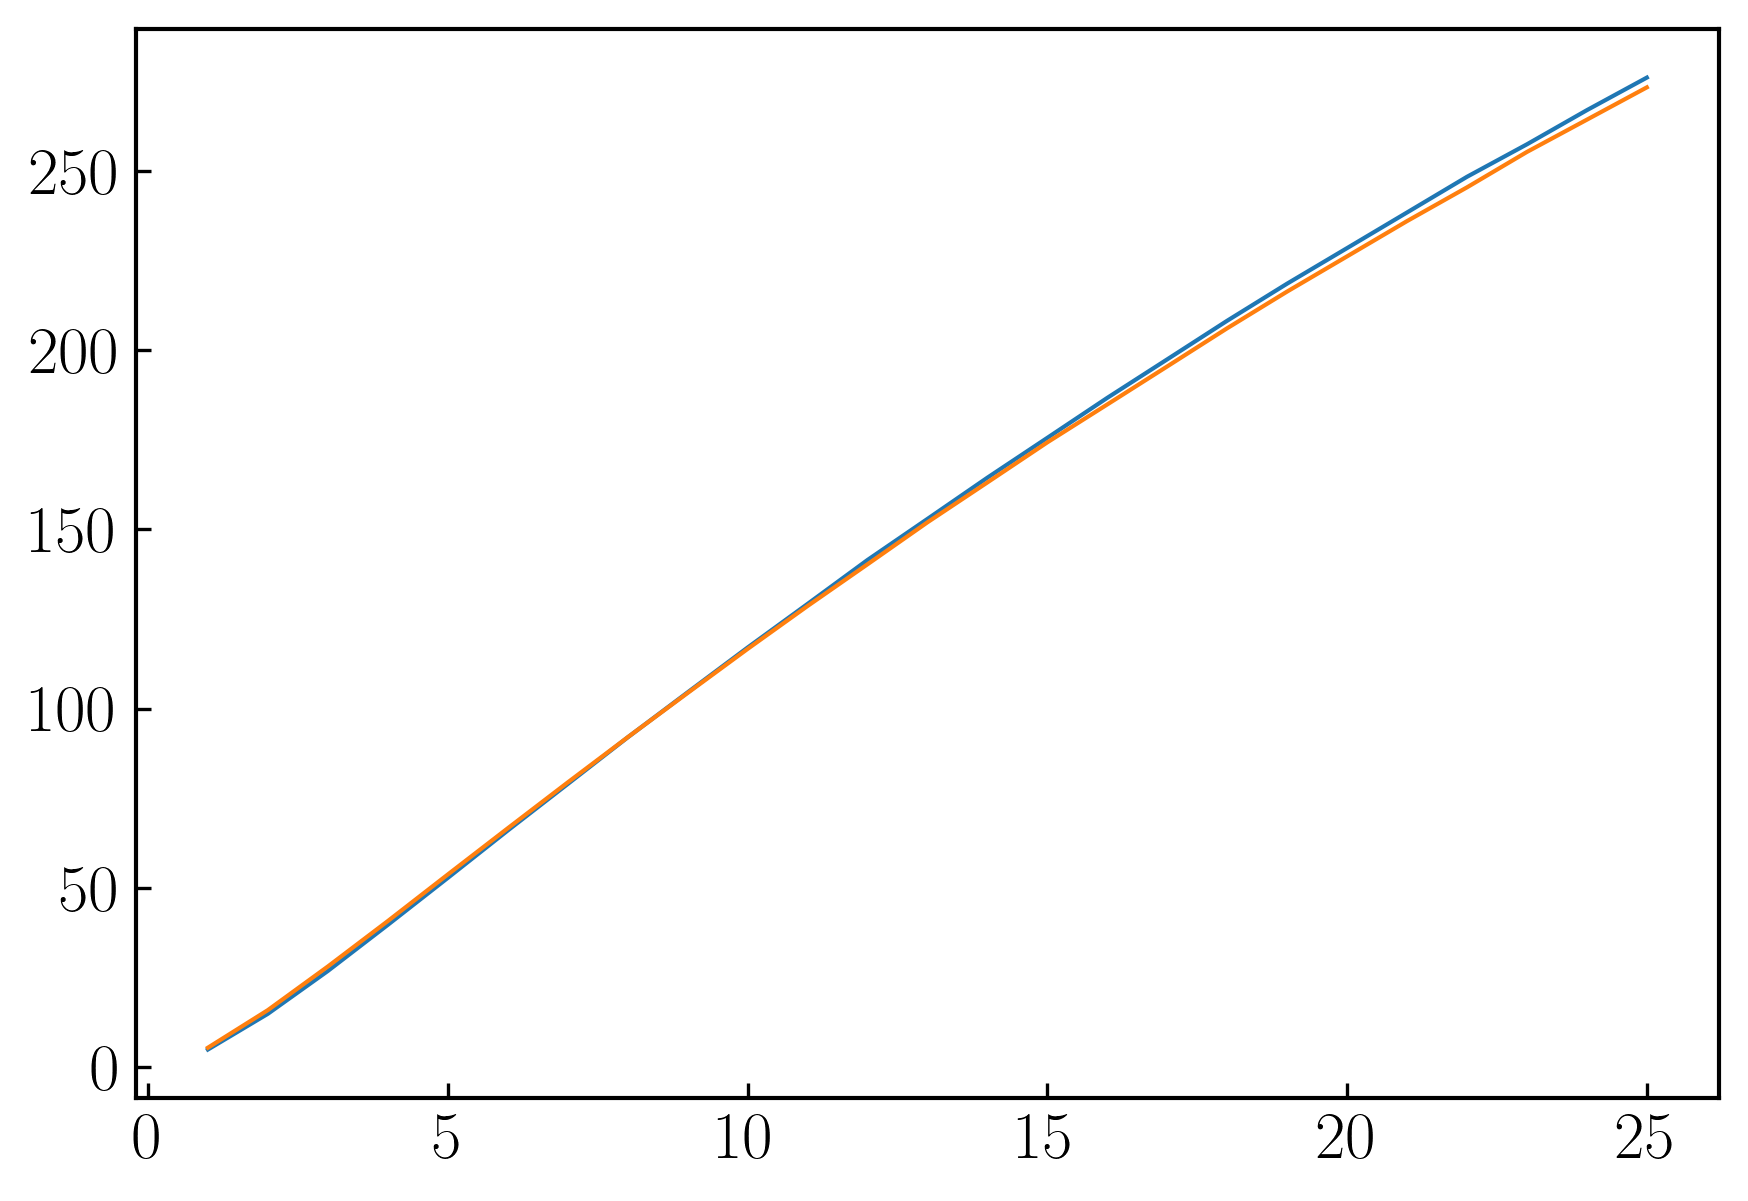

In [13]:
fig = plt.figure(figsize=[fig_width,fig_height])
plt.plot(U_J_Bogo_1p0,G2c_Bogo_1p0)
plt.plot(U_J_Bogo_1p0,G2c_Bogo_2p0)

In [14]:
currentfolder = '/Users/david/Documents/Physique/IOGS-Palaiseau/Papers/2023/BogoPairingIncreasingU/data-analysis/'
foldername = currentfolder + '/conti-Tommaso' 
#filelist= sorted(glob.glob(foldername+"/GA_shell_UUscan_*.dat"), key=str.lower)#key = natural_keys)#
filelist= sorted(glob.glob(foldername+"/G3scan_s3_T*.dat"), key=str.lower)#key = natural_keys)#

numfiles=len(filelist)
print('Number of Quantum Rotor files to be treated ',numfiles)

Ttheo = []
DataG3_QR=[]

for k in range(len(filelist)):
#    temp = float(filelist[k][len(foldername)+18:len(foldername)+22])   
    temp = float(filelist[k][len(foldername)+12:len(foldername)+15])
    Ttheo.append(temp)

for i in range(numfiles):
    #print('Number of files treated ',i+1,' over ',numfiles)
    DataG3_QR.append(np.loadtxt(filelist[i]))
    

Number of Quantum Rotor files to be treated  4


In [15]:
#### DA RIPRENDERE PER FAR IL LOADING DEI DATI CORRETTAMENTE
#U_2nJ_G3 = DataG3_QR[0][:,1]
#G3c_QR_0p2 = DataG3_QR[0][:,7]# - DataG3_QR[0][:,32]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
#norm_fact=((17.3299+32.2131*DataG3_QR[0][:,1])/DataG3_QR[0][:,3])**3
#G3c_QR_0p2*=norm_fact

U_2nJ_G3 = DataG3_QR[0][:,1]

indexT=0
G3c_QR_0p2 = DataG3_QR[indexT][:,7]
errG3c_QR_0p2 = DataG3_QR[indexT][:,6]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*DataG3_QR[indexT][:,1])/DataG3_QR[indexT][:,3])**3
#print(norm_fact)
G3c_QR_0p2*=norm_fact
errG3c_QR_0p2*=norm_fact

indexT=1
G3c_QR_0p6 = DataG3_QR[indexT][:,7]
errG3c_QR_0p6 = DataG3_QR[indexT][:,6]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*DataG3_QR[indexT][:,1])/DataG3_QR[indexT][:,3])**3
#print(norm_fact)
G3c_QR_0p6*=norm_fact
errG3c_QR_0p6*=norm_fact

indexT=2
G3c_QR_1p0 = DataG3_QR[indexT][:,7]
errG3c_QR_1p0 = DataG3_QR[indexT][:,6]
G3c_QR_1p0_nonNorm = DataG3_QR[indexT][:,7]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*DataG3_QR[indexT][:,1])/DataG3_QR[indexT][:,3])**3
#print(norm_fact)
G3c_QR_1p0*=norm_fact
errG3c_QR_1p0*=norm_fact

indexT=3
G3c_QR_1p4 = DataG3_QR[indexT][:,7]
errG3c_QR_1p4 = DataG3_QR[indexT][:,6]
# fitting dati sperimentali N_{Omega_k} = a + b*(U/2J) = f(U/2J) con a = 17.3299 ; b = 32.2131
norm_fact=((17.3299+32.2131*DataG3_QR[indexT][:,1])/DataG3_QR[indexT][:,3])**3
#print(norm_fact)
G3c_QR_1p4*=norm_fact
errG3c_QR_1p4*=norm_fact

In [16]:
currentfolder = '/Users/david/Documents/Physique/IOGS-Palaiseau/Papers/2023/BogoPairingIncreasingU/data-analysis/'
foldername = currentfolder + '/conti-Tommaso' 
#filelist= sorted(glob.glob(foldername+"/GA_shell_UUscan_*.dat"), key=str.lower)#key = natural_keys)#
filelist= sorted(glob.glob(foldername+"/G3scan_s2_T*.dat"), key=str.lower)#key = natural_keys)#
numfiles=len(filelist)

DataG3_QR_size6=[]

for i in range(numfiles):
    #print('Number of files treated ',i+1,' over ',numfiles)
    DataG3_QR_size6.append(np.loadtxt(filelist[i]))
    
G3c_QR_1p0_size6 = DataG3_QR_size6[0][:,7]
errG3c_QR_1p0_size6 = DataG3_QR_size6[0][:,6]

Text(0.5, 0, '$U/2nJ$')

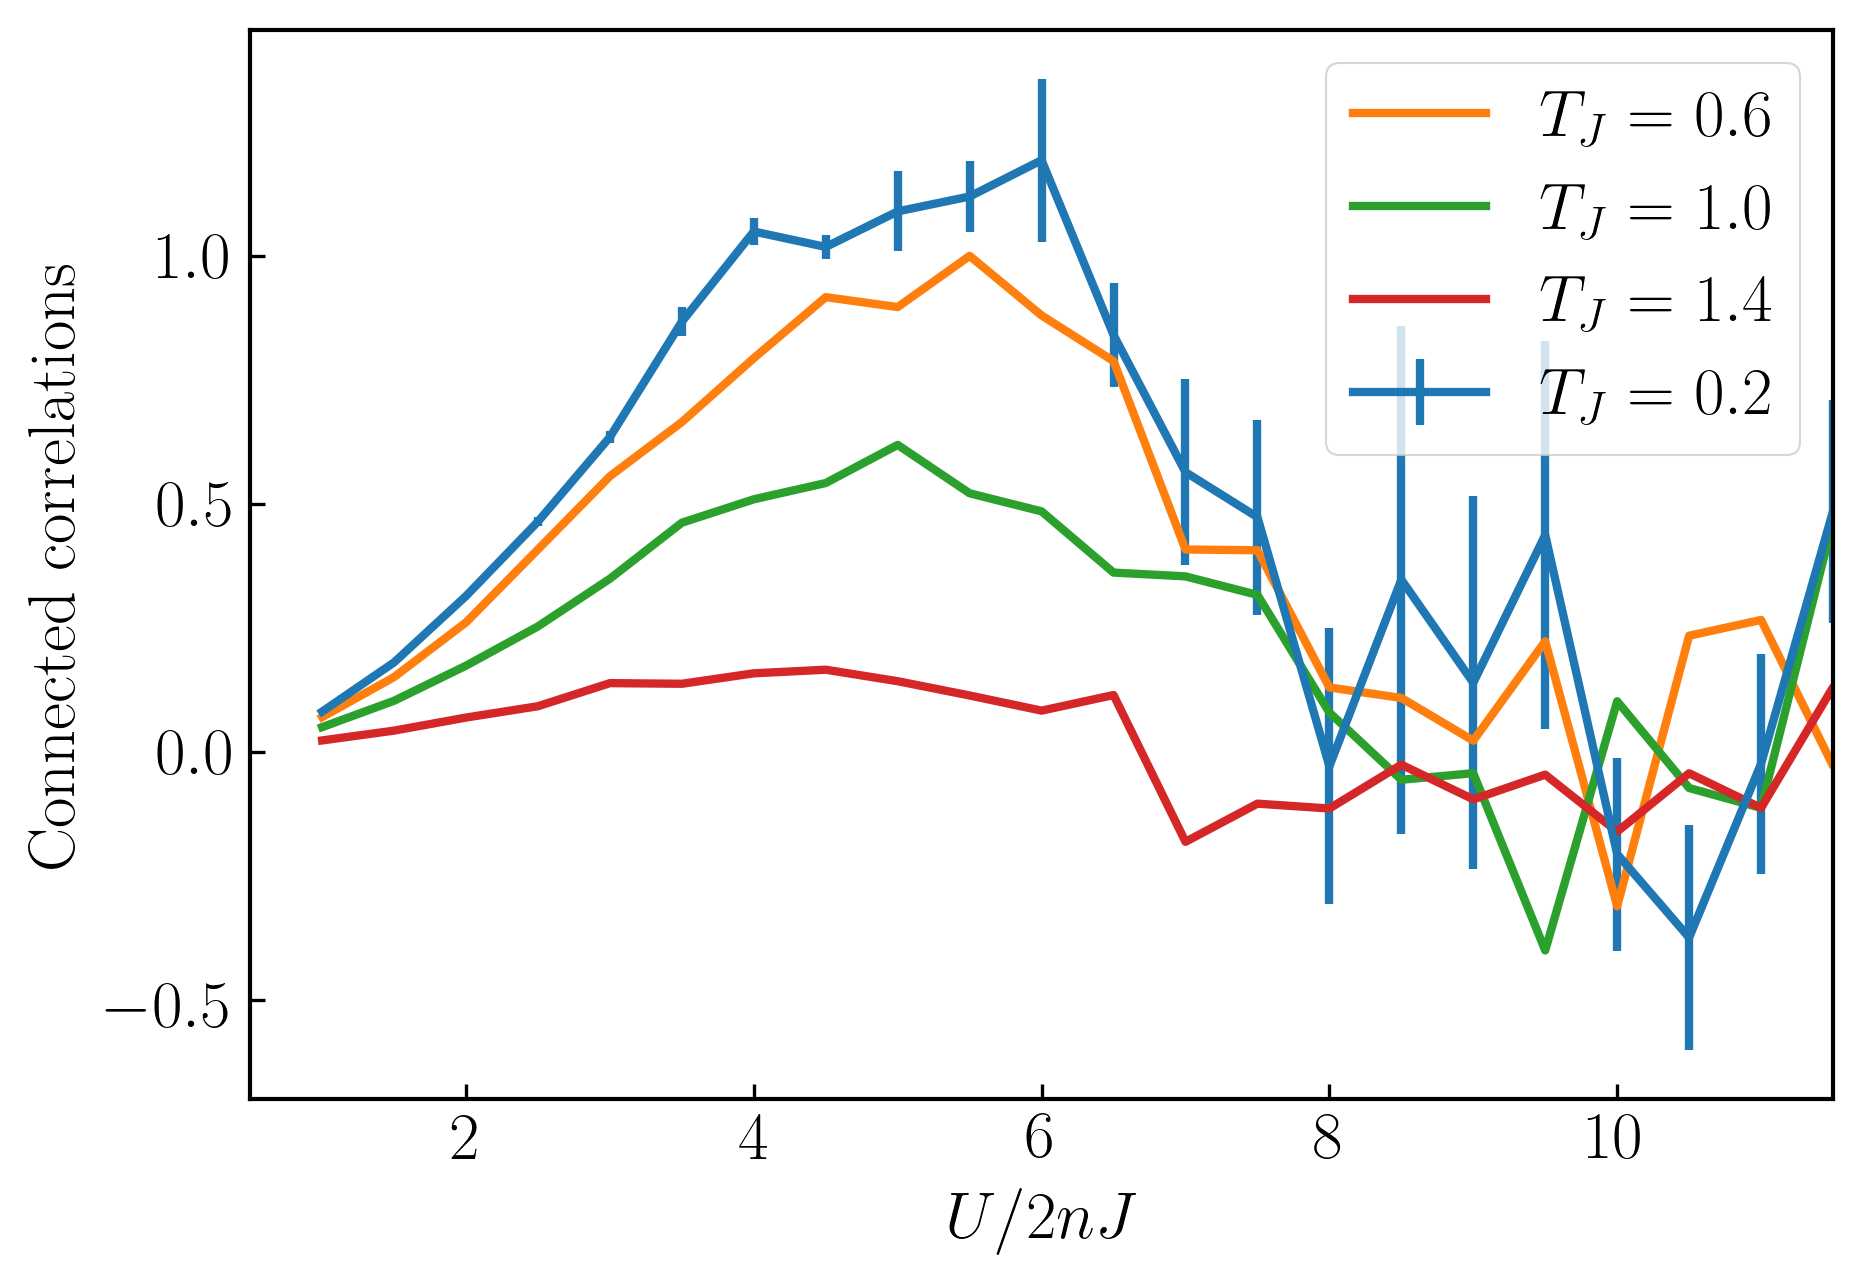

In [17]:
fig = plt.figure(figsize=[fig_width,fig_height])
#plt.plot(U_2nJ_0p2,G2c_QR_1p0,label=r"$G^{(2)}_c(0)$",linewidth=2)
plt.errorbar(U_2nJ_G3,G3c_QR_0p2,yerr=errG3c_QR_0p2,label=r"$T_J=0.2$",linewidth=2)
plt.plot(U_2nJ_G3,G3c_QR_0p6,label=r"$T_J=0.6$",linewidth=2)
plt.plot(U_2nJ_G3,G3c_QR_1p0,label=r"$T_J=1.0$",linewidth=2)
plt.plot(U_2nJ_G3,G3c_QR_1p4,label=r"$T_J=1.4$",linewidth=2)
plt.legend()
plt.xlim(0.5,11.5)
#plt.ylim(-0.1,.5)
#plt.semilogy()
plt.ylabel(r"Connected correlations")#,fontsize = 24)
plt.xlabel('$U/2nJ$')
#plt.axvline(x=5,linestyle='--')
#plt.axvline(x=6.,linestyle='--',color='orange')

In [18]:
# Density cuts with 0.1k_d of transverse integration

bin_centers = np.array([-1.15      , -1.13991228, -1.12982456, -1.11973684, -1.10964912,
       -1.0995614 , -1.08947368, -1.07938596, -1.06929825, -1.05921053,
       -1.04912281, -1.03903509, -1.02894737, -1.01885965, -1.00877193,
       -0.99868421, -0.98859649, -0.97850877, -0.96842105, -0.95833333,
       -0.94824561, -0.93815789, -0.92807018, -0.91798246, -0.90789474,
       -0.89780702, -0.8877193 , -0.87763158, -0.86754386, -0.85745614,
       -0.84736842, -0.8372807 , -0.82719298, -0.81710526, -0.80701754,
       -0.79692982, -0.78684211, -0.77675439, -0.76666667, -0.75657895,
       -0.74649123, -0.73640351, -0.72631579, -0.71622807, -0.70614035,
       -0.69605263, -0.68596491, -0.67587719, -0.66578947, -0.65570175,
       -0.64561404, -0.63552632, -0.6254386 , -0.61535088, -0.60526316,
       -0.59517544, -0.58508772, -0.575     , -0.56491228, -0.55482456,
       -0.54473684, -0.53464912, -0.5245614 , -0.51447368, -0.50438596,
       -0.49429825, -0.48421053, -0.47412281, -0.46403509, -0.45394737,
       -0.44385965, -0.43377193, -0.42368421, -0.41359649, -0.40350877,
       -0.39342105, -0.38333333, -0.37324561, -0.36315789, -0.35307018,
       -0.34298246, -0.33289474, -0.32280702, -0.3127193 , -0.30263158,
       -0.29254386, -0.28245614, -0.27236842, -0.2622807 , -0.25219298,
       -0.24210526, -0.23201754, -0.22192982, -0.21184211, -0.20175439,
       -0.19166667, -0.18157895, -0.17149123, -0.16140351, -0.15131579,
       -0.14122807, -0.13114035, -0.12105263, -0.11096491, -0.10087719,
       -0.09078947, -0.08070175, -0.07061404, -0.06052632, -0.0504386 ,
       -0.04035088, -0.03026316, -0.02017544, -0.01008772, 0.        ,
        0.01008772,  0.02017544,  0.03026316,  0.04035088, 0.0504386 ,
        0.06052632,  0.07061404,  0.08070175,  0.09078947, 0.10087719,
        0.11096491,  0.12105263,  0.13114035,  0.14122807, 0.15131579,
        0.16140351,  0.17149123,  0.18157895,  0.19166667, 0.20175439,
        0.21184211,  0.22192982,  0.23201754,  0.24210526, 0.25219298,
        0.2622807 ,  0.27236842,  0.28245614,  0.29254386, 0.30263158,
        0.3127193 ,  0.32280702,  0.33289474,  0.34298246, 0.35307018,
        0.36315789,  0.37324561,  0.38333333,  0.39342105, 0.40350877,
        0.41359649,  0.42368421,  0.43377193,  0.44385965, 0.45394737,
        0.46403509,  0.47412281,  0.48421053,  0.49429825, 0.50438596,
        0.51447368,  0.5245614 ,  0.53464912,  0.54473684, 0.55482456,
        0.56491228,  0.575     ,  0.58508772,  0.59517544, 0.60526316,
        0.61535088,  0.6254386 ,  0.63552632,  0.64561404, 0.65570175,
        0.66578947,  0.67587719,  0.68596491,  0.69605263, 0.70614035,
        0.71622807,  0.72631579,  0.73640351,  0.74649123, 0.75657895,
        0.76666667,  0.77675439,  0.78684211,  0.79692982, 0.80701754,
        0.81710526,  0.82719298,  0.8372807 ,  0.84736842, 0.85745614,
        0.86754386,  0.87763158,  0.8877193 ,  0.89780702, 0.90789474,
        0.91798246,  0.92807018,  0.93815789,  0.94824561, 0.95833333,
        0.96842105,  0.97850877,  0.98859649,  0.99868421, 1.00877193,
        1.01885965,  1.02894737,  1.03903509,  1.04912281, 1.05921053,
        1.06929825,  1.07938596,  1.08947368,  1.0995614 , 1.10964912,
        1.11973684,  1.12982456,  1.13991228,  1.15      ])


rho_k_2p0 = np.array([3.48289048e-04, 4.29507556e-04, 4.52682617e-04, 7.15584253e-04,
        1.17093089e-03, 1.59694877e-03, 2.48475984e-03, 4.58665509e-03,
        8.40267998e-03, 1.55089633e-02, 3.07793553e-02, 5.87315471e-02,
        9.86981836e-02, 1.42684441e-01, 1.66872358e-01, 1.56721675e-01,
        1.15951427e-01, 7.19177981e-02, 4.25404911e-02, 2.63663982e-02,
        1.63075592e-02, 1.07075460e-02, 7.07947598e-03, 4.75183739e-03,
        3.30874787e-03, 2.52213355e-03, 1.80476383e-03, 1.44352879e-03,
        1.23716572e-03, 9.41099906e-04, 8.88250341e-04, 6.74029367e-04,
        6.02413598e-04, 5.58967450e-04, 4.45650370e-04, 3.85089328e-04,
        3.70784880e-04, 3.44213672e-04, 2.76087578e-04, 2.40352906e-04,
        2.44135432e-04, 2.13102469e-04, 1.81150323e-04, 1.51329393e-04,
        1.49051751e-04, 1.68590712e-04, 2.08933564e-04, 1.24758185e-04,
        1.30431973e-04, 1.21268510e-04, 1.53220656e-04, 1.67671529e-04,
        1.72666089e-04, 1.83188011e-04, 1.48518947e-04, 1.63209774e-04,
        1.81296748e-04, 1.33148891e-04, 1.20735706e-04, 1.47306914e-04,
        1.56616803e-04, 2.51460530e-04, 1.77127844e-04, 2.03019822e-04,
        2.18536304e-04, 2.17324270e-04, 1.50556636e-04, 2.11117678e-04,
        2.07481577e-04, 2.01807789e-04, 1.84400044e-04, 1.80763944e-04,
        1.51089440e-04, 2.14900204e-04, 1.95454771e-04, 2.19069108e-04,
        2.12862515e-04, 2.30270260e-04, 2.47385154e-04, 2.37009656e-04,
        3.08771851e-04, 3.01499650e-04, 3.24967562e-04, 4.50018597e-04,
        4.80079480e-04, 4.90215024e-04, 6.04064908e-04, 6.92315664e-04,
        9.25009990e-04, 9.40380046e-04, 1.18897723e-03, 1.25172239e-03,
        1.56253193e-03, 1.87145020e-03, 1.99068103e-03, 2.64910038e-03,
        2.78627175e-03, 3.20714865e-03, 4.02387675e-03, 4.79346970e-03,
        5.83304944e-03, 7.10332644e-03, 9.11507968e-03, 1.25735463e-02,
        1.75388480e-02, 2.66001949e-02, 4.32242980e-02, 7.32195305e-02,
        1.26009761e-01, 2.21905216e-01, 3.79249945e-01, 5.86040835e-01,
        7.97374835e-01, 9.48319611e-01, 9.82989517e-01, 9.00176267e-01,
        7.37946484e-01, 5.45280779e-01, 3.68845525e-01, 2.34829682e-01,
        1.48199213e-01, 9.42805400e-02, 5.84272255e-02, 3.70112151e-02,
        2.38599766e-02, 1.61733286e-02, 1.15917984e-02, 8.83466450e-03,
        6.65044450e-03, 5.56427469e-03, 4.22930837e-03, 3.48889775e-03,
        2.98094150e-03, 2.41789867e-03, 1.86401931e-03, 1.50656680e-03,
        1.12254308e-03, 1.01838946e-03, 9.32176396e-04, 6.05903273e-04,
        4.59954818e-04, 5.30358553e-04, 4.01671417e-04, 4.15296636e-04,
        3.07799770e-04, 3.10370263e-04, 2.90392026e-04, 2.14607353e-04,
        2.05976693e-04, 1.46334834e-04, 1.42845159e-04, 1.92351475e-04,
        1.66992300e-04, 1.56616803e-04, 1.77514222e-04, 2.08933564e-04,
        1.70628400e-04, 1.69562792e-04, 1.80763944e-04, 1.66605921e-04,
        2.22998059e-04, 2.10584874e-04, 2.21106796e-04, 2.40792182e-04,
        2.11943333e-04, 2.27313389e-04, 2.52139759e-04, 2.19748337e-04,
        2.08840036e-04, 2.47824430e-04, 2.17470696e-04, 3.01499650e-04,
        1.98704493e-04, 2.53351793e-04, 1.82655207e-04, 2.07628003e-04,
        1.76595040e-04, 1.85758503e-04, 2.30416685e-04, 1.86970537e-04,
        2.21106796e-04, 2.42683445e-04, 2.55629434e-04, 2.24742897e-04,
        2.47145200e-04, 2.56841468e-04, 2.84771135e-04, 2.90152073e-04,
        3.49114703e-04, 2.95439483e-04, 3.68560135e-04, 4.02403544e-04,
        4.48660138e-04, 5.32981943e-04, 5.87869197e-04, 5.03161013e-04,
        6.01347990e-04, 6.63946721e-04, 7.52291004e-04, 9.45854512e-04,
        9.82947643e-04, 1.33041104e-03, 1.61891180e-03, 2.07590975e-03,
        2.71080829e-03, 3.97230821e-03, 5.81497856e-03, 9.65753403e-03,
        1.61257258e-02, 2.74681297e-02, 4.68660430e-02, 8.14272579e-02,
        1.24012612e-01, 1.55854384e-01, 1.59564328e-01, 1.29944923e-01,
        8.61818704e-02, 4.93541875e-02, 2.68225306e-02, 1.49481736e-02,
        8.63144536e-03, 5.41787469e-03, 3.35268619e-03, 1.94751546e-03,
        1.22324765e-03, 7.55048553e-04, 4.52389767e-04, 3.78057080e-04,
        2.50195599e-04])

rho_k_5p0 = np.array([5.85232543e-04, 6.37600767e-04, 9.44044225e-04, 1.25876339e-03,
        1.83318137e-03, 2.59751332e-03, 3.82887979e-03, 6.82734547e-03,
        1.24987792e-02, 2.32114151e-02, 4.17537930e-02, 7.83291581e-02,
        1.29108997e-01, 1.86746490e-01, 2.21596447e-01, 2.12457412e-01,
        1.61053284e-01, 9.78306991e-02, 5.11961320e-02, 2.70701334e-02,
        1.66652897e-02, 1.05285414e-02, 6.77645532e-03, 4.61033485e-03,
        3.93767433e-03, 2.76894989e-03, 2.08605672e-03, 2.09226222e-03,
        1.59492632e-03, 1.45927051e-03, 1.37540102e-03, 1.18973560e-03,
        1.00646484e-03, 8.69537062e-04, 1.01426678e-03, 8.85650754e-04,
        7.74054788e-04, 7.37002036e-04, 6.59992062e-04, 6.43770217e-04,
        6.05301281e-04, 6.42317982e-04, 6.14519406e-04, 5.58268237e-04,
        5.68320631e-04, 4.32845084e-04, 5.02089169e-04, 4.77411369e-04,
        4.68991464e-04, 4.09691621e-04, 3.80368707e-04, 4.45039781e-04,
        3.50427828e-04, 4.32046865e-04, 3.98841007e-04, 3.39649316e-04,
        4.30522527e-04, 4.40538871e-04, 3.48795339e-04, 3.78046151e-04,
        4.12776346e-04, 3.59609902e-04, 3.88098545e-04, 4.78101436e-04,
        4.45075832e-04, 4.39014534e-04, 4.48922726e-04, 5.12867682e-04,
        4.77483470e-04, 3.97388771e-04, 4.50483113e-04, 4.75088812e-04,
        4.66632857e-04, 5.56779950e-04, 4.24317027e-04, 5.94486718e-04,
        5.36747263e-04, 5.72857592e-04, 6.17532029e-04, 6.93017666e-04,
        6.57633455e-04, 6.92327599e-04, 8.11725505e-04, 6.87610385e-04,
        1.05810695e-03, 1.10118495e-03, 1.20272852e-03, 1.14669366e-03,
        1.37783173e-03, 1.59714072e-03, 1.75119672e-03, 1.93069269e-03,
        2.16546135e-03, 2.58201249e-03, 2.71153489e-03, 2.98785722e-03,
        3.35918805e-03, 4.19381467e-03, 4.50664388e-03, 4.96877582e-03,
        5.77273544e-03, 6.87994564e-03, 8.00356303e-03, 9.95889747e-03,
        1.29583365e-02, 1.82869899e-02, 2.70516662e-02, 4.76630706e-02,
        9.30206258e-02, 1.77975083e-01, 3.20616685e-01, 5.09542560e-01,
        7.16733805e-01, 8.88533460e-01, 9.73854222e-01, 9.35587613e-01,
        7.59581438e-01, 5.24144210e-01, 3.14289455e-01, 1.67366693e-01,
        8.69435191e-02, 4.80333617e-02, 2.80718759e-02, 1.93386339e-02,
        1.43731901e-02, 1.12784490e-02, 9.07883425e-03, 7.60515464e-03,
        6.29137601e-03, 5.57346424e-03, 4.76140918e-03, 4.13698158e-03,
        3.65162407e-03, 3.29836387e-03, 2.82850209e-03, 2.49113928e-03,
        2.13396008e-03, 1.96680302e-03, 1.72038552e-03, 1.68275085e-03,
        1.41234562e-03, 1.26210047e-03, 1.09033434e-03, 1.10521210e-03,
        1.03956255e-03, 7.60953719e-04, 7.63930292e-04, 6.97734881e-04,
        6.83001322e-04, 7.22340580e-04, 5.86138915e-04, 5.86828982e-04,
        4.82092533e-04, 5.26730919e-04, 5.47417623e-04, 4.83544768e-04,
        5.11997361e-04, 4.34297320e-04, 5.89043386e-04, 4.84342988e-04,
        5.92962381e-04, 5.32864318e-04, 5.44404999e-04, 4.43551495e-04,
        4.68121143e-04, 4.55782243e-04, 5.39033769e-04, 4.67395025e-04,
        3.58919835e-04, 4.03450069e-04, 4.47398388e-04, 4.65942790e-04,
        4.24353077e-04, 4.92036775e-04, 4.72802307e-04, 4.33499100e-04,
        4.02687900e-04, 4.62894115e-04, 5.10545125e-04, 6.19056366e-04,
        5.34352605e-04, 5.48215842e-04, 5.05101793e-04, 4.73528424e-04,
        5.92962381e-04, 4.35893758e-04, 5.91438044e-04, 6.53930764e-04,
        6.28382643e-04, 7.13086404e-04, 7.00747504e-04, 7.17803619e-04,
        8.82529978e-04, 8.65582016e-04, 9.53514705e-04, 1.03194086e-03,
        1.02885614e-03, 1.32154451e-03, 1.41619252e-03, 1.59717677e-03,
        1.72800720e-03, 2.08304410e-03, 2.56183560e-03, 3.13146426e-03,
        4.14330034e-03, 6.10949559e-03, 8.84128968e-03, 1.38764565e-02,
        2.24560234e-02, 3.73372864e-02, 6.76853598e-02, 1.19365949e-01,
        1.83524756e-01, 2.26921778e-01, 2.28248653e-01, 1.80588119e-01,
        1.17333719e-01, 6.44106442e-02, 3.39237167e-02, 1.85152283e-02,
        1.08889288e-02, 6.79722434e-03, 3.98649428e-03, 2.75440169e-03,
        1.88772794e-03, 1.16799833e-03, 1.07868550e-03, 6.76867923e-04,
        5.21395739e-04])

rho_k_7p5 = np.array([1.18785484e-03, 1.25275317e-03, 1.52554682e-03, 2.05139593e-03,
        2.71368634e-03, 3.59652078e-03, 4.57017375e-03, 7.93270110e-03,
        1.04851113e-02, 1.78348128e-02, 3.91193239e-02, 8.10799244e-02,
        1.49592637e-01, 2.19065210e-01, 2.56935923e-01, 2.45878277e-01,
        1.85983202e-01, 1.14122911e-01, 5.76619655e-02, 2.76869269e-02,
        1.64827916e-02, 1.12020179e-02, 8.05292729e-03, 6.18206523e-03,
        5.09110417e-03, 4.10387724e-03, 3.81816799e-03, 3.22052680e-03,
        2.76611390e-03, 2.65557499e-03, 2.07122307e-03, 2.07792109e-03,
        1.81173649e-03, 1.65564597e-03, 1.42827938e-03, 1.35034088e-03,
        1.33740748e-03, 1.48678219e-03, 1.05159146e-03, 1.08415629e-03,
        1.09072975e-03, 9.22008311e-04, 1.07125847e-03, 8.44069812e-04,
        8.50554307e-04, 6.29796766e-04, 6.23223304e-04, 7.27081993e-04,
        7.98607170e-04, 7.66113519e-04, 5.58200416e-04, 6.10200933e-04,
        6.42587825e-04, 5.51876060e-04, 6.10200933e-04, 6.29814559e-04,
        5.84334124e-04, 6.42658998e-04, 6.75294994e-04, 5.71347340e-04,
        6.16863361e-04, 5.32386987e-04, 6.36174502e-04, 6.10343279e-04,
        5.51876060e-04, 6.36245675e-04, 6.81583764e-04, 6.55752541e-04,
        6.68774912e-04, 6.23365650e-04, 7.78993544e-04, 7.66273658e-04,
        8.17900517e-04, 8.17918310e-04, 9.34817163e-04, 9.21883758e-04,
        9.47786154e-04, 1.00634234e-03, 1.21411310e-03, 1.15561029e-03,
        1.19444609e-03, 1.48671102e-03, 1.23980197e-03, 1.54517824e-03,
        1.68158395e-03, 1.99950217e-03, 2.16833037e-03, 2.25282453e-03,
        2.68131725e-03, 2.90863046e-03, 3.00588010e-03, 3.66191733e-03,
        3.84341203e-03, 3.99282233e-03, 4.97930194e-03, 5.44677280e-03,
        5.93414197e-03, 6.69377099e-03, 7.61608179e-03, 8.75181156e-03,
        1.03423279e-02, 1.23228570e-02, 1.45233429e-02, 1.74446221e-02,
        2.21713668e-02, 2.89555826e-02, 4.06980811e-02, 5.72529495e-02,
        9.00136422e-02, 1.61629848e-01, 3.02756229e-01, 5.09105840e-01,
        7.21192401e-01, 8.80578964e-01, 9.36905029e-01, 8.96014629e-01,
        7.56204464e-01, 5.28228768e-01, 3.09607286e-01, 1.63499967e-01,
        8.63852551e-02, 5.33612836e-02, 3.72752739e-02, 2.65586324e-02,
        2.17845034e-02, 1.77716938e-02, 1.43046672e-02, 1.19405920e-02,
        1.05643487e-02, 9.14834441e-03, 7.68067764e-03, 7.01854736e-03,
        6.37567485e-03, 5.62261929e-03, 4.88221244e-03, 4.61657943e-03,
        3.70027271e-03, 3.48614201e-03, 3.18751715e-03, 2.77236708e-03,
        2.40832788e-03, 2.43460393e-03, 2.15527241e-03, 1.79192714e-03,
        1.73338875e-03, 1.64260581e-03, 1.66834806e-03, 1.38270998e-03,
        1.22052642e-03, 1.03853351e-03, 1.22041966e-03, 1.17485026e-03,
        1.10362757e-03, 1.07758283e-03, 8.82834439e-04, 9.02198960e-04,
        7.33530902e-04, 7.98500410e-04, 8.43731740e-04, 7.91909155e-04,
        8.17971690e-04, 8.30833922e-04, 6.29690007e-04, 5.90783033e-04,
        7.14095208e-04, 6.88014880e-04, 6.42676791e-04, 6.55610196e-04,
        6.62023518e-04, 6.87997087e-04, 6.29601040e-04, 6.62165864e-04,
        6.81654937e-04, 7.66095726e-04, 6.03716438e-04, 7.72473462e-04,
        7.59379918e-04, 8.04824767e-04, 9.93053071e-04, 9.15203537e-04,
        9.86461816e-04, 8.89087623e-04, 1.12928086e-03, 1.23313955e-03,
        1.15530781e-03, 1.16824121e-03, 1.20707701e-03, 1.28515786e-03,
        1.31118480e-03, 1.25950457e-03, 1.46059510e-03, 1.60984526e-03,
        1.51238210e-03, 1.70055702e-03, 1.80464702e-03, 2.14859219e-03,
        2.16165015e-03, 2.42808385e-03, 2.68081904e-03, 2.71986836e-03,
        3.18737480e-03, 3.45380850e-03, 4.22024230e-03, 4.88860797e-03,
        6.18703730e-03, 7.81020741e-03, 1.14724628e-02, 1.48233379e-02,
        2.23103169e-02, 3.83576509e-02, 7.84006835e-02, 1.44304415e-01,
        2.21974707e-01, 2.74679310e-01, 2.68234716e-01, 2.11345280e-01,
        1.34140199e-01, 7.11081836e-02, 3.30823374e-02, 1.62427841e-02,
        9.68618389e-03, 6.38183906e-03, 4.18144208e-03, 3.35645210e-03,
        2.58396085e-03, 1.87649248e-03, 1.41543494e-03, 1.11052131e-03,
        1.01948926e-03])

rho_k_10p0 = np.array([1.01780444e-03, 1.38983598e-03, 1.78306116e-03, 2.24573915e-03,
        3.40634645e-03, 4.37842678e-03, 6.69028192e-03, 9.87920371e-03,
        1.55810187e-02, 2.56897183e-02, 4.83219963e-02, 9.34647916e-02,
        1.62824676e-01, 2.39527129e-01, 2.86282844e-01, 2.76961594e-01,
        2.11136748e-01, 1.27712335e-01, 6.68671211e-02, 3.55618297e-02,
        2.40972534e-02, 1.75639451e-02, 1.24420458e-02, 9.24184612e-03,
        6.78467903e-03, 6.05118262e-03, 4.72802731e-03, 3.74086226e-03,
        3.24004778e-03, 2.70286865e-03, 2.52098513e-03, 2.07350830e-03,
        1.76632524e-03, 1.60581213e-03, 1.52649974e-03, 1.41102963e-03,
        1.36598663e-03, 1.21872605e-03, 1.05458294e-03, 1.04938799e-03,
        9.47937789e-04, 1.02609911e-03, 8.76152666e-04, 8.83473012e-04,
        8.38990476e-04, 7.48934651e-04, 7.17174339e-04, 6.88867271e-04,
        7.48904487e-04, 6.78093680e-04, 6.70005946e-04, 7.78362637e-04,
        6.55011724e-04, 6.66169008e-04, 6.62892529e-04, 6.84439710e-04,
        7.11005074e-04, 7.06193820e-04, 5.44913330e-04, 5.73190234e-04,
        7.57199150e-04, 5.69530061e-04, 7.28331623e-04, 6.28446360e-04,
        6.58464968e-04, 6.98106086e-04, 6.99464096e-04, 6.73666120e-04,
        8.10122949e-04, 7.34117194e-04, 7.74909393e-04, 7.21218206e-04,
        8.72492492e-04, 7.44123397e-04, 9.15793783e-04, 9.37164199e-04,
        8.68271861e-04, 9.14465936e-04, 1.08421785e-03, 1.18507743e-03,
        1.30382402e-03, 1.22067468e-03, 1.42260077e-03, 1.64855297e-03,
        1.59276655e-03, 1.97191150e-03, 2.08197973e-03, 2.11896515e-03,
        2.51278096e-03, 2.53739769e-03, 3.10424190e-03, 3.19603942e-03,
        3.56774759e-03, 3.84505865e-03, 4.22886825e-03, 4.89887420e-03,
        5.55884378e-03, 6.46746382e-03, 6.76101067e-03, 8.32056840e-03,
        9.28875569e-03, 1.08074911e-02, 1.28800250e-02, 1.51844132e-02,
        1.93440012e-02, 2.51618208e-02, 3.46681653e-02, 4.81337022e-02,
        7.19961785e-02, 1.29031826e-01, 2.45713084e-01, 4.30180943e-01,
        6.51692153e-01, 8.44460129e-01, 9.44885725e-01, 9.15961818e-01,
        7.56194677e-01, 5.10677184e-01, 2.82689244e-01, 1.41626956e-01,
        7.84677102e-02, 5.37976859e-02, 3.79338210e-02, 2.65001296e-02,
        2.07917532e-02, 1.75917906e-02, 1.44937481e-02, 1.22587826e-02,
        9.79689052e-03, 8.23954446e-03, 7.46029800e-03, 6.49137349e-03,
        5.36538912e-03, 4.57970614e-03, 4.19265022e-03, 3.85966918e-03,
        3.51685870e-03, 3.07189096e-03, 2.79897730e-03, 2.57665511e-03,
        2.31988676e-03, 2.02598638e-03, 1.91261150e-03, 1.78577718e-03,
        1.73592293e-03, 1.62986841e-03, 1.50380147e-03, 1.33422632e-03,
        1.28688116e-03, 1.26456660e-03, 1.33673541e-03, 1.17755016e-03,
        1.19431625e-03, 1.01260950e-03, 9.75270541e-04, 9.77189010e-04,
        1.10750674e-03, 8.49203608e-04, 9.26567373e-04, 9.95076018e-04,
        8.38606782e-04, 9.00976326e-04, 8.93655979e-04, 9.12900997e-04,
        8.20896540e-04, 8.07820786e-04, 7.05219503e-04, 8.52863781e-04,
        7.67589046e-04, 7.12923543e-04, 7.13307237e-04, 7.21985593e-04,
        6.45949674e-04, 6.35736542e-04, 6.51144622e-04, 8.29751661e-04,
        7.85299289e-04, 6.99257167e-04, 7.79336953e-04, 8.00500440e-04,
        9.05994509e-04, 9.00208938e-04, 7.41407376e-04, 9.79491173e-04,
        9.46786708e-04, 1.08749433e-03, 1.06553329e-03, 1.17583862e-03,
        1.19334193e-03, 1.26397597e-03, 1.38024363e-03, 1.35810583e-03,
        1.61274879e-03, 1.55575096e-03, 1.77500359e-03, 2.01441524e-03,
        2.01482909e-03, 2.37703119e-03, 2.77775349e-03, 2.88705433e-03,
        3.61845550e-03, 3.96489599e-03, 5.06732422e-03, 6.31509456e-03,
        8.40577859e-03, 1.10861819e-02, 1.55467233e-02, 2.35523359e-02,
        3.40739196e-02, 5.61387669e-02, 1.02865176e-01, 1.75278556e-01,
        2.53674606e-01, 2.97693605e-01, 2.75128448e-01, 2.06180593e-01,
        1.22049689e-01, 6.13285099e-02, 2.93202318e-02, 1.84441676e-02,
        1.29540134e-02, 8.75791416e-03, 5.99028753e-03, 4.30681842e-03,
        3.05078358e-03, 2.47434703e-03, 1.89965219e-03, 1.40618821e-03,
        1.10786027e-03])

rho_k_12p5 = np.array([0.00221013, 0.00276581, 0.00351157, 0.00504154, 0.00668975,
        0.00967318, 0.01450209, 0.02317334, 0.03510165, 0.0549191 ,
        0.08903099, 0.14534374, 0.21750815, 0.27752833, 0.29814436,
        0.26257472, 0.18664082, 0.11906486, 0.07030276, 0.04285747,
        0.02888354, 0.01982712, 0.01397512, 0.00962006, 0.00758656,
        0.00660174, 0.00528819, 0.00470864, 0.00383214, 0.00319069,
        0.00314052, 0.00276829, 0.00243119, 0.00244615, 0.00225322,
        0.00229866, 0.00193647, 0.00185032, 0.00185922, 0.00161991,
        0.00164594, 0.00152969, 0.00147308, 0.00150186, 0.00143408,
        0.00126691, 0.00125649, 0.00128451, 0.00127154, 0.00119913,
        0.00125129, 0.00115454, 0.00121815, 0.00116684, 0.00115833,
        0.00114545, 0.00100876, 0.00118114, 0.00102967, 0.00116296,
        0.00106025, 0.00111288, 0.00117801, 0.00116931, 0.00122279,
        0.00112784, 0.00122601, 0.00121872, 0.00109471, 0.00115047,
        0.00106432, 0.00117669, 0.00124958, 0.0013149 , 0.00123122,
        0.00139186, 0.00148359, 0.00162218, 0.00162   , 0.00172811,
        0.00184388, 0.00188848, 0.00189576, 0.001966  , 0.002477  ,
        0.00264333, 0.00305427, 0.00305825, 0.00351188, 0.00403225,
        0.00453359, 0.00466804, 0.00506334, 0.00578148, 0.00661198,
        0.00709239, 0.00805278, 0.00943356, 0.01088627, 0.01288266,
        0.01488076, 0.01813544, 0.02248594, 0.02912155, 0.03865524,
        0.0530044 , 0.07566605, 0.11193197, 0.16567402, 0.23801345,
        0.34380063, 0.49335116, 0.67137364, 0.82991012, 0.91991888,
        0.92123184, 0.80384614, 0.61084438, 0.40768122, 0.25672278,
        0.16573101, 0.10649719, 0.07011359, 0.0480811 , 0.03435414,
        0.02642883, 0.02036617, 0.01630151, 0.01405262, 0.01165826,
        0.01043197, 0.00902012, 0.00796081, 0.00698452, 0.00643849,
        0.00572074, 0.0057212 , 0.00499048, 0.00432253, 0.00381218,
        0.00365571, 0.00354702, 0.00325631, 0.00303337, 0.00270034,
        0.0022911 , 0.00227879, 0.0023976 , 0.00198476, 0.00201705,
        0.0019609 , 0.00197179, 0.00176306, 0.00184447, 0.00180357,
        0.00153538, 0.0016203 , 0.00141951, 0.00149496, 0.00150784,
        0.00135656, 0.00146571, 0.00129086, 0.0013097 , 0.00144214,
        0.0012459 , 0.00126359, 0.00108146, 0.0013026 , 0.00115483,
        0.00134993, 0.00121598, 0.00133109, 0.00120102, 0.00123681,
        0.0013363 , 0.00126672, 0.0013772 , 0.00126795, 0.00136016,
        0.00141336, 0.00130374, 0.00152734, 0.00145851, 0.00144081,
        0.0016504 , 0.00175311, 0.00163998, 0.00181143, 0.00188167,
        0.00204743, 0.00223458, 0.00245875, 0.0023122 , 0.00254338,
        0.00277872, 0.00312046, 0.00381209, 0.00406124, 0.00459724,
        0.0050982 , 0.00618562, 0.00736562, 0.00940083, 0.01178075,
        0.01494673, 0.02082411, 0.03110734, 0.04521581, 0.06333746,
        0.09933218, 0.16016581, 0.24098994, 0.3060936 , 0.31100991,
        0.26069609, 0.18331246, 0.11181174, 0.06449193, 0.03759656,
        0.0232126 , 0.01487492, 0.00955717, 0.00631146, 0.00490037,
        0.00354334, 0.00290549, 0.00214324, 0.00173579])

rho_k_15p0 = np.array([0.00199308, 0.00245995, 0.00294147, 0.00350369, 0.004825  ,
        0.00622043, 0.00882237, 0.0119761 , 0.01843845, 0.03376108,
        0.06545127, 0.1119674 , 0.1664389 , 0.21588306, 0.23725598,
        0.22567746, 0.18490019, 0.1279417 , 0.07498668, 0.04111008,
        0.0242773 , 0.01731946, 0.01408957, 0.01105288, 0.00848946,
        0.00727819, 0.00638602, 0.00559945, 0.00458042, 0.00425295,
        0.00401082, 0.00381528, 0.00348745, 0.00303953, 0.00296608,
        0.0026386 , 0.00240597, 0.00255589, 0.00217451, 0.00197351,
        0.00189074, 0.00192966, 0.00167927, 0.00159295, 0.00158542,
        0.00150157, 0.00147483, 0.00144535, 0.00144467, 0.00128181,
        0.00116807, 0.00123914, 0.00121362, 0.00124625, 0.00120754,
        0.00111986, 0.00122012, 0.00127464, 0.00117827, 0.00131746,
        0.00123722, 0.00131984, 0.0012836 , 0.00120589, 0.00127484,
        0.00139461, 0.00129057, 0.00122703, 0.00127628, 0.00144091,
        0.00143961, 0.00149904, 0.00162927, 0.00171086, 0.00155574,
        0.00184389, 0.0018411 , 0.00191455, 0.00212725, 0.00240003,
        0.00254284, 0.00244168, 0.00290938, 0.0032354 , 0.00329355,
        0.00359649, 0.0039438 , 0.00426479, 0.0048666 , 0.00530332,
        0.00588954, 0.00669915, 0.00711486, 0.00810804, 0.00917982,
        0.01013683, 0.01191103, 0.01309039, 0.01477759, 0.01724735,
        0.01985655, 0.02274354, 0.02692053, 0.0329115 , 0.04052257,
        0.05128198, 0.06696878, 0.09554016, 0.15814901, 0.27042119,
        0.43480146, 0.62338022, 0.79671345, 0.913131  , 0.96067506,
        0.92421073, 0.79524546, 0.60505441, 0.40311481, 0.23718442,
        0.134589  , 0.08271018, 0.06068391, 0.047603  , 0.03779429,
        0.03031158, 0.02558755, 0.02202257, 0.01873784, 0.01598375,
        0.01443039, 0.01272233, 0.01130971, 0.0097922 , 0.00858907,
        0.00801611, 0.00714493, 0.00657944, 0.00563181, 0.00520516,
        0.00447844, 0.00406711, 0.0039797 , 0.00352172, 0.00309787,
        0.00298269, 0.00283414, 0.00252109, 0.00246043, 0.00208916,
        0.00204552, 0.00206503, 0.00180415, 0.00182631, 0.00178993,
        0.00174869, 0.00152182, 0.00145034, 0.00143441, 0.00143147,
        0.00139447, 0.00137853, 0.00146827, 0.00141615, 0.00143941,
        0.0013721 , 0.00123141, 0.00137689, 0.00128825, 0.00122532,
        0.00120425, 0.00118832, 0.00118996, 0.00128989, 0.00128769,
        0.0012734 , 0.00142839, 0.00135829, 0.00130774, 0.00142462,
        0.00141416, 0.00140226, 0.00160547, 0.00157722, 0.00178432,
        0.00176312, 0.00191208, 0.00187399, 0.00218089, 0.00215988,
        0.00244079, 0.00247321, 0.00268783, 0.00279808, 0.00310122,
        0.00351146, 0.00379579, 0.00405132, 0.00415822, 0.00478425,
        0.00537048, 0.00598194, 0.00686116, 0.0085165 , 0.01007179,
        0.01298573, 0.01563031, 0.0201056 , 0.02999126, 0.05265131,
        0.09325026, 0.1466417 , 0.19917692, 0.23642372, 0.236098  ,
        0.20239173, 0.14904579, 0.09435507, 0.05200208, 0.02716932,
        0.0149217 , 0.00981116, 0.00711568, 0.00554898, 0.00392129,
        0.00297857, 0.00232888, 0.00177309, 0.00161755])

rho_k_20p0 =  np.array([0.00301594, 0.00336877, 0.00422601, 0.00489704, 0.00592518,
        0.00718033, 0.0090625 , 0.0126103 , 0.01894075, 0.03319278,
        0.0622836 , 0.10445598, 0.15328887, 0.20066009, 0.22451876,
        0.22078355, 0.18747857, 0.13535715, 0.08708646, 0.05222184,
        0.0304348 , 0.02131005, 0.01763616, 0.0135774 , 0.01224602,
        0.01022979, 0.00897142, 0.00795267, 0.00771697, 0.00646159,
        0.00603525, 0.00577474, 0.00510748, 0.00474939, 0.00433608,
        0.00430531, 0.00411533, 0.00399893, 0.00364809, 0.00361168,
        0.00345462, 0.00318449, 0.00303084, 0.00330139, 0.00268257,
        0.00263206, 0.00255307, 0.00246894, 0.00242954, 0.00241958,
        0.00263378, 0.00231978, 0.00243012, 0.00249002, 0.00219476,
        0.0023353 , 0.00216356, 0.00231322, 0.00228494, 0.00251026,
        0.00216249, 0.0021887 , 0.00235289, 0.00255307, 0.00257116,
        0.0022286 , 0.00242506, 0.00247201, 0.00264275, 0.00242506,
        0.00261861, 0.00277433, 0.00265237, 0.00296189, 0.00312501,
        0.00316234, 0.00354174, 0.00353085, 0.00408505, 0.00406738,
        0.00437498, 0.00451396, 0.00475331, 0.00499315, 0.00554352,
        0.00627965, 0.00630744, 0.00693039, 0.00798303, 0.00815484,
        0.00929482, 0.01013083, 0.01069224, 0.01214193, 0.01362612,
        0.01435842, 0.0164525 , 0.0180097 , 0.01940731, 0.02244712,
        0.02525292, 0.02961036, 0.03352301, 0.03976236, 0.04757396,
        0.05736548, 0.07001219, 0.09448437, 0.14528732, 0.24474846,
        0.39951686, 0.58883776, 0.78061586, 0.92472343, 0.99001911,
        0.94665802, 0.80954911, 0.6104933 , 0.40723556, 0.24970339,
        0.14671279, 0.0950193 , 0.07232786, 0.05784302, 0.0488322 ,
        0.03911229, 0.03380896, 0.02916254, 0.02651423, 0.02276435,
        0.02021928, 0.01805994, 0.01582516, 0.01486398, 0.01335216,
        0.01215584, 0.01104706, 0.0104489 , 0.00903838, 0.00852799,
        0.00839193, 0.00695753, 0.00665521, 0.0063811 , 0.0062969 ,
        0.00561454, 0.00510748, 0.00463925, 0.00453967, 0.0044403 ,
        0.00376506, 0.00355001, 0.00367844, 0.00385475, 0.00330645,
        0.00310102, 0.00320166, 0.00310493, 0.00284983, 0.00285995,
        0.00272845, 0.00269162, 0.00281457, 0.00257465, 0.00236757,
        0.00229655, 0.00255108, 0.00262616, 0.00265536, 0.0022491 ,
        0.00252229, 0.00242406, 0.00236358, 0.00238524, 0.0023031 ,
        0.00202286, 0.00243916, 0.00252494, 0.00257522, 0.00255556,
        0.0025047 , 0.00276229, 0.00269468, 0.0029054 , 0.002997  ,
        0.00295362, 0.00316127, 0.00316341, 0.00352464, 0.0036592 ,
        0.00361084, 0.00403618, 0.00428864, 0.00459766, 0.00497813,
        0.00552029, 0.00536273, 0.00575359, 0.006127  , 0.00702556,
        0.00707358, 0.00800269, 0.00919751, 0.01059734, 0.01210732,
        0.01377073, 0.01608587, 0.0201436 , 0.02973864, 0.05045392,
        0.08833142, 0.14002627, 0.18905961, 0.22127914, 0.2236047 ,
        0.19800331, 0.15140542, 0.10001466, 0.05983154, 0.03353912,
        0.01940272, 0.01270951, 0.00907533, 0.00698359, 0.00570464,
        0.00428323, 0.00388311, 0.00296887, 0.00221392])

rho_k_22p0 =  np.array([0.00911065, 0.01106271, 0.01132171, 0.01539644, 0.01658387,
        0.01977343, 0.02470119, 0.02750936, 0.03908141, 0.05444262,
        0.08475459, 0.13731438, 0.1914918 , 0.2372237 , 0.25201619,
        0.23936734, 0.18618694, 0.13787002, 0.09027262, 0.06471101,
        0.04660098, 0.03694513, 0.03150125, 0.02947068, 0.02380427,
        0.02266072, 0.02132371, 0.01813476, 0.01720015, 0.01535193,
        0.01459595, 0.01318352, 0.01252892, 0.01172411, 0.01213888,
        0.01207645, 0.01047734, 0.01103242, 0.01012686, 0.01010893,
        0.01006134, 0.00974671, 0.00939314, 0.00913785, 0.00978318,
        0.00840041, 0.00860069, 0.00856422, 0.00860316, 0.00857164,
        0.00760303, 0.00803943, 0.0088838 , 0.00727603, 0.00875275,
        0.00783606, 0.00913908, 0.00865632, 0.00910632, 0.00828977,
        0.00739966, 0.00751402, 0.00820323, 0.00872246, 0.00756656,
        0.00783235, 0.00848016, 0.00852899, 0.00995935, 0.00924478,
        0.01028139, 0.00918421, 0.00986601, 0.01044458, 0.00967624,
        0.00992658, 0.01099843, 0.01114925, 0.01158441, 0.01186628,
        0.01319959, 0.01456072, 0.01475234, 0.01721745, 0.01647322,
        0.01806553, 0.02018634, 0.01989211, 0.01927336, 0.02170262,
        0.02492804, 0.02626815, 0.02764782, 0.03260957, 0.03254281,
        0.0346222 , 0.03468834, 0.04157743, 0.04565401, 0.05021582,
        0.05621728, 0.06619516, 0.06950835, 0.07616316, 0.0895173 ,
        0.10600288, 0.12401834, 0.14771259, 0.18959784, 0.25609095,
        0.37773382, 0.56844244, 0.78026583, 0.95590807, 1.        ,
        0.92231308, 0.73109014, 0.52174792, 0.34824382, 0.23423308,
        0.1729521 , 0.14290903, 0.11656611, 0.09627964, 0.08311961,
        0.07010483, 0.0631286 , 0.05600771, 0.0508593 , 0.04690448,
        0.04147914, 0.03656128, 0.03557721, 0.03095235, 0.02937426,
        0.02715763, 0.0261235 , 0.02485324, 0.02397363, 0.02025063,
        0.02035756, 0.01874362, 0.01856065, 0.01933826, 0.01545269,
        0.01479747, 0.01563256, 0.01560475, 0.01335413, 0.01357233,
        0.01416697, 0.01172782, 0.01101079, 0.01170804, 0.0113897 ,
        0.01019115, 0.01085626, 0.0103704 , 0.01057933, 0.00981223,
        0.00906862, 0.00964595, 0.00931278, 0.00975536, 0.00948338,
        0.00886278, 0.00836394, 0.0102987 , 0.00843318, 0.00829101,
        0.00874039, 0.00918668, 0.00856051, 0.00842205, 0.00799307,
        0.00873421, 0.0088838 , 0.0088702 , 0.00881456, 0.0092145 ,
        0.00857164, 0.0085908 , 0.00842452, 0.00905873, 0.00919843,
        0.0095316 , 0.01042109, 0.01059726, 0.01171917, 0.01081979,
        0.01181869, 0.01182363, 0.01221244, 0.01265502, 0.01443153,
        0.01457741, 0.01499094, 0.01664939, 0.01628964, 0.01800619,
        0.02059307, 0.02155241, 0.02326773, 0.0275823 , 0.02973464,
        0.03458573, 0.0417944 , 0.04739159, 0.06047003, 0.08930405,
        0.12620903, 0.17915823, 0.22596813, 0.24368317, 0.23179645,
        0.19970239, 0.1441867 , 0.0925943 , 0.06264334, 0.04004259,
        0.03047143, 0.02261004, 0.01949403, 0.01676436, 0.01389005,
        0.01117336, 0.00796401, 0.00830028, 0.00637171])

#rho_k_2p0*=1 # value 194
#rho_k_5p0*=170/194
#rho_k_7p5*=170/194
#rho_k_10p0*=150/194
#rho_k_12p5*=108/194
#rho_k_15p0*=127/194
#rho_k_20p0*=95/194
#rho_k_22p0*=45/194

In [19]:
Vtot=(2*0.7)**3-(2*0.3)**3
print(Vtot)

Vtot/(1/18)**3

2.5*9**3

2.5279999999999996


1822.5

0.029804609949178433
0.00022881376015010214


(5.0, 13.0)

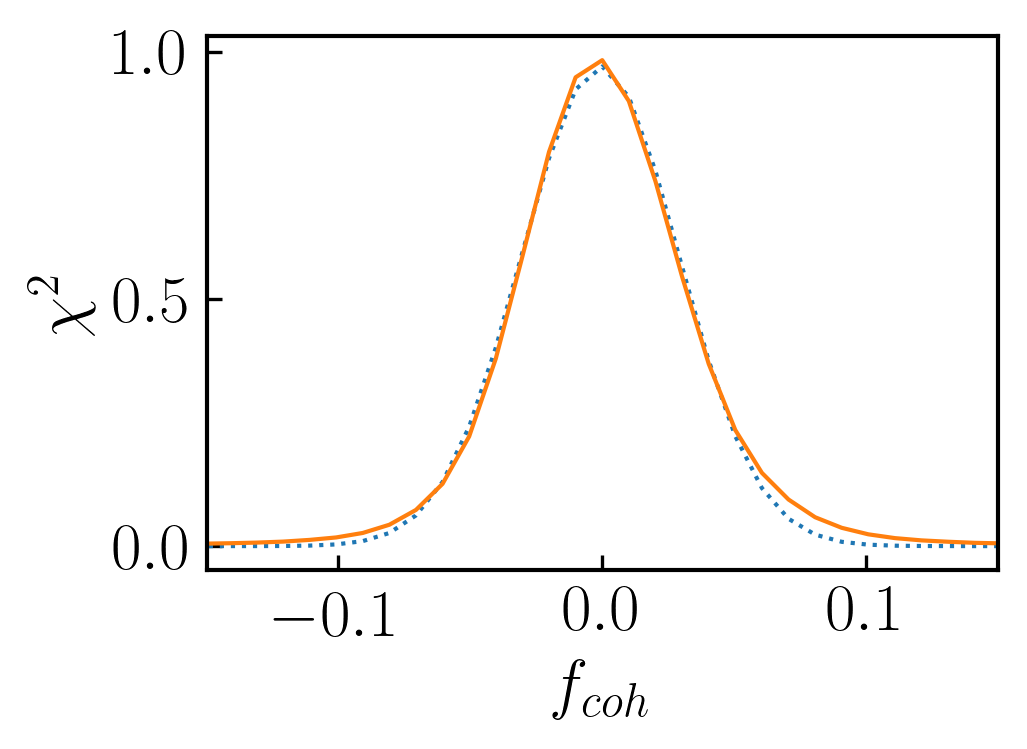

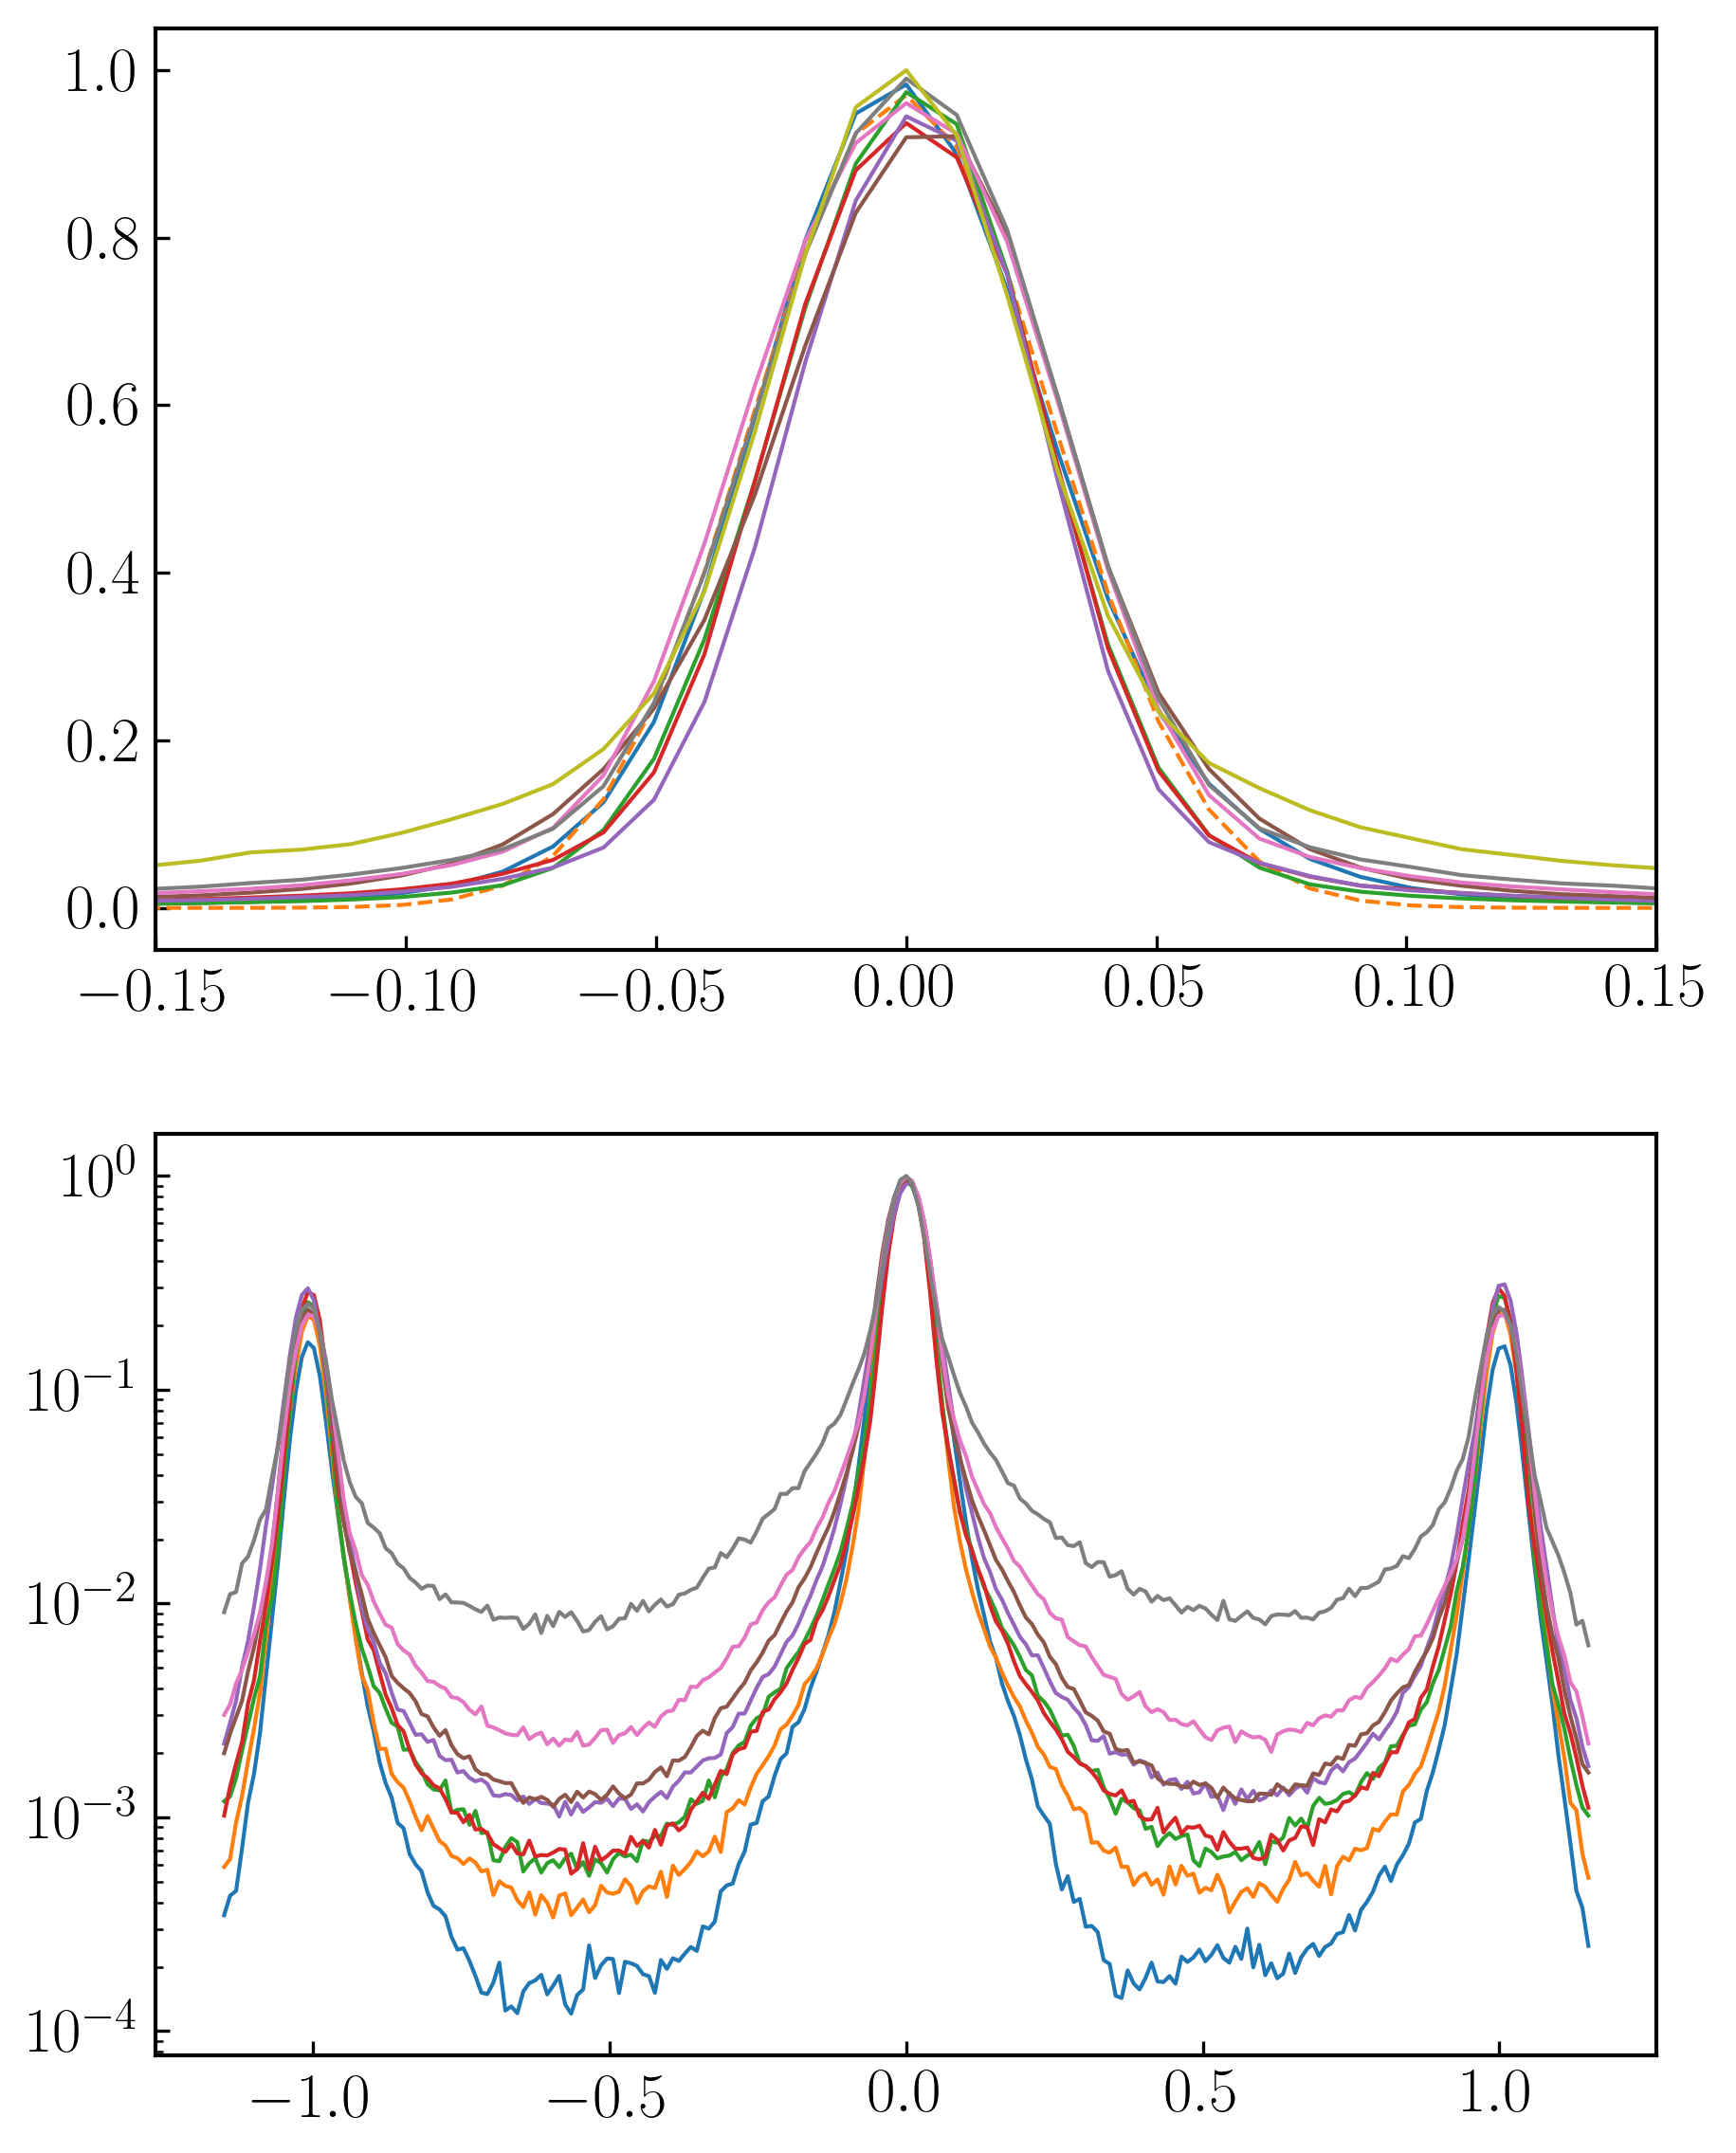

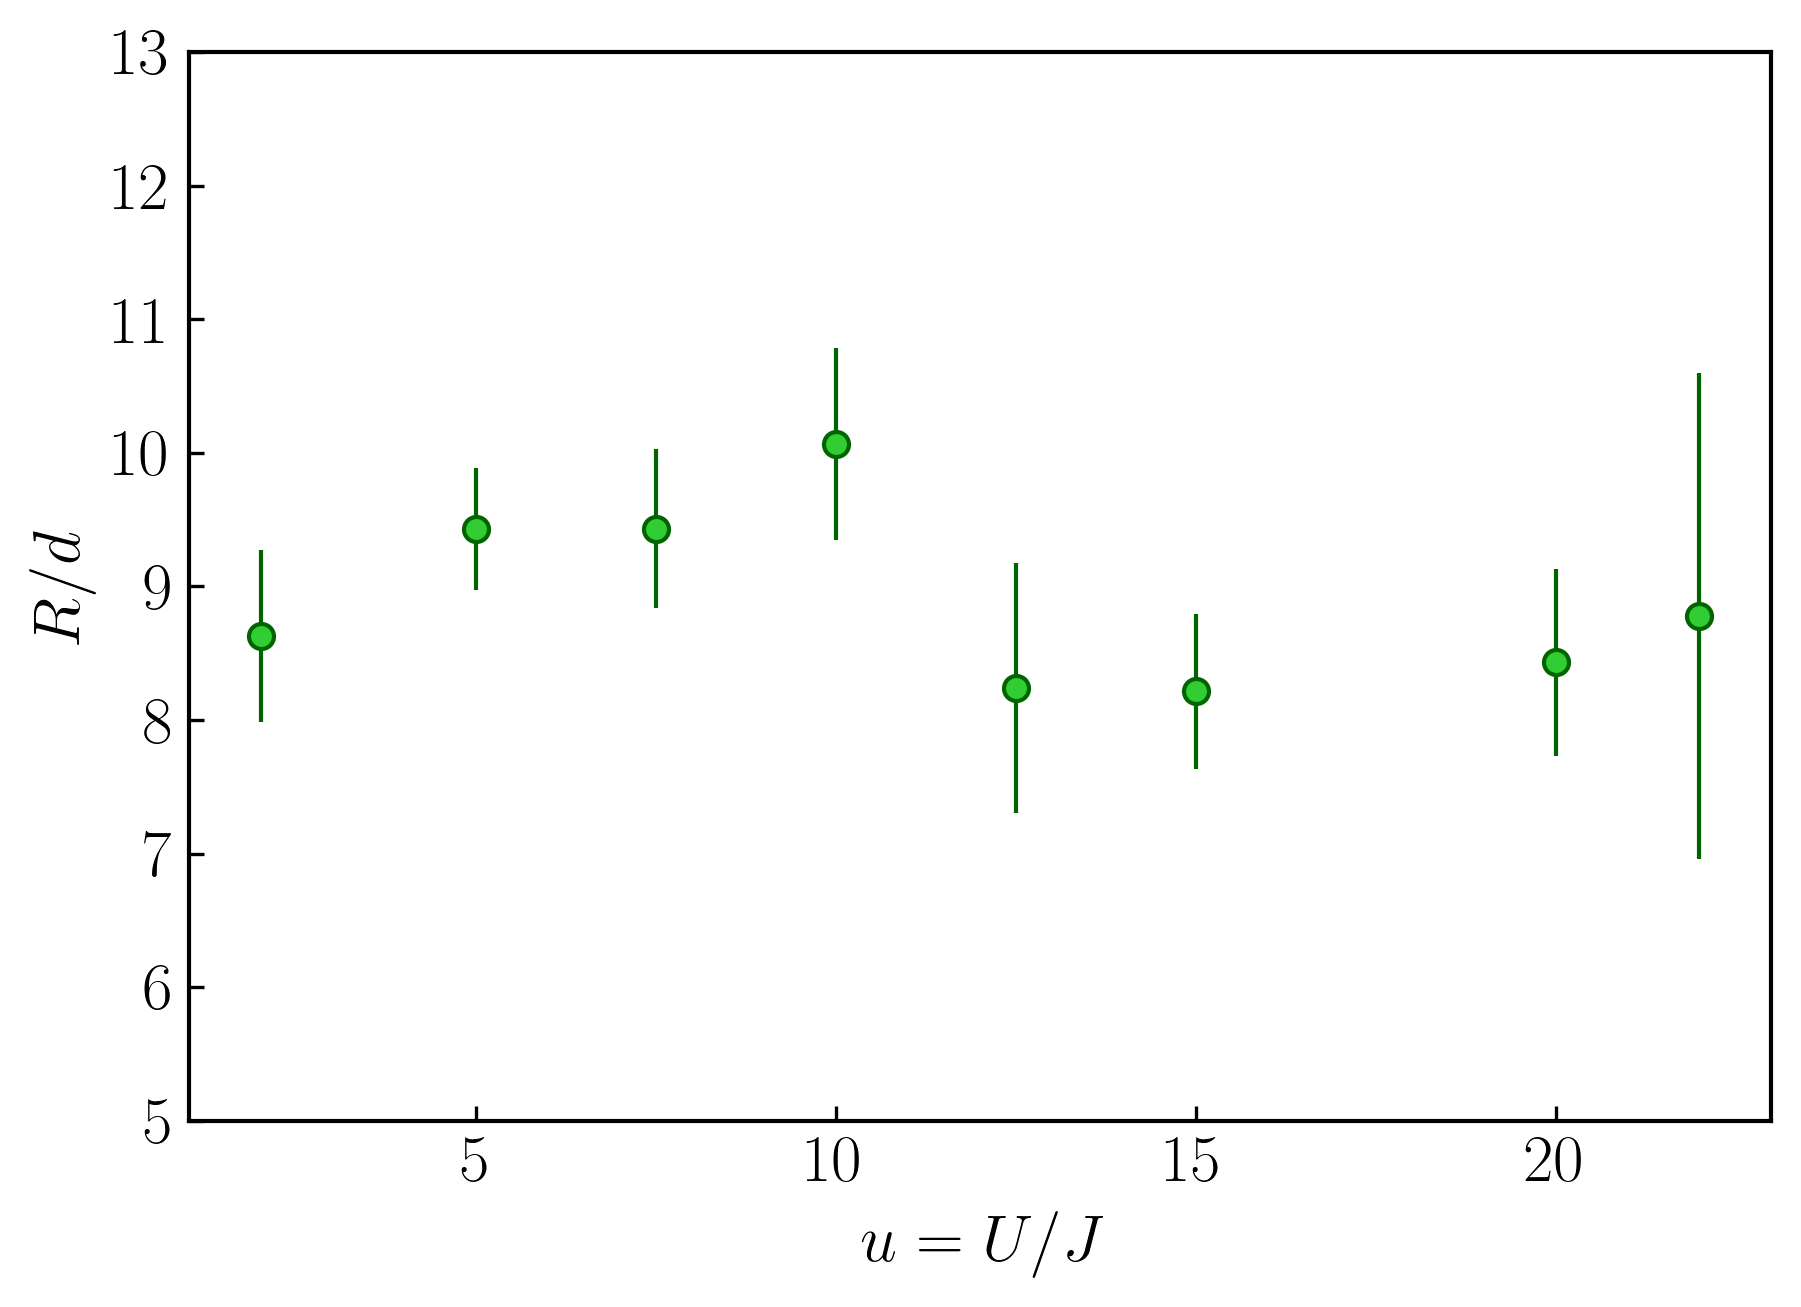

In [20]:
xmin=80
xmax=150

def gauss(x, x1, x2, x3):
    return  x1*np.exp(-(x-x2)**2/2/x3**2)

fit_res, cov = curve_fit(gauss, 
                        bin_centers[xmin:xmax], 
                        rho_k_2p0[xmin:xmax],
                        p0=[1,0,0.1])    

plt.figure(figsize=[0.5*fig_width,0.5*fig_height])
plt.plot(bin_centers,fit_res[0]*np.exp(-(bin_centers-fit_res[1])**2/2/fit_res[2]**2),linestyle='dotted')
plt.plot(bin_centers,rho_k_2p0)
plt.xlim(-0.15,.15)
plt.xlabel(r'$f_{coh}$')
plt.ylabel(r'$\chi^2$')

print(fit_res[2])
print(np.sqrt(cov[2,2]))

fig=plt.figure(figsize=[fig_width,2*fig_height])

ax1=plt.subplot(2, 1, 1)

ax1.plot(bin_centers,rho_k_2p0)
ax1.plot(bin_centers[xmin:xmax],fit_res[0]*np.exp(-(bin_centers[xmin:xmax]-fit_res[1])**2/2/fit_res[2]**2),linestyle="dashed")

ax1.plot(bin_centers,rho_k_5p0)
ax1.plot(bin_centers,rho_k_7p5)
ax1.plot(bin_centers,rho_k_10p0)
ax1.plot(bin_centers,rho_k_12p5)
ax1.plot(bin_centers,rho_k_15p0)
ax1.plot(bin_centers,rho_k_20p0)
ax1.plot(bin_centers,rho_k_22p0)
ax1.set_xlim(-0.15,.15)

ax2=plt.subplot(2, 1, 2)

ax2.plot(bin_centers,rho_k_2p0)
ax2.plot(bin_centers,rho_k_5p0)
ax2.plot(bin_centers,rho_k_7p5)
ax2.plot(bin_centers,rho_k_10p0)
ax2.plot(bin_centers,rho_k_12p5)
ax2.plot(bin_centers,rho_k_15p0)
ax2.plot(bin_centers,rho_k_20p0)
ax2.plot(bin_centers,rho_k_22p0)
ax2.semilogy()

sigBEC=np.array([0.0295, 0.0270, 0.0270, 0.0253, 0.0309, 0.0310, 0.0302, 0.0290])
err_sigBEC=np.array([0.00022, 0.00013, 0.00017, 0.00018, 0.00035, 0.00022, 0.00025, 0.0006])*10
fig=plt.figure(figsize=[fig_width,fig_height])
plt.errorbar(U_J_fc[1:9],1.6/sigBEC/2/np.pi,yerr=1.6*err_sigBEC/sigBEC**2/2/np.pi,marker='o',   
         markersize=6,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='limegreen'
        )
plt.xlabel(r'$u=U/J$')
plt.ylabel(r'$R/d$')
plt.ylim(5,13)


In [21]:
0.9*.09/.12

0.675

## Figure papier

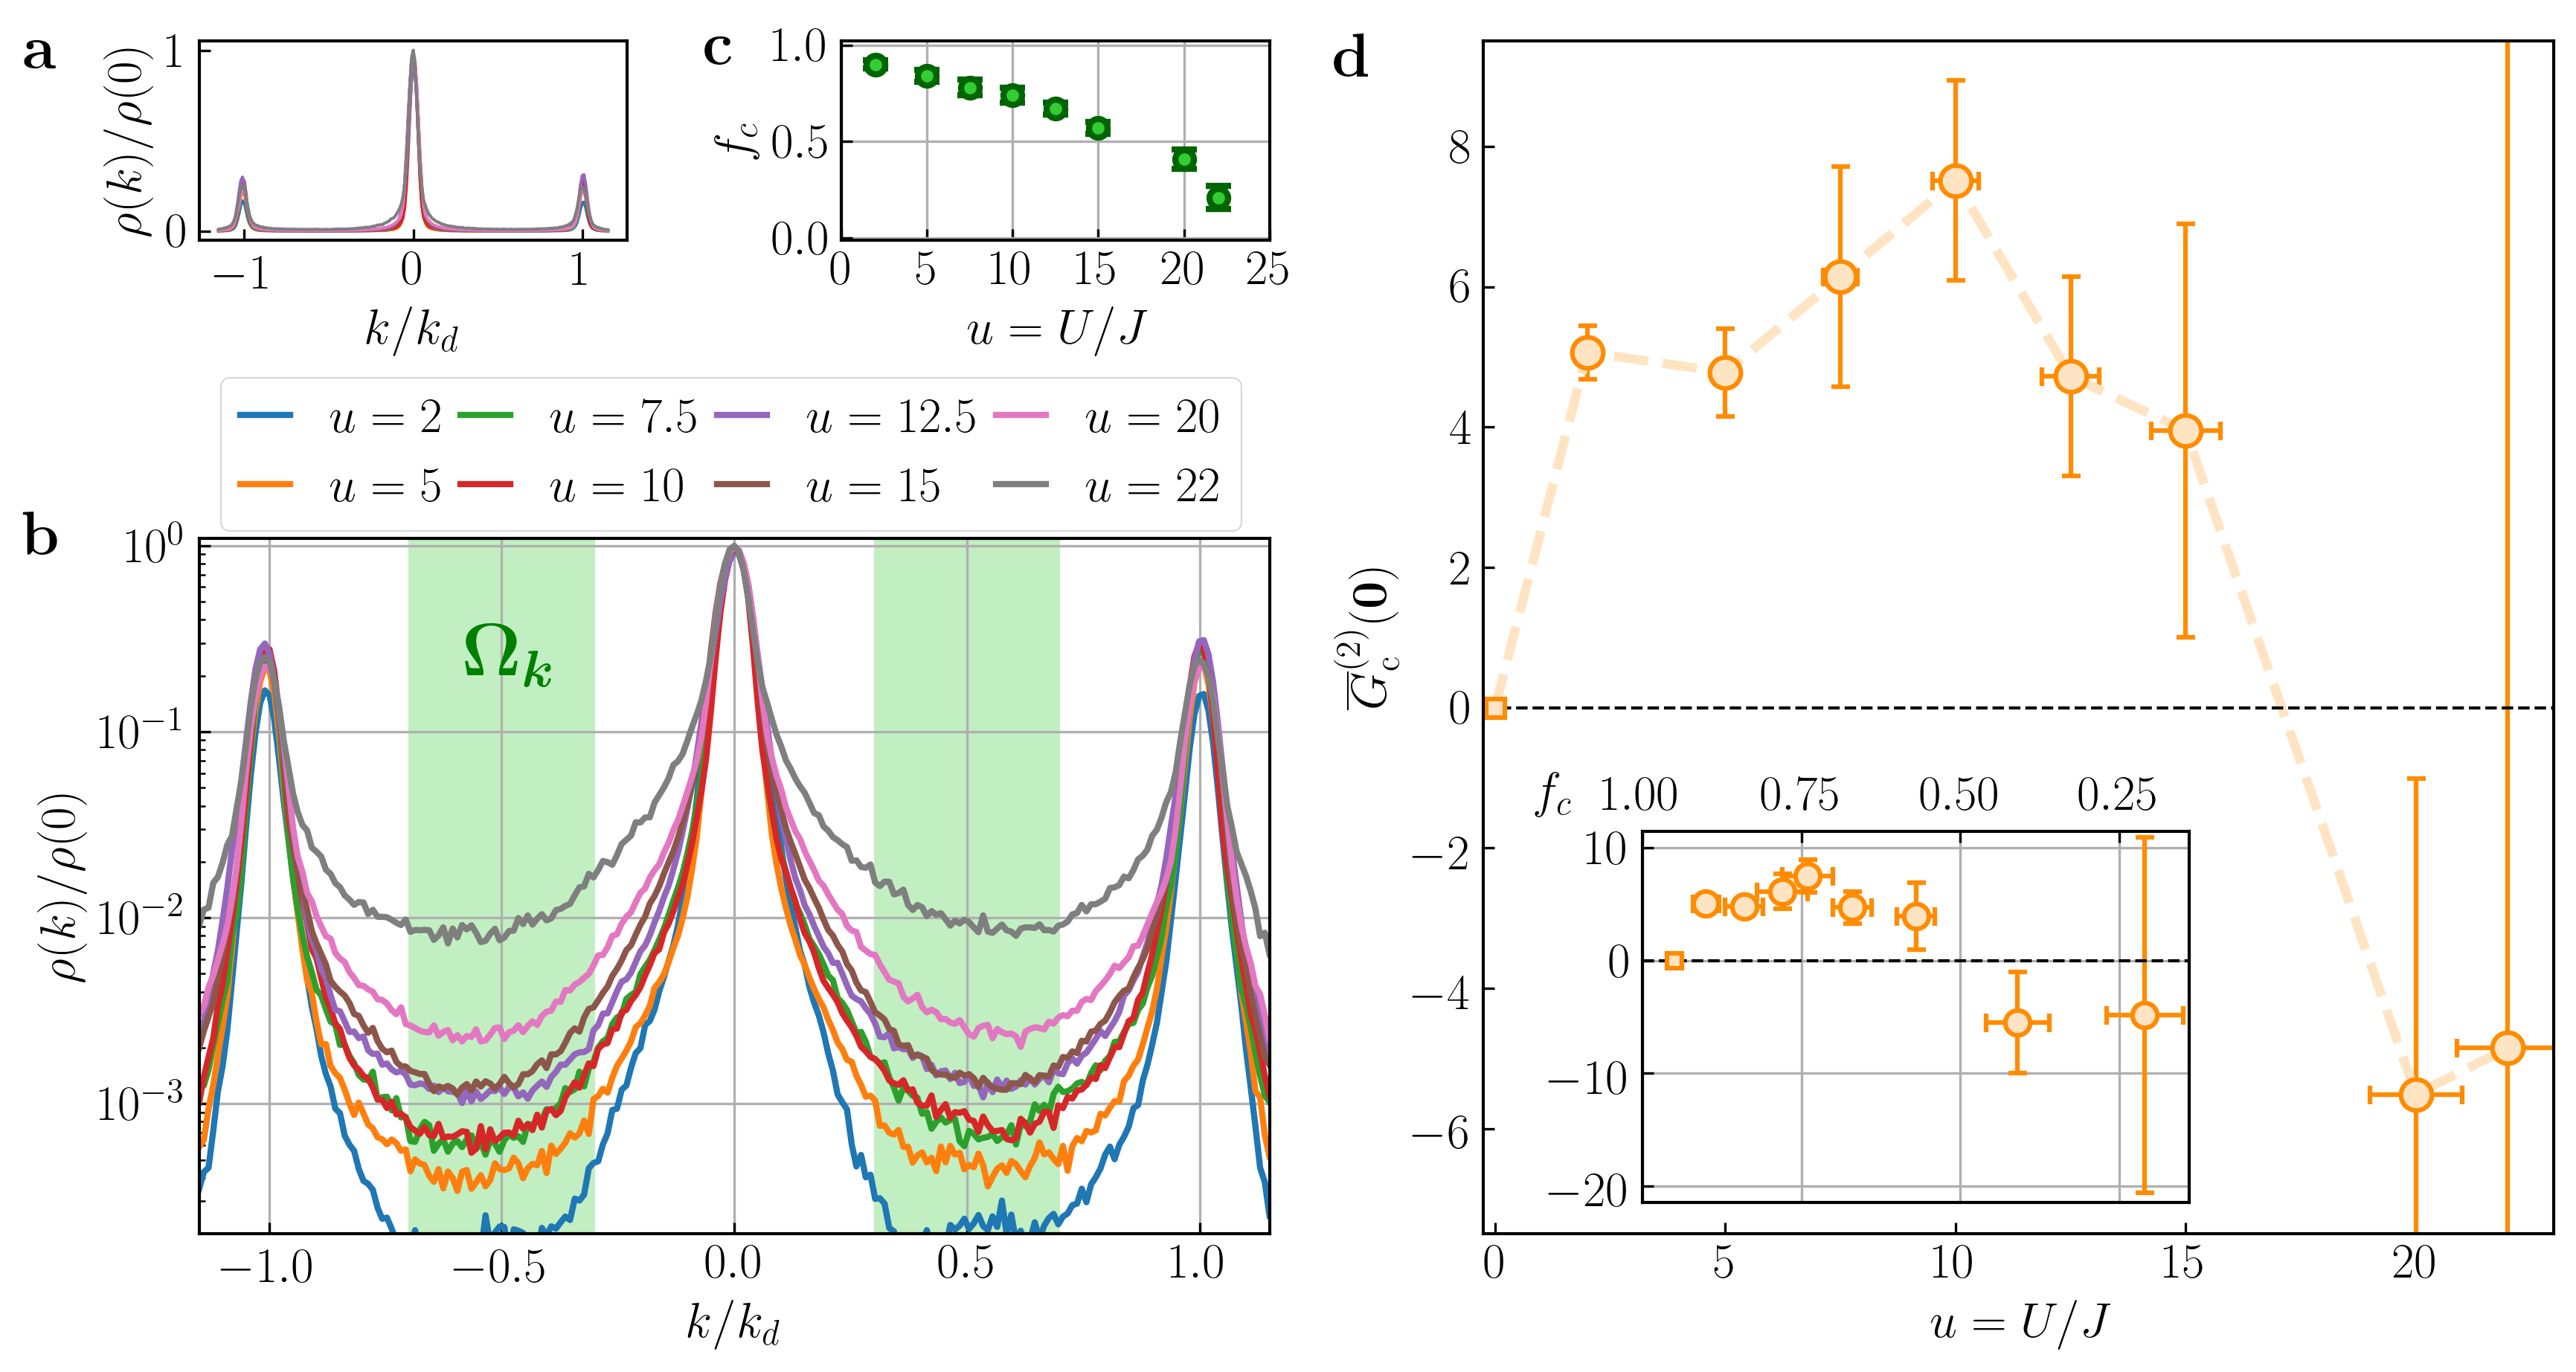

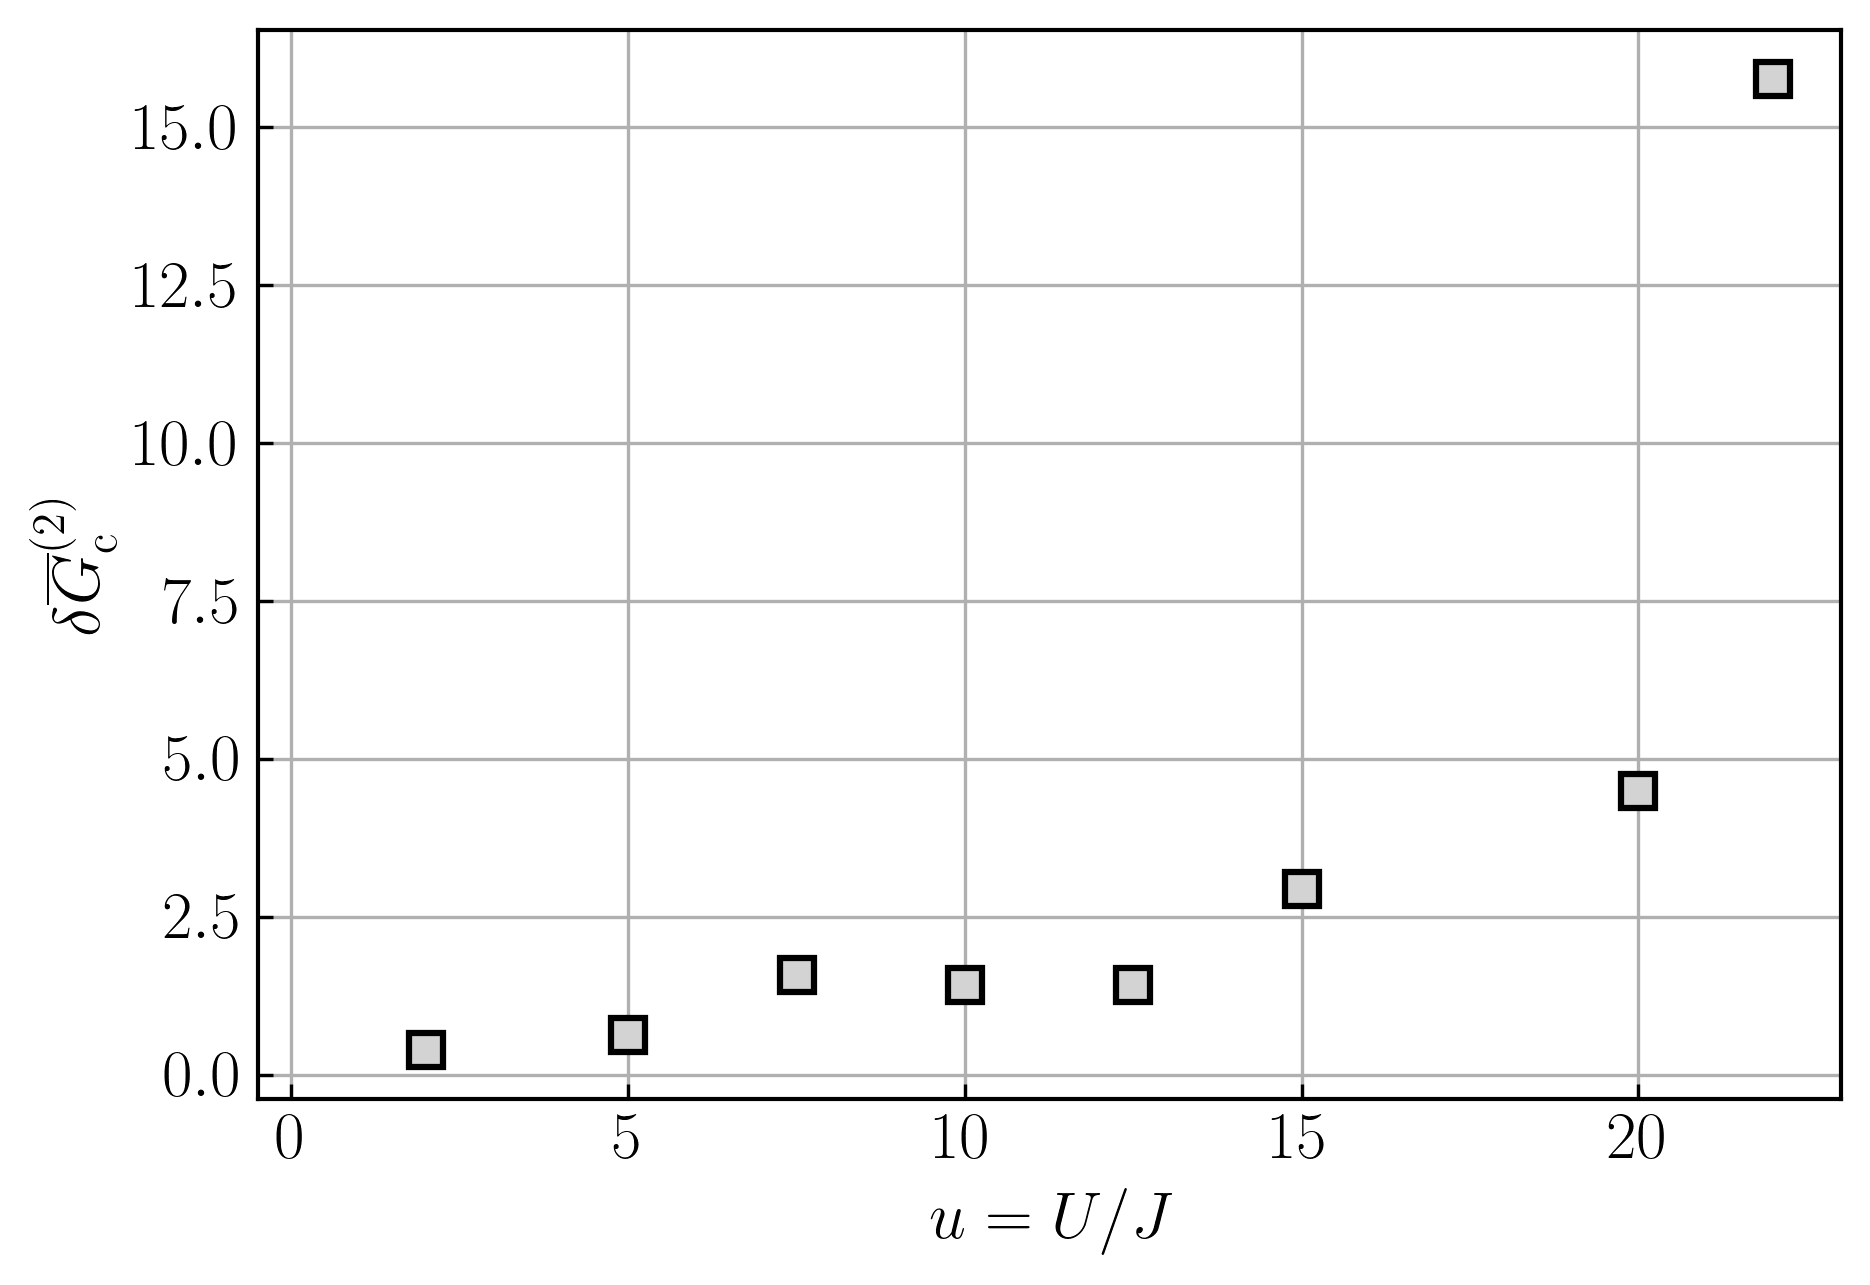

In [22]:

grid=plt.GridSpec(3,4,height_ratios=[1,1,1],width_ratios=[1,1,1,1])


fig=plt.figure(figsize=[2*fig_width,1.5*fig_height])
grid.update(wspace=0.5)
grid.update(hspace=1.5)

# ax2 = plt.subplot(grid[0:, 0:2])
# ax3 = plt.subplot(grid[1:, 2:4])
# ax1 = plt.subplot(grid[0, 2:4])

ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1:, 0:2])
ax4 = plt.subplot(grid[0, 0])
ax1 = plt.subplot(grid[0:,2:])

####################################################################################
ax2.text(-8,0.9,r'\textbf{c}',fontsize=20)

ax2.errorbar(U_J_fc[1:9],fc_corr[1:9],yerr=err_fc_corr[1:9],
        marker='o',markersize=6,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='limegreen',
        markeredgewidth=2.0,lw=2
            )

#ax2.plot(U_J_fc[1:9],fc_corr[1:9], linestyle='dashed', color='limegreen',linewidth=2)
ax2.grid()
ax2.xaxis.set_ticks(np.arange(0, 26, 5))
ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.5))
ax2.tick_params(axis='x')
ax2.tick_params(axis='y')
ax2.set_ylim(-0.01,1.02)
ax2.set_xlim(0,25)

ax2.set_xlabel('$u=U/J$')
ax2.set_ylabel(r'$f_c$')
####################################################################################
ax4.text(-2.3,0.9,r'\textbf{a}',fontsize=20)

ax4.plot(bin_centers,rho_k_2p0)
ax4.plot(bin_centers,rho_k_5p0)
ax4.plot(bin_centers,rho_k_7p5)
ax4.plot(bin_centers,rho_k_10p0)
ax4.plot(bin_centers,rho_k_12p5)
ax4.plot(bin_centers,rho_k_15p0)
ax4.plot(bin_centers,rho_k_20p0)
ax4.plot(bin_centers,rho_k_22p0)

ax4.set_xlabel(r'$k/k_d$')
ax4.set_ylabel(r'$\rho(k)/\rho(0)$')
####################################################################################
ax3.text(-1.53,0.9,r'\textbf{b}',fontsize=20)

ax3.plot(bin_centers,rho_k_2p0,linewidth=2,label=r'$u=2$')
ax3.plot(bin_centers,rho_k_5p0,linewidth=2,label=r'$u=5$')
ax3.plot(bin_centers,rho_k_7p5,linewidth=2,label=r'$u=7.5$')
ax3.plot(bin_centers,rho_k_10p0,linewidth=2,label=r'$u=10$')
ax3.plot(bin_centers,rho_k_12p5,linewidth=2,label=r'$u=12.5$')
ax3.plot(bin_centers,rho_k_15p0,linewidth=2,label=r'$u=15$')
ax3.plot(bin_centers,rho_k_20p0,linewidth=2,label=r'$u=20$')
ax3.plot(bin_centers,rho_k_22p0,linewidth=2,label=r'$u=22$')
ax3.semilogy()
ax3.legend(loc=(0.02,1.01),mode="expand",ncols=4,handlelength=1)
ax3.grid()
ax3.set_xlabel(r'$k/k_d$')
ax3.set_ylabel(r'$\rho(k)/\rho(0)$')

rect = patches.Rectangle((-0.7,1e-5),(0.7-0.3),2,linewidth=0,edgecolor='b',facecolor='limegreen',alpha=0.3)
ax3.add_patch(rect)

rect = patches.Rectangle((0.3,1e-5),(0.7-0.3),2,linewidth=0,edgecolor='b',facecolor='limegreen',alpha=0.3)
ax3.add_patch(rect)
ax3.text(-0.58,0.2,r'$\bm{\Omega_k}$',color='green',fontsize=24,fontweight='bold')

ax3.set_ylim(2e-4,1.1)
ax3.set_xlim(-1.15,1.15)
####################################################################################
ax1.text(-3.5,9,r'\textbf{d}',fontsize=20)
#ax1.text(-3.5,-0.52,'(b)')


ax1.errorbar(U_J[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,xerr=U_J[1:9]*0.05,
             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
U_J_line=np.concatenate(([0],U_J[1:9]),axis=None)
G2c_line=np.concatenate(([0],G2c_0p18kd),axis=None)

ax1.plot(U_J_line,G2c_line,
             linestyle='--',linewidth=3,
             color='bisque',
            )

ax1.errorbar([0],[0],yerr=0,
             marker='s',markersize=6,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )

ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm 0)$")
ax1.set_xlabel('$u=U/J$')
#plt.grid()
ax1.set_ylim(-7.5,9.5)
ax1.set_xlim(-0.25,23)


# this is an inset axes over the main axes
ax1ins = plt.axes([.6, .13, .18, .24])
#ax1ins.set_xlabel('$f_c$')
#ax1ins.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm K= \bm 0)$")
#ax1.set_ylabel('$$')
plt.grid(True)
ax1ins.set_xlim(max(fc_corr[1:9])+0.05, min(fc_corr[1:9])-0.05)
ax1ins.errorbar(fc_corr[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,xerr=err_fc_corr[1:9],
             marker='o',markersize=8,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.errorbar([0.95],[0],yerr=0,
             marker='s',markersize=5,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.axhline(y=0, color='black', linestyle='--')

fc_line=np.concatenate(([0.95],fc_corr[1:9]),axis=None)
#ax1ins.plot(fc_line,G2c_line,
#             linestyle='--',linewidth=3,
#             color='bisque')
ax1ins.yaxis.set_ticks(np.arange(-20, 15, 10))

ax1.text(0.85,-1.42,r'$f_c$ ')

ax1ins.xaxis.tick_top()
ax1ins.set_xticks([1,0.75,0.5,0.25 ]) 
ax1ins.xaxis.set_label_position('top') 
ax1ins.set_ylim(-21.5,11.5)
ax1ins.set_xlim(1.0,0.14)

plt.savefig('figure2.pdf', dpi=300,bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=[fig_width,fig_height])
#plt.plot(U_J[1:8],2*err_G2c_0p042kd/eta**2/(2*G2c_0p042kd/eta**2),'o')
plt.errorbar(U_J[1:9],err_G2c_0p18kd,
             marker='s',markersize=8,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='black',
             markeredgecolor='black',
             markerfacecolor='lightgrey',
            )
#plt.semilogy()
#plt.ylabel(r"$\delta \overline{G}_{\rm c}^{(2)} / \overline{G}_{\rm c}^{(2)}$")
plt.xlim(-0.5,23)
plt.ylabel(r"$\delta \overline{G}_{\rm c}^{(2)} $")
plt.xlabel('$u=U/J$')
plt.grid()

/var/folders/33/dnxtnbgs4x9bd02xgsmd58v80000gp/T/ipykernel_19889/2100318445.py:32: RuntimeWarning: invalid value encountered in power
  ax2.plot(UsuJscale,(1-UsuJscale/26)**(2*0.3485), linestyle='dashed', color='green',linewidth=2)


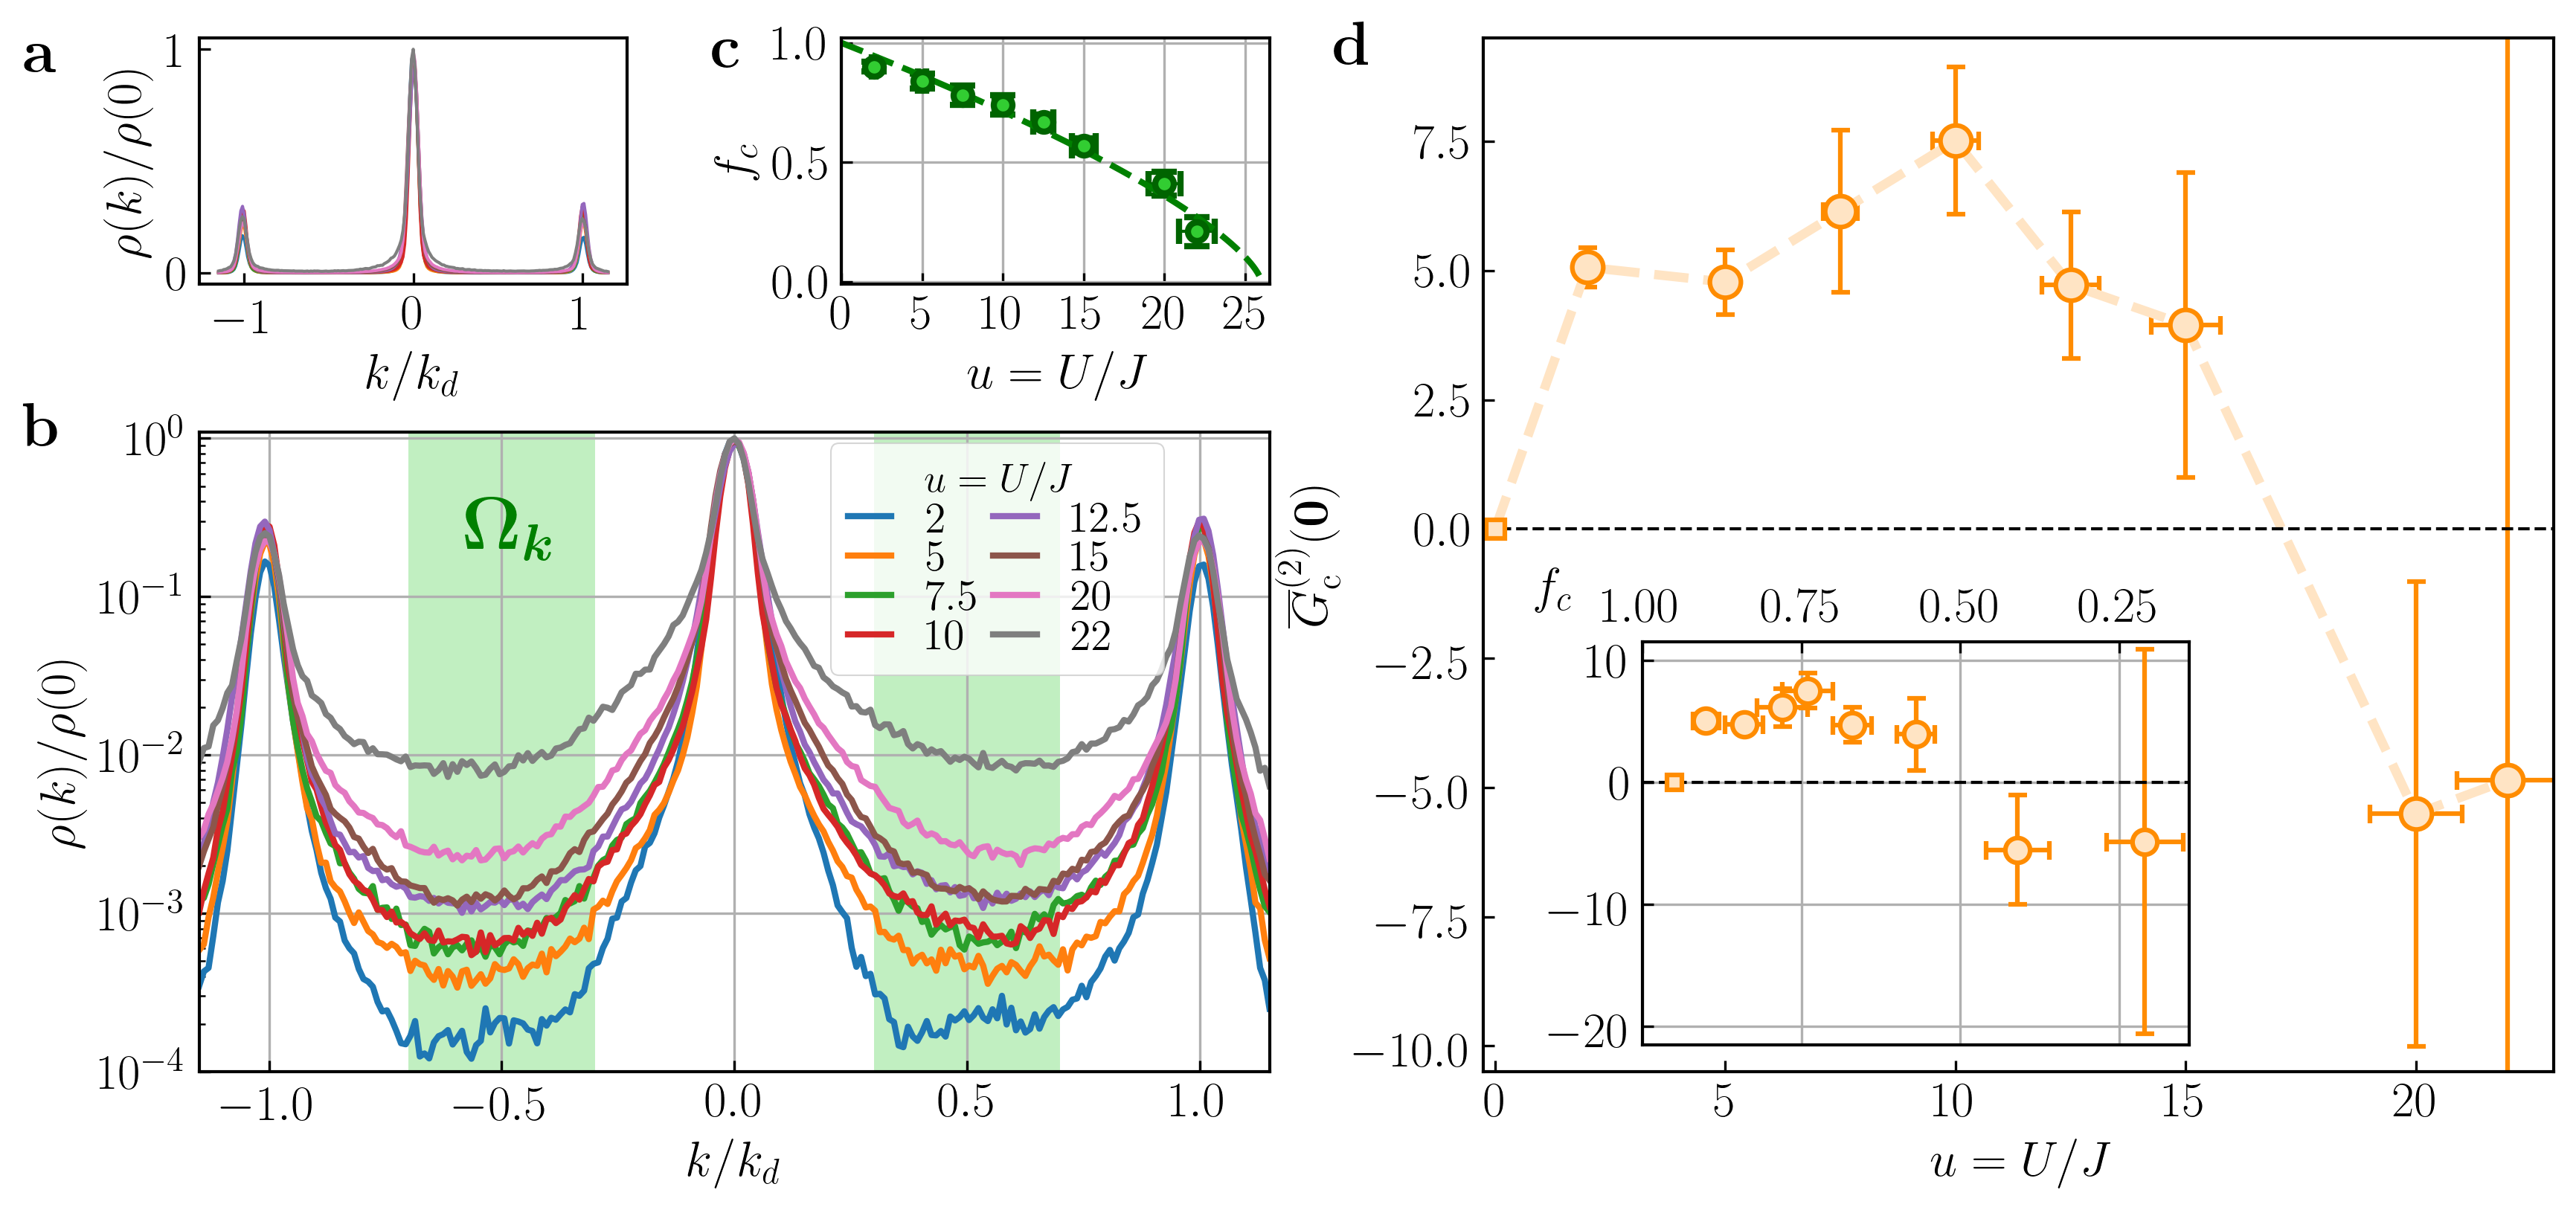

In [23]:

grid=plt.GridSpec(3,4,height_ratios=[1,1,1],width_ratios=[1,1,1,1])


fig=plt.figure(figsize=[2*fig_width,1.3*fig_height])
grid.update(wspace=0.5)
grid.update(hspace=0.6)

# ax2 = plt.subplot(grid[0:, 0:2])
# ax3 = plt.subplot(grid[1:, 2:4])
# ax1 = plt.subplot(grid[0, 2:4])

ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1:, 0:2])
ax4 = plt.subplot(grid[0, 0])
ax1 = plt.subplot(grid[0:,2:])

####################################################################################
ax2.text(-8,0.9,r'\textbf{c}',fontsize=20)

ax2.errorbar(U_J_fc[1:9],fc_corr[1:9],yerr=err_fc_corr[1:9],xerr=U_J[1:9]*0.05,
        marker='o',markersize=6,capsize=4.0,elinewidth=1,capthick=1,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='limegreen',
        markeredgewidth=2.0,lw=2
            )


UsuJscale=np.linspace(0,30,200)
#plt.plot(U_J_fc[1:9],fc_corr[1:9], linestyle='dashed', color='limegreen',linewidth=2)
ax2.plot(UsuJscale,(1-UsuJscale/26)**(2*0.3485), linestyle='dashed', color='green',linewidth=2)

#ax2.plot(U_J_fc[1:9],fc_corr[1:9], linestyle='dashed', color='limegreen',linewidth=2)
ax2.grid()
ax2.xaxis.set_ticks(np.arange(0, 26, 5))
ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.5))
ax2.tick_params(axis='x')
ax2.tick_params(axis='y')
ax2.set_ylim(-0.01,1.02)
ax2.set_xlim(0,26.5)

ax2.set_xlabel('$u=U/J$')
ax2.set_ylabel(r'$f_c$')
####################################################################################
ax4.text(-2.3,0.9,r'\textbf{a}',fontsize=20)

ax4.plot(bin_centers,rho_k_2p0)
ax4.plot(bin_centers,rho_k_5p0)
ax4.plot(bin_centers,rho_k_7p5)
ax4.plot(bin_centers,rho_k_10p0)
ax4.plot(bin_centers,rho_k_12p5)
ax4.plot(bin_centers,rho_k_15p0)
ax4.plot(bin_centers,rho_k_20p0)
ax4.plot(bin_centers,rho_k_22p0)

ax4.set_xlabel(r'$k/k_d$')
ax4.set_ylabel(r'$\rho(k)/\rho(0)$')
####################################################################################
ax3.text(-1.53,0.9,r'\textbf{b}',fontsize=20)

ax3.plot(bin_centers,rho_k_2p0,linewidth=2,label=r'$2$')
ax3.plot(bin_centers,rho_k_5p0,linewidth=2,label=r'$5$')
ax3.plot(bin_centers,rho_k_7p5,linewidth=2,label=r'$7.5$')
ax3.plot(bin_centers,rho_k_10p0,linewidth=2,label=r'$10$')
ax3.plot(bin_centers,rho_k_12p5,linewidth=2,label=r'$12.5$')
ax3.plot(bin_centers,rho_k_15p0,linewidth=2,label=r'$15$')
ax3.plot(bin_centers,rho_k_20p0,linewidth=2,label=r'$20$')
ax3.plot(bin_centers,rho_k_22p0,linewidth=2,label=r'$22$')
ax3.semilogy()
ax3.legend(loc=(0.59,0.62),ncols=2,handlelength=1,labelspacing=0.01,fontsize=14,
           title=r'$u=U/J$',title_fontsize=13,columnspacing=0.3)
ax3.grid()
ax3.set_xlabel(r'$k/k_d$')
ax3.set_ylabel(r'$\rho(k)/\rho(0)$')

rect = patches.Rectangle((-0.7,1e-5),(0.7-0.3),2,linewidth=0,edgecolor='b',facecolor='limegreen',alpha=0.3)
ax3.add_patch(rect)

rect = patches.Rectangle((0.3,1e-5),(0.7-0.3),2,linewidth=0,edgecolor='b',facecolor='limegreen',alpha=0.3)
ax3.add_patch(rect)
ax3.text(-0.58,0.2,r'$\bm{\Omega_k}$',color='green',fontsize=24,fontweight='bold')

ax3.set_ylim(1e-4,1.1)
ax3.set_xlim(-1.15,1.15)
####################################################################################
ax1.text(-3.5,9,r'\textbf{d}',fontsize=20)
#ax1.text(-3.5,-0.52,'(b)')


ax1.errorbar(U_J[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,xerr=U_J[1:9]*0.05,
             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
U_J_line=np.concatenate(([0],U_J[1:9]),axis=None)
G2c_line=np.concatenate(([0],G2c_0p18kd),axis=None)

ax1.plot(U_J_line,G2c_line,
             linestyle='--',linewidth=3,
             color='bisque',
            )

ax1.errorbar([0],[0],yerr=0,
             marker='s',markersize=6,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )

ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm 0)$")
ax1.set_xlabel('$u=U/J$')
#plt.grid()
ax1.set_ylim(-10.5,9.5)
ax1.set_xlim(-0.25,23)


# this is an inset axes over the main axes
ax1ins = plt.axes([.6, .13, .18, .3])
#ax1ins.set_xlabel('$f_c$')
#ax1ins.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm K= \bm 0)$")
#ax1.set_ylabel('$$')
plt.grid(True)
ax1ins.set_xlim(max(fc_corr[1:9])+0.05, min(fc_corr[1:9])-0.05)
ax1ins.errorbar(fc_corr[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,xerr=err_fc_corr[1:9],
             marker='o',markersize=8,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.errorbar([0.95],[0],yerr=0,
             marker='s',markersize=5,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.axhline(y=0, color='black', linestyle='--')

fc_line=np.concatenate(([0.95],fc_corr[1:9]),axis=None)
#ax1ins.plot(fc_line,G2c_line,
#             linestyle='--',linewidth=3,
#             color='bisque')
ax1ins.yaxis.set_ticks(np.arange(-20, 15, 10))

ax1.text(0.85,-1.42,r'$f_c$ ')

ax1ins.xaxis.tick_top()
ax1ins.set_xticks([1,0.75,0.5,0.25 ]) 
ax1ins.xaxis.set_label_position('top') 
ax1ins.set_ylim(-21.5,11.5)
ax1ins.set_xlim(1.0,0.14)

plt.savefig('figure2.pdf', dpi=300,bbox_inches='tight')
plt.show()


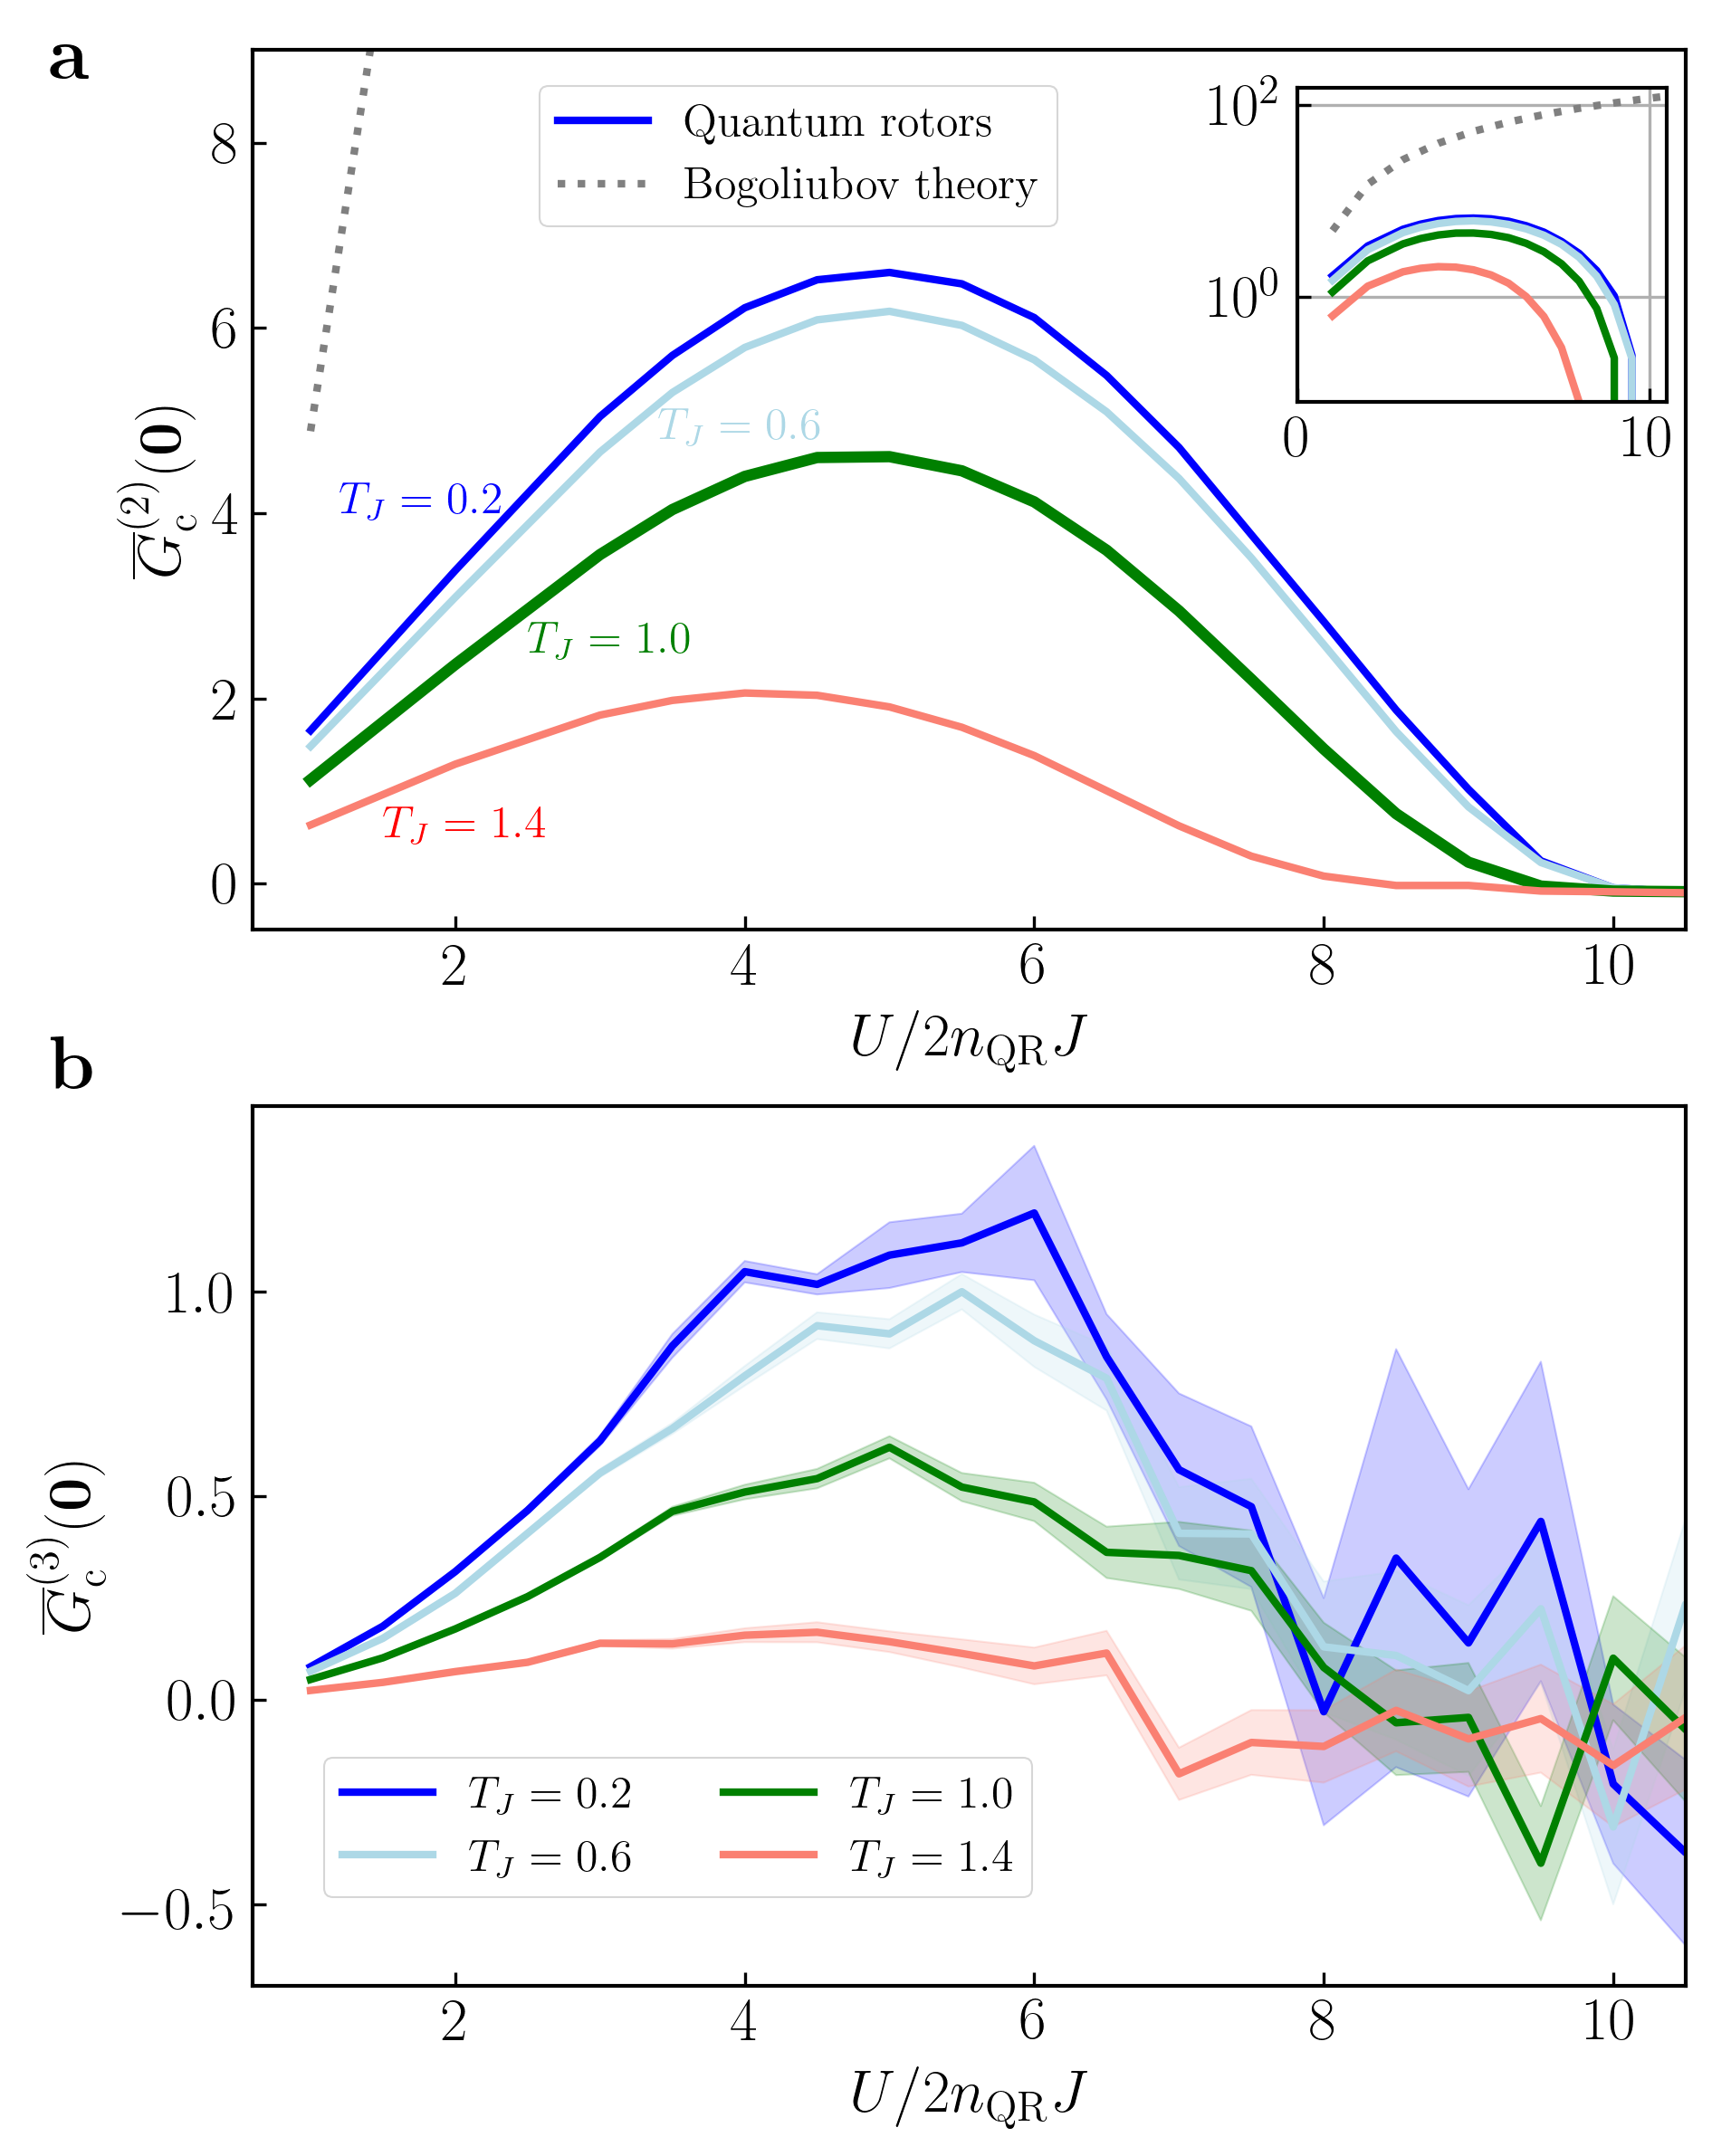

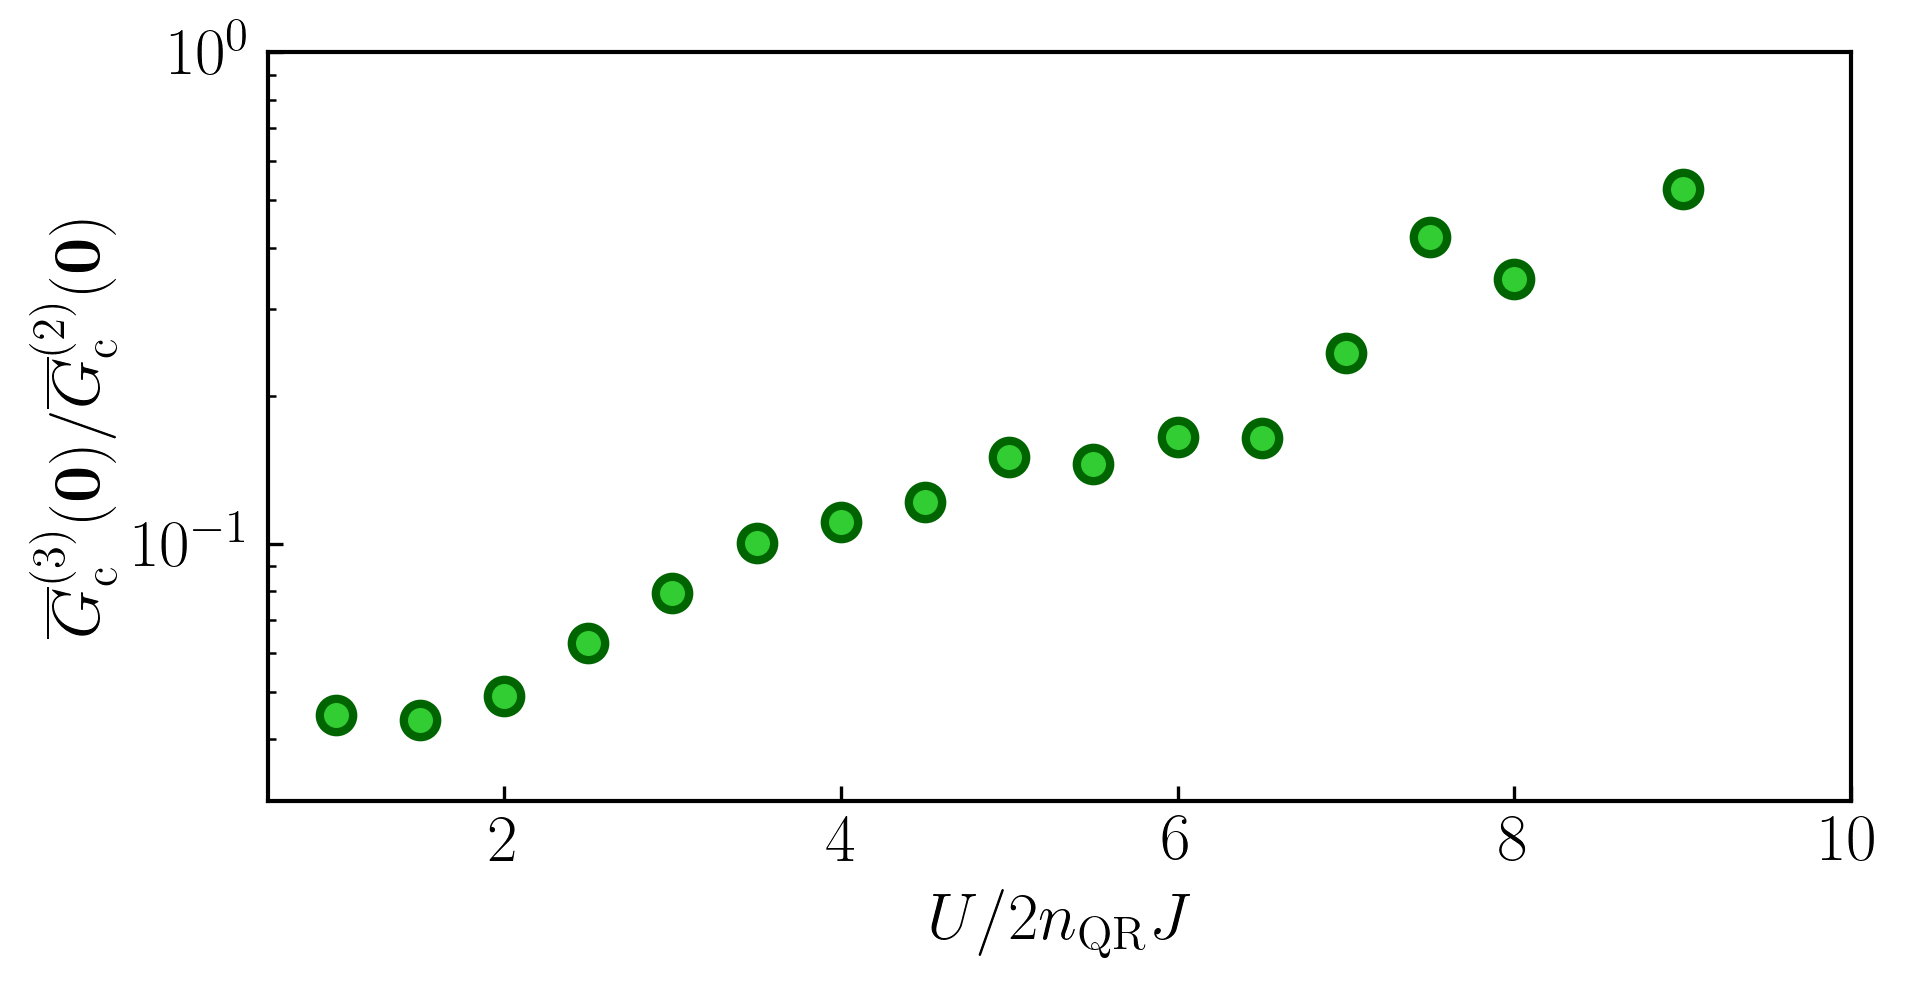

In [24]:
fig = plt.figure(figsize=[fig_width,2*fig_height])

ax1=plt.subplot(2, 1, 1)

ax1.text(-.8,8.7,r'\textbf{a}',fontsize=20)

ax1.text(1.5,0.5,r'$T_J=1.4$',size='12',color='red')
ax1.text(1.2,4,r'$T_J=0.2$',size='12',color='blue')
ax1.text(2.5,2.5,r'$T_J=1.0$',size='12',color='green')
ax1.text(3.4,4.8,r'$T_J=0.6$',size='12',color='lightblue')

ax1.plot(U_2nJ_0p2,G2c_QR_0p2,linewidth=2,color='blue',label='Quantum rotors')#,label='$T/2nJ=0.2$')
ax1.plot(U_2nJ_0p2,G2c_QR_0p6,linewidth=2,color='lightblue')#,label='$T/2nJ=0.6$')
ax1.plot(U_2nJ_0p2,G2c_QR_1p0,linewidth=3, color='green')#,label='$T/2nJ=1.0$')
ax1.plot(U_2nJ_0p2,G2c_QR_1p4,linewidth=2,color='salmon')#,label='$T/2nJ=1.4$')
#ax1.plot(U_2nJ_0p2,G2c_QR_1p8,linewidth=2,color='red')#,label='$T/2nJ=1.8$')

ax1.plot(U_J_Bogo_1p0,G2c_Bogo_1p0,linestyle='dotted',linewidth=2,color='grey',label='Bogoliubov theory')

#ax1.errorbar(U_J[1:8]/2.6,G2c_0p042kd,yerr=err_G2c_0p042kd,
#             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
#             linestyle='none',
#             color='darkorange',
#             markeredgecolor='darkorange',
#             markerfacecolor='bisque',
#            )

#ax1.axhline(y=0, color='black', linestyle='--')

ax1.set_xlim(.6,10.5)
ax1.set_ylim(-.5,9)
ax1.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm 0)$")#,fontsize = 24)
ax1.set_xlabel(r'$U/2n_{\rm QR}J$')
ax1.legend(fontsize="12", loc =(0.2,0.8))

# this is an inset axes over the main axes
ax1ins = plt.axes([.69, .74, .2, .125])
#ax2ins.set_xlabel('$U/2nJ$')
#ax1.set_ylabel('$$')
plt.grid(True)
ax1ins.plot(U_2nJ_0p2,G2c_QR_0p2,linewidth=2,color='blue')#,label='$T/2nJ=0.2$')
ax1ins.plot(U_2nJ_0p2,G2c_QR_0p6,linewidth=2,color='lightblue')#,label='$T/2nJ=0.6$')
ax1ins.plot(U_2nJ_0p2,G2c_QR_1p0,linewidth=2,color='green')#,label='$T/2nJ=1.0$')
ax1ins.plot(U_2nJ_0p2,G2c_QR_1p4,linewidth=2,color='salmon')#,label='$T/2nJ=1.4$')
#ax1ins.plot(U_2nJ_0p2,G2c_QR_1p8,linewidth=2,color='red')#,label='$T/2nJ=1.8$')
ax1ins.plot(U_J_Bogo_1p0,G2c_Bogo_1p0,linewidth=2,linestyle='dotted',color='grey')
ax1ins.semilogy()
ax1ins.set_xlim(0,10.5)
ax1ins.set_ylim(0.08,150)

ax2=plt.subplot(2, 1, 2)

ax2.text(-.8,1.5,r'\textbf{b}',fontsize=20)

#ax2.plot(U_2nJ_0p2,G2c_QR_1p0,label=r"$n=2$; $T_J=1.0$",linewidth=2,color="green")
#ax2.plot(U_2nJ_G3,G3c_QR_0p2,label=r"$n=3$; $T_J=1.0$",linewidth=2,linestyle='-.',color="black")
ax2.plot(U_2nJ_G3,G3c_QR_0p2,label=r"$T_J=0.2$",linewidth=2,color='blue')
ax2.fill_between(U_2nJ_G3,G3c_QR_0p2-errG3c_QR_0p2,G3c_QR_0p2+errG3c_QR_0p2,color='blue',alpha=.2)
ax2.plot(U_2nJ_G3,G3c_QR_0p6,label=r"$T_J=0.6$",linewidth=2,color='lightblue')
ax2.fill_between(U_2nJ_G3,G3c_QR_0p6-errG3c_QR_0p6,G3c_QR_0p6+errG3c_QR_0p6,color='lightblue',alpha=.2)
ax2.plot(U_2nJ_G3,G3c_QR_1p0,label=r"$T_J=1.0$",linewidth=2,color='green')
ax2.fill_between(U_2nJ_G3,G3c_QR_1p0-errG3c_QR_1p0,G3c_QR_1p0+errG3c_QR_1p0,color='green',alpha=.2)
ax2.plot(U_2nJ_G3,G3c_QR_1p4,label=r"$T_J=1.4$",linewidth=2,color='salmon')
ax2.fill_between(U_2nJ_G3,G3c_QR_1p4-errG3c_QR_1p4,G3c_QR_1p4+errG3c_QR_1p4,color='salmon',alpha=.2)

ax2.legend(fontsize="12", loc=(0.05,0.1),ncols=2)#loc='center left')
ax2.set_xlim(0.6,10.5)
#plt.ylim(-0.1,.5)
#ax2.semilogy()
ax2.set_ylabel(r"$\overline{G}_{\rm c}^{(3)}( \bm 0)$")#,fontsize = 24)
ax2.set_xlabel(r'$U/2n_{\rm QR}J$')
#ax2.axvline(x=5,linestyle='--',color="green")
#ax2.axvline(x=6.,linestyle='--',color='black')


plt.savefig('figure3.pdf', dpi=300,bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=[fig_width,0.7*fig_height])

#plt.plot(U_2nJ_0p2,G2c_QR_1p0,linewidth=3, color='green')#,label='$T/2nJ=1.0$')
#plt.plot(U_2nJ_G3,9*G3c_QR_1p0,label=r"$T_J=1.0$",linewidth=2,color='green',linestyle='dashed')
#plt.plot(U_2nJ_G3,G3c_QR_1p0/G2c_QR_1p0,'o',label=r"$T_J=1.0$",linewidth=2)#,color='green')
plt.errorbar(U_2nJ_G3,G3c_QR_1p0/G2c_QR_1p0,
        marker='o',markersize=8,capsize=4.0,elinewidth=1,capthick=1,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='limegreen',
        markeredgewidth=2.0,lw=2
            )

plt.ylim(0.03,1)
plt.xlim(0.6,10)
plt.semilogy()

plt.ylabel(r"$\overline{G}_{\rm c}^{(3)}( \bm 0) / \overline{G}_{\rm c}^{(2)}( \bm 0)$")#,fontsize = 24)
plt.xlabel(r'$U/2n_{\rm QR}J$')
plt.show()

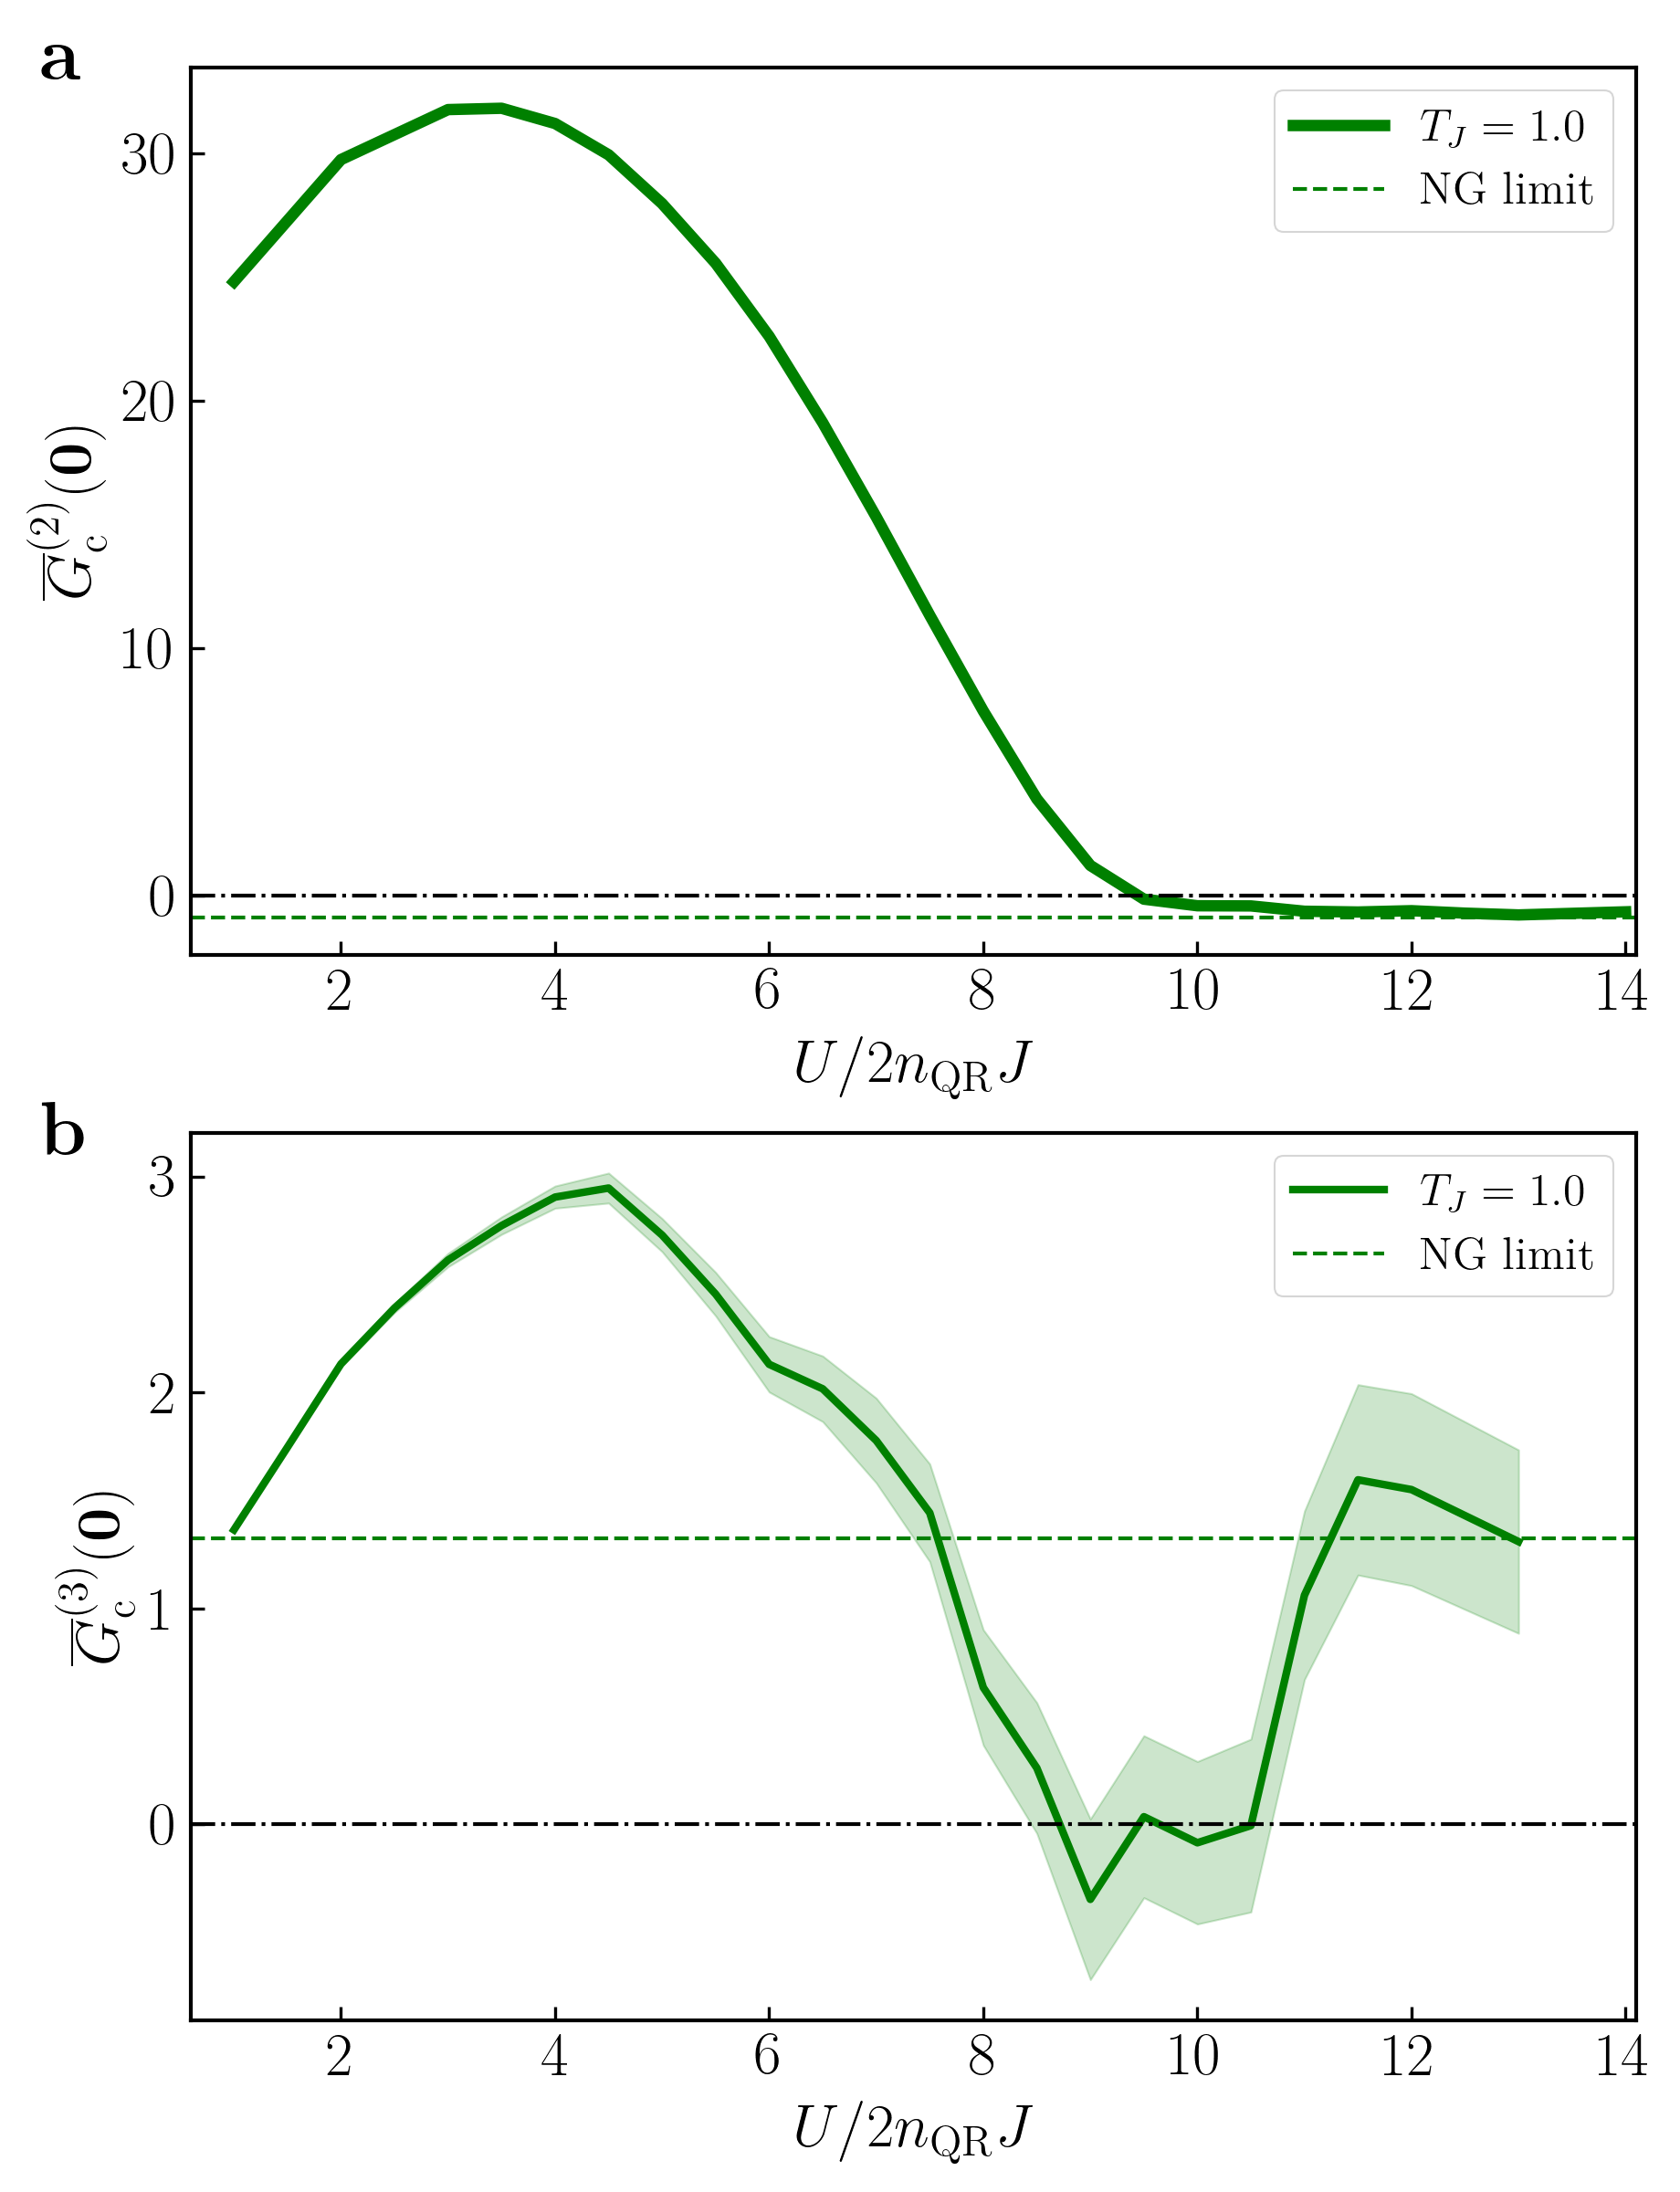

In [25]:
fig = plt.figure(figsize=[fig_width,2*fig_height])

ax1=plt.subplot(2, 1, 1)

ax1.text(-.8,33,r'\textbf{a}',fontsize=20)

ax1.plot(U_2nJ_0p2,G2c_QR_1p0_notNorm,linewidth=3, color='green',label=r'$T_J=1.0$')
ax1.axhline(y=-868/999,linestyle='--',color="green",label='NG limit')
ax1.axhline(y=0,linestyle='-.',color="black")

ax1.set_xlim(.6,14.1)
#ax1.set_ylim(-.5,9)
ax1.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm 0)$")#,fontsize = 24)
ax1.set_xlabel(r'$U/2n_{\rm QR}J$')
ax1.legend(fontsize="12")

ax2=plt.subplot(2, 1, 2)

ax2.text(-.8,3.1,r'\textbf{b}',fontsize=20)


ax2.plot(U_2nJ_G3,G3c_QR_1p0_size6,label=r'$T_J=1.0$',linewidth=2,color='green')
ax2.fill_between(U_2nJ_G3,G3c_QR_1p0_size6-errG3c_QR_1p0_size6,G3c_QR_1p0_size6+errG3c_QR_1p0_size6,color='green',alpha=.2)
ax2.axhline(y=1.326,linestyle='--',color="green",label='NG limit')
ax2.axhline(y=0,linestyle='-.',color="black")

ax2.legend(fontsize="12",)#loc='center left')
ax2.set_xlim(0.6,14.1)
#plt.ylim(-0.1,.5)
#ax2.semilogy()
ax2.set_ylabel(r"$\overline{G}_{\rm c}^{(3)}( \bm 0)$")#,fontsize = 24)
ax2.set_xlabel(r'$U/2n_{\rm QR}J$')
#ax2.axvline(x=5,linestyle='--',color="green")
#ax2.axvline(x=6.,linestyle='--',color='black')


plt.savefig('figure3-SuppMat.pdf', dpi=300,bbox_inches='tight')
plt.show()


/var/folders/33/dnxtnbgs4x9bd02xgsmd58v80000gp/T/ipykernel_19889/3108159053.py:17: RuntimeWarning: invalid value encountered in power
  plt.plot(UsuJscale,(1-UsuJscale/26)**(2*0.3485), linestyle='dashed', color='green',linewidth=2)


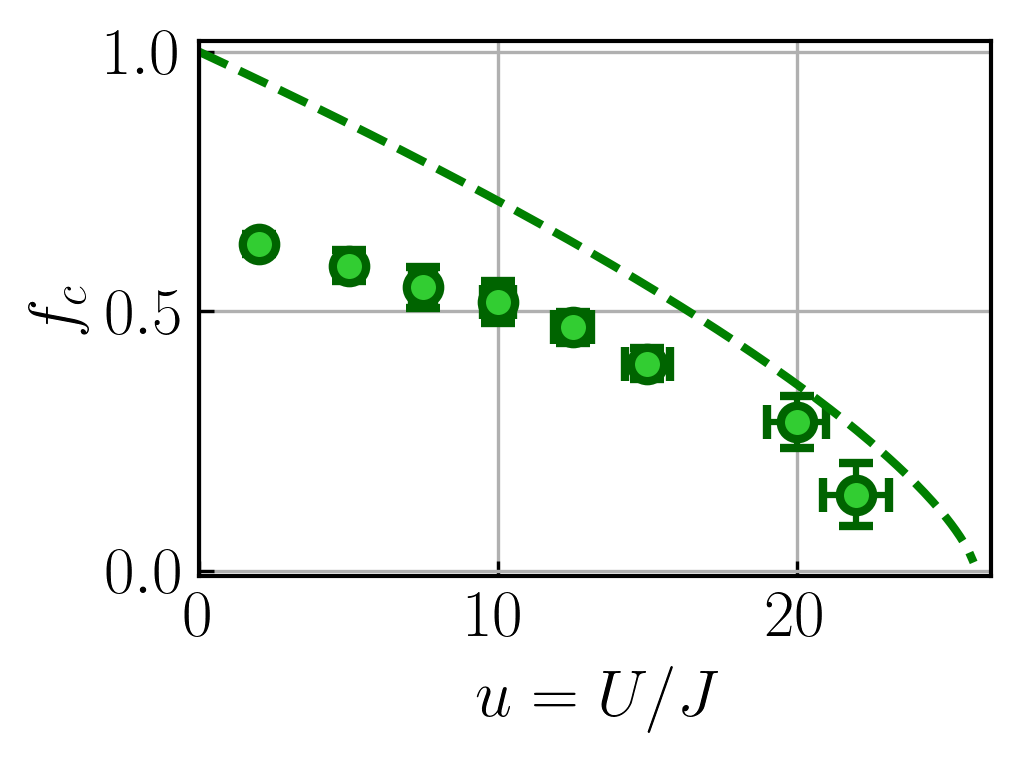

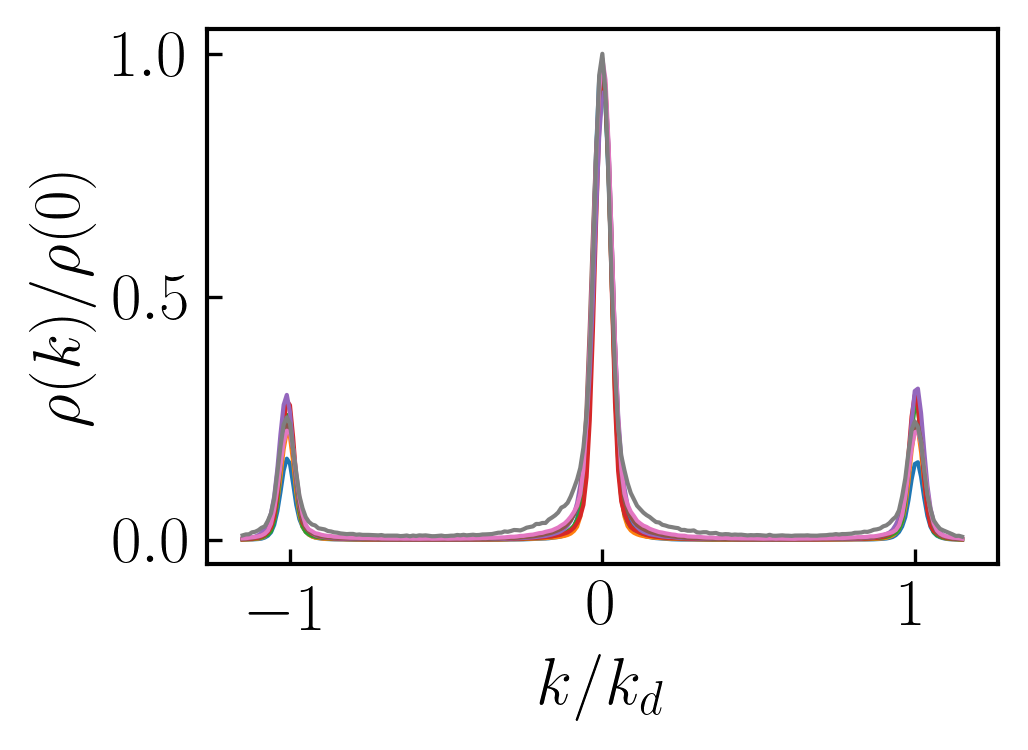

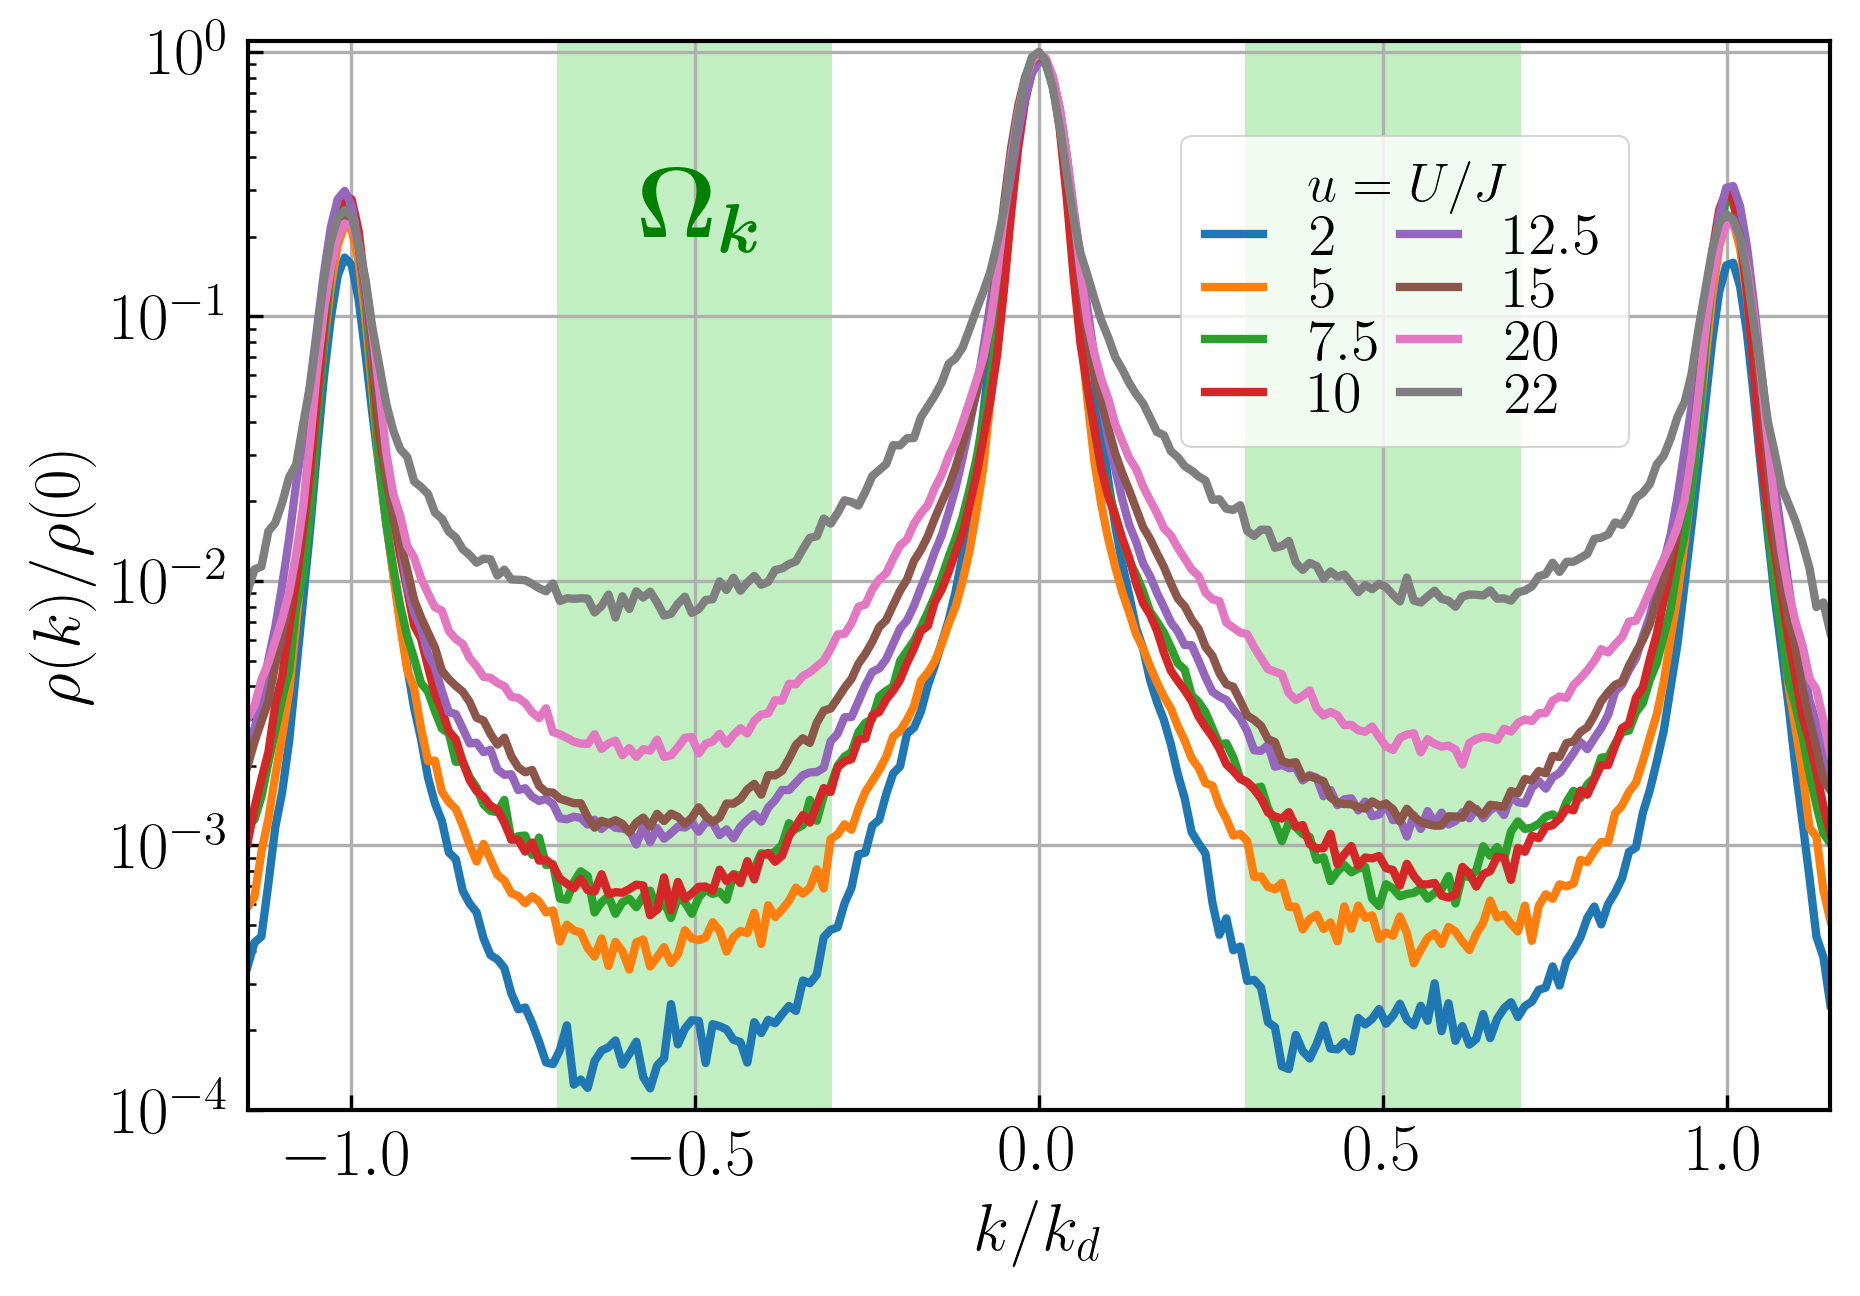

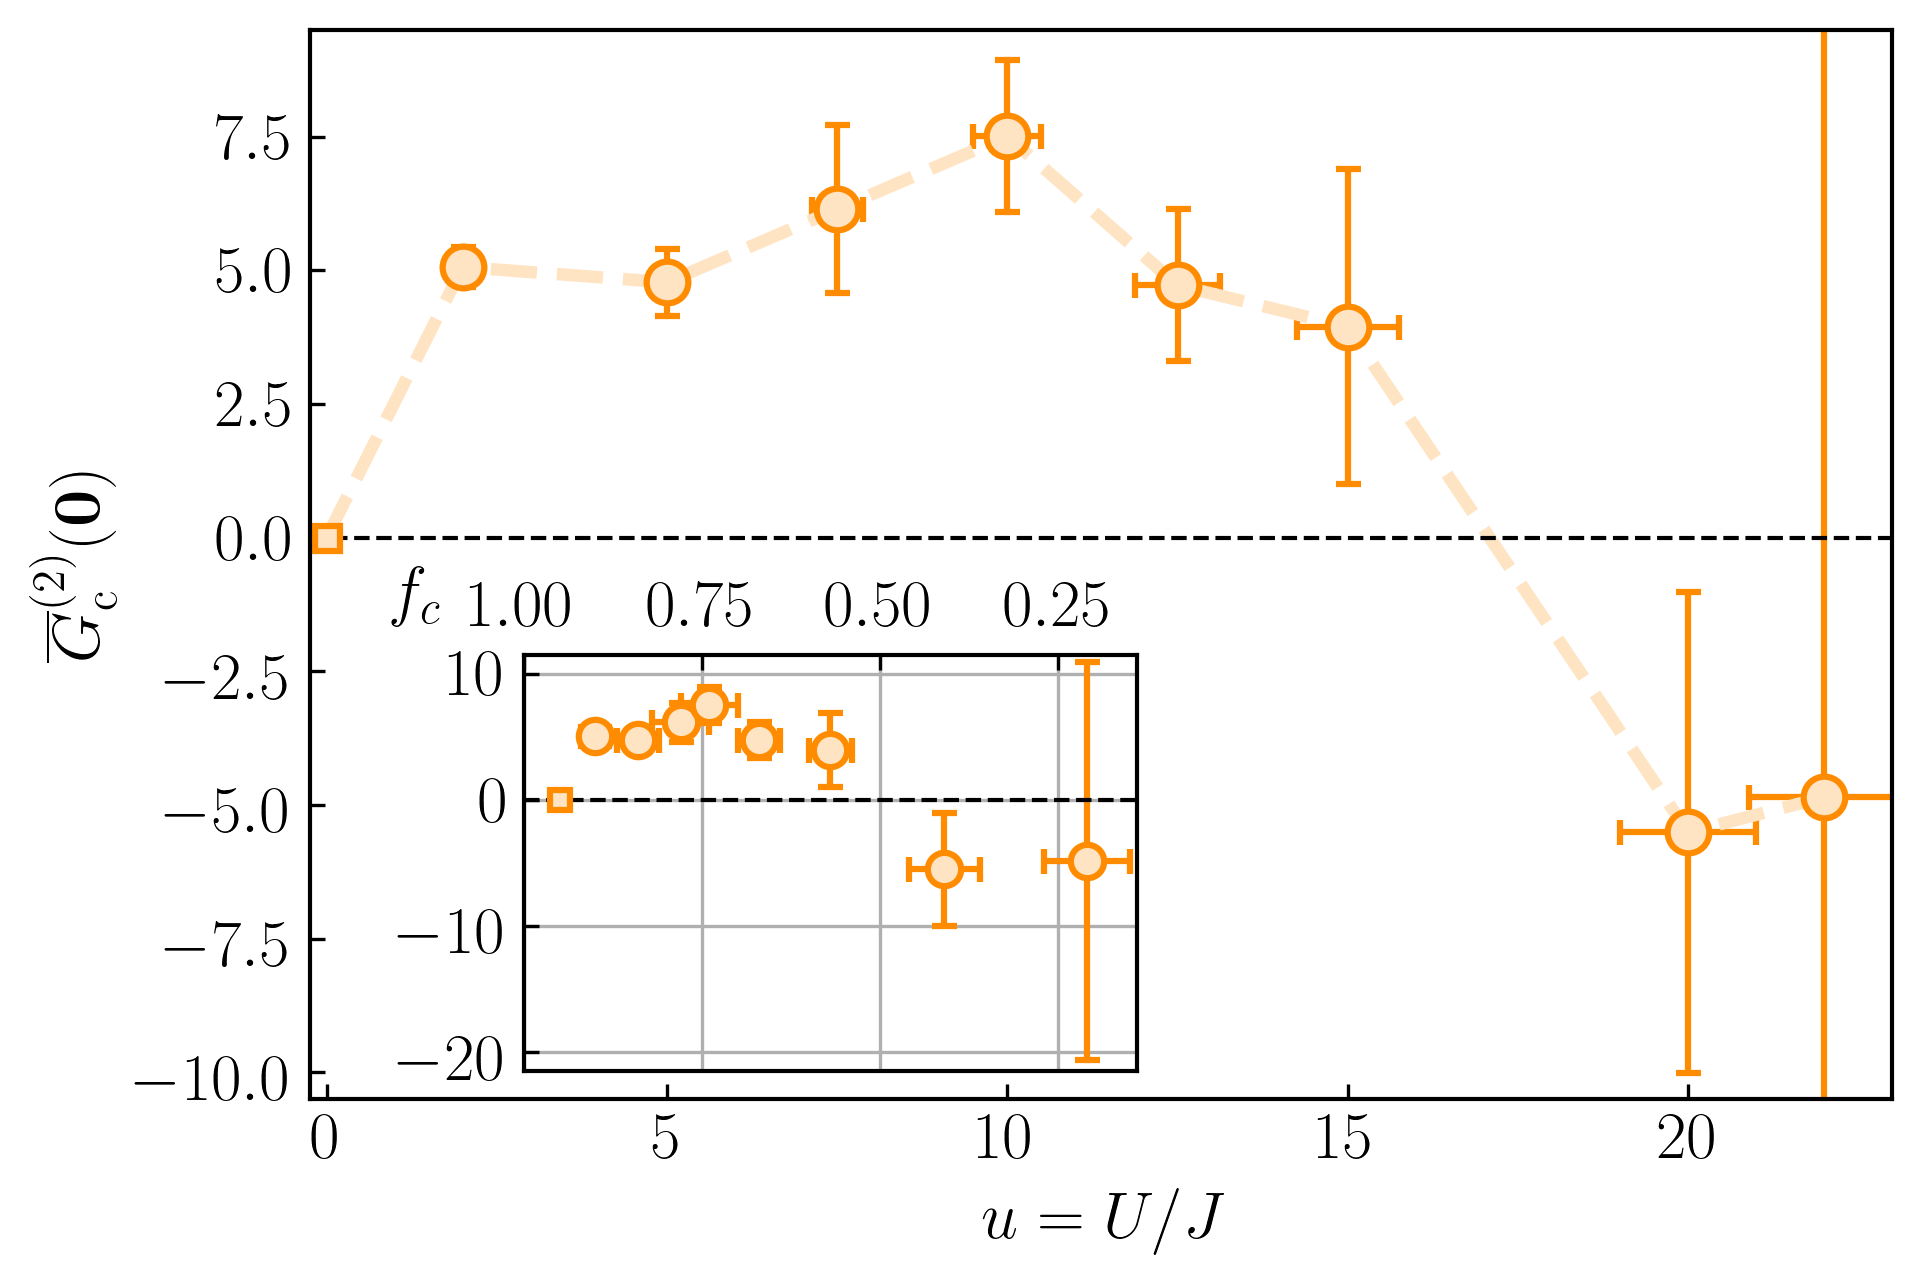

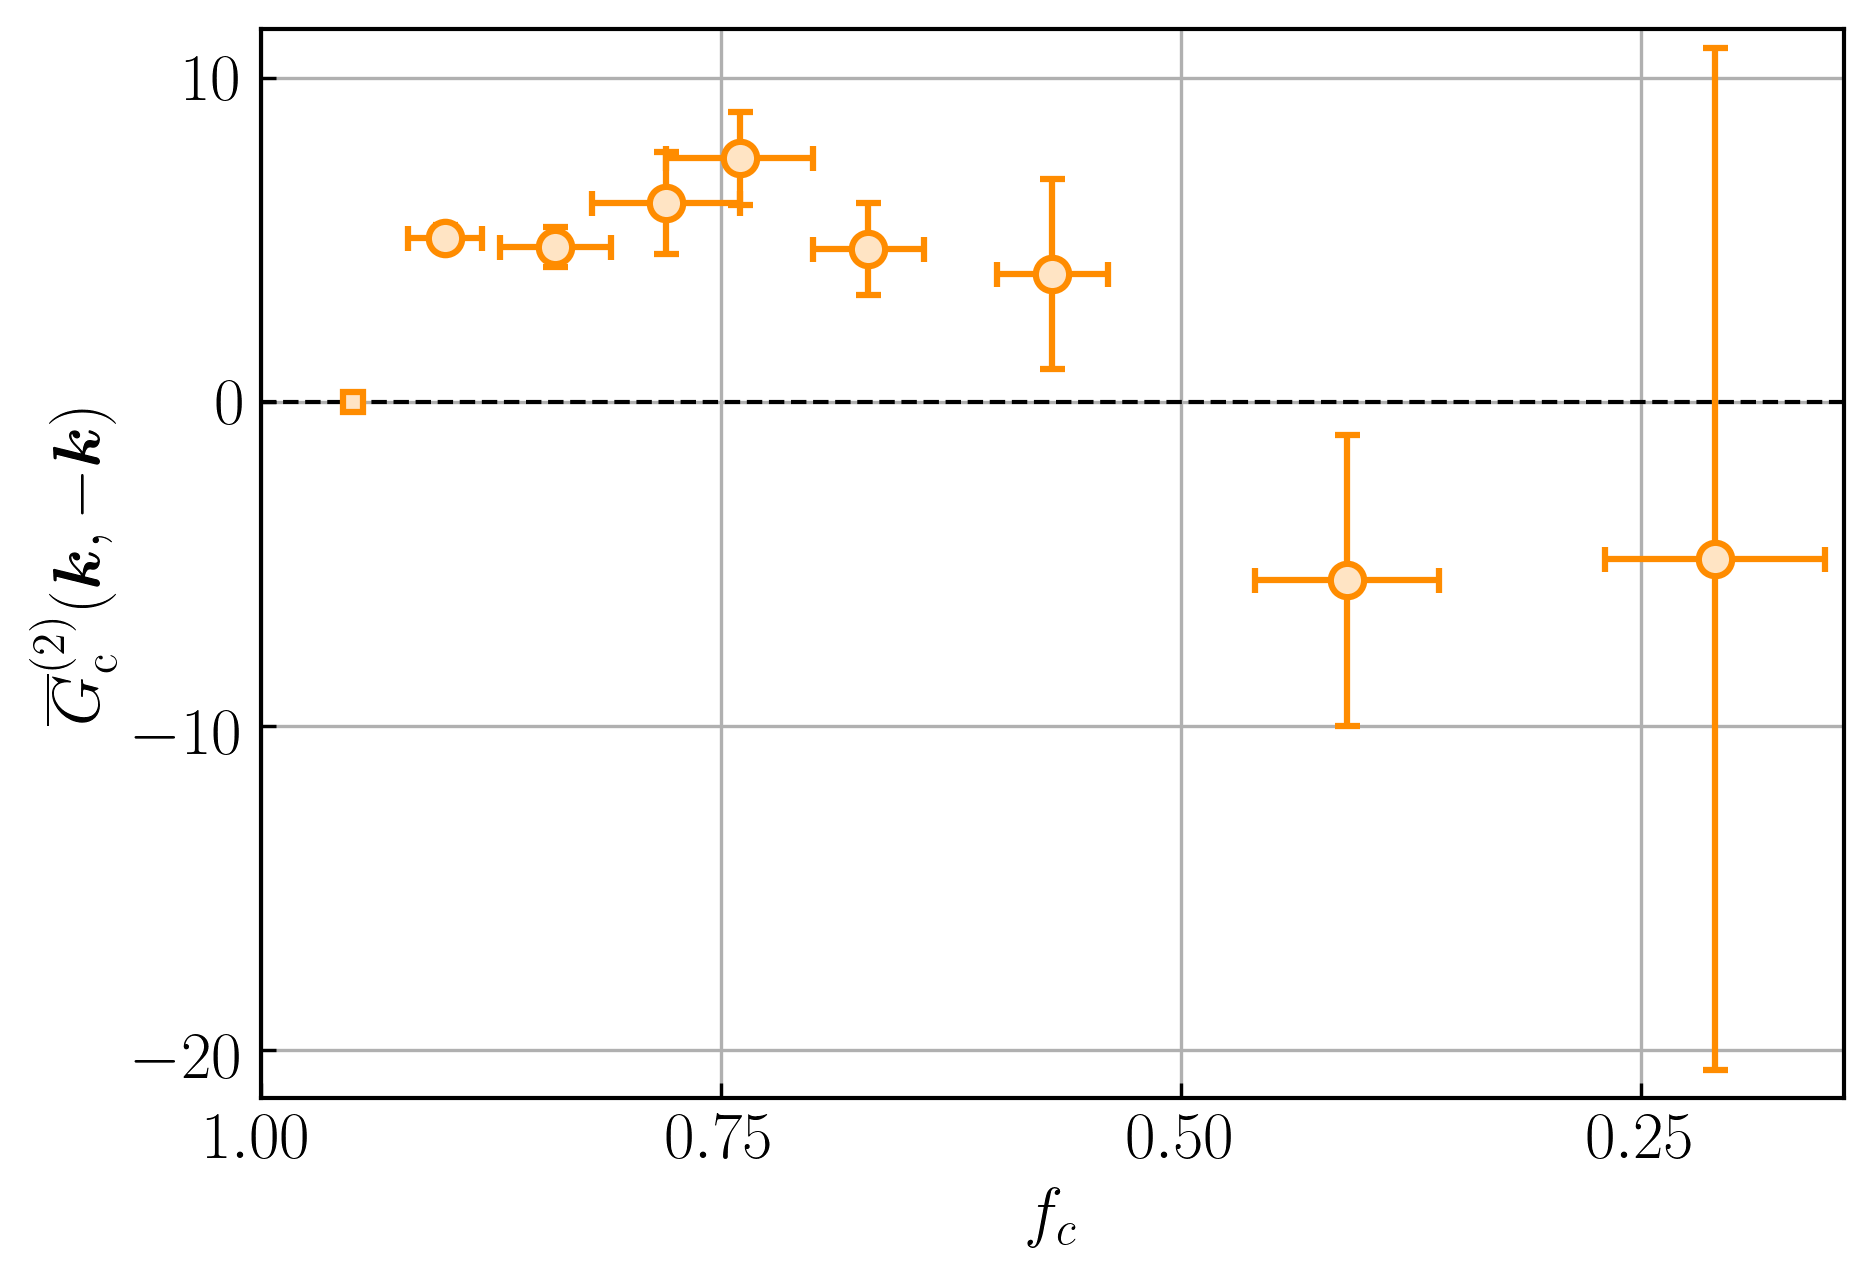

In [32]:

####################################################################################

fig=plt.figure(figsize=[fig_width*0.5,fig_height*0.5])

plt.errorbar(U_J_fc[1:9],0.7*fc_corr[1:9],yerr=err_fc_corr[1:9],xerr=U_J[1:9]*0.05,
        marker='o',markersize=8,capsize=4.0,elinewidth=1.5,capthick=1.5,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='limegreen',
        markeredgewidth=2.0,lw=2
            )


UsuJscale=np.linspace(0,30,200)
#plt.plot(U_J_fc[1:9],fc_corr[1:9], linestyle='dashed', color='limegreen',linewidth=2)
plt.plot(UsuJscale,(1-UsuJscale/26)**(2*0.3485), linestyle='dashed', color='green',linewidth=2)

#ax2.plot(U_J_fc[1:9],fc_corr[1:9], linestyle='dashed', color='limegreen',linewidth=2)
plt.grid()
#plt.xaxis.set_ticks(np.arange(0, 26, 5))
#plt.yaxis.set_ticks(np.arange(0, 1.1, 0.5))
plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.ylim(-0.01,1.02)
plt.xlim(0,26.5)

plt.xlabel('$u=U/J$')
plt.ylabel(r'$f_c$')
plt.show()

####################################################################################
fig=plt.figure(figsize=[fig_width*0.5,fig_height*0.5])

plt.plot(bin_centers,rho_k_2p0)
plt.plot(bin_centers,rho_k_5p0)
plt.plot(bin_centers,rho_k_7p5)
plt.plot(bin_centers,rho_k_10p0)
plt.plot(bin_centers,rho_k_12p5)
plt.plot(bin_centers,rho_k_15p0)
plt.plot(bin_centers,rho_k_20p0)
plt.plot(bin_centers,rho_k_22p0)

plt.xlabel(r'$k/k_d$')
plt.ylabel(r'$\rho(k)/\rho(0)$')

plt.show()

####################################################################################
fig, ax=plt.subplots(figsize=[fig_width,fig_height])

plt.plot(bin_centers,rho_k_2p0,linewidth=2,label=r'$2$')
plt.plot(bin_centers,rho_k_5p0,linewidth=2,label=r'$5$')
plt.plot(bin_centers,rho_k_7p5,linewidth=2,label=r'$7.5$')
plt.plot(bin_centers,rho_k_10p0,linewidth=2,label=r'$10$')
plt.plot(bin_centers,rho_k_12p5,linewidth=2,label=r'$12.5$')
plt.plot(bin_centers,rho_k_15p0,linewidth=2,label=r'$15$')
plt.plot(bin_centers,rho_k_20p0,linewidth=2,label=r'$20$')
plt.plot(bin_centers,rho_k_22p0,linewidth=2,label=r'$22$')
plt.semilogy()
plt.legend(loc=(0.59,0.62),ncols=2,handlelength=1,labelspacing=0.01,fontsize=14,
           title=r'$u=U/J$',title_fontsize=13,columnspacing=0.3)
plt.grid()
plt.xlabel(r'$k/k_d$')
plt.ylabel(r'$\rho(k)/\rho(0)$')

rect = patches.Rectangle((-0.7,1e-5),(0.7-0.3),2,linewidth=0,edgecolor='b',facecolor='limegreen',alpha=0.3)
ax.add_patch(rect)

rect = patches.Rectangle((0.3,1e-5),(0.7-0.3),2,linewidth=0,edgecolor='b',facecolor='limegreen',alpha=0.3)
ax.add_patch(rect)
ax.text(-0.58,0.2,r'$\bm{\Omega_k}$',color='green',fontsize=24,fontweight='bold')

plt.ylim(1e-4,1.1)
plt.xlim(-1.15,1.15)

plt.show()

####################################################################################
fig, ax1=plt.subplots(figsize=[fig_width,fig_height])


ax1.errorbar(U_J[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,xerr=U_J[1:9]*0.05,
             marker='o',markersize=10,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
U_J_line=np.concatenate(([0],U_J[1:9]),axis=None)
G2c_line=np.concatenate(([0],G2c_0p18kd),axis=None)

ax1.plot(U_J_line,G2c_line,
             linestyle='--',linewidth=3,
             color='bisque',
            )

ax1.errorbar([0],[0],yerr=0,
             marker='s',markersize=6,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )

ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm 0)$")
ax1.set_xlabel('$u=U/J$')
#plt.grid()
ax1.set_ylim(-10.5,9.5)
ax1.set_xlim(-0.25,23)


# this is an inset axes over the main axes
ax1ins = plt.axes([.23, .13, .3, .3])
#ax1ins.set_xlabel('$f_c$')
#ax1ins.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm K= \bm 0)$")
#ax1.set_ylabel('$$')
plt.grid(True)
ax1ins.set_xlim(max(fc_corr[1:9])+0.05, min(fc_corr[1:9])-0.05)
ax1ins.errorbar(fc_corr[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,xerr=err_fc_corr[1:9],
             marker='o',markersize=8,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.errorbar([0.95],[0],yerr=0,
             marker='s',markersize=5,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.axhline(y=0, color='black', linestyle='--')

fc_line=np.concatenate(([0.95],fc_corr[1:9]),axis=None)
#ax1ins.plot(fc_line,G2c_line,
#             linestyle='--',linewidth=3,
#             color='bisque')
ax1ins.yaxis.set_ticks(np.arange(-20, 15, 10))

ax1.text(0.95,-1.42,r'$f_c$ ')

ax1ins.xaxis.tick_top()
ax1ins.set_xticks([1,0.75,0.5,0.25 ]) 
ax1ins.xaxis.set_label_position('top') 
ax1ins.set_ylim(-21.5,11.5)
ax1ins.set_xlim(1.0,0.14)

plt.show()


####################################################################################
fig, ax1ins=plt.subplots(figsize=[fig_width,fig_height])

#ax1ins.set_xlabel('$f_c$')
#ax1ins.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}(\bm K= \bm 0)$")
#ax1.set_ylabel('$$')
plt.grid(True)
ax1ins.set_xlim(max(fc_corr[1:9])+0.05, min(fc_corr[1:9])-0.05)
ax1ins.errorbar(fc_corr[1:9],G2c_0p18kd,yerr=err_G2c_0p18kd,xerr=err_fc_corr[1:9],
             marker='o',markersize=8,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.errorbar([0.95],[0],yerr=0,
             marker='s',markersize=5,capsize=3,elinewidth=1.5,capthick=1.5,markeredgewidth=1.5,
             linestyle='none',
             color='darkorange',
             markeredgecolor='darkorange',
             markerfacecolor='bisque',
            )
ax1ins.axhline(y=0, color='black', linestyle='--')

fc_line=np.concatenate(([0.95],fc_corr[1:9]),axis=None)
#ax1ins.plot(fc_line,G2c_line,
#             linestyle='--',linewidth=3,
#             color='bisque')
ax1ins.yaxis.set_ticks(np.arange(-20, 15, 10))

ax1ins.set_xticks([1,0.75,0.5,0.25 ]) 
ax1ins.set_ylim(-21.5,11.5)
ax1ins.set_xlim(1.0,0.14)

ax1ins.set_ylabel(r"$\overline{G}_{\rm c}^{(2)}({\bm k}, -{\bm k})$")
ax1ins.set_xlabel('$f_c$')

plt.savefig('figure-Maxime.pdf', dpi=300,bbox_inches='tight')


## Bunching and anomalous amplitudes

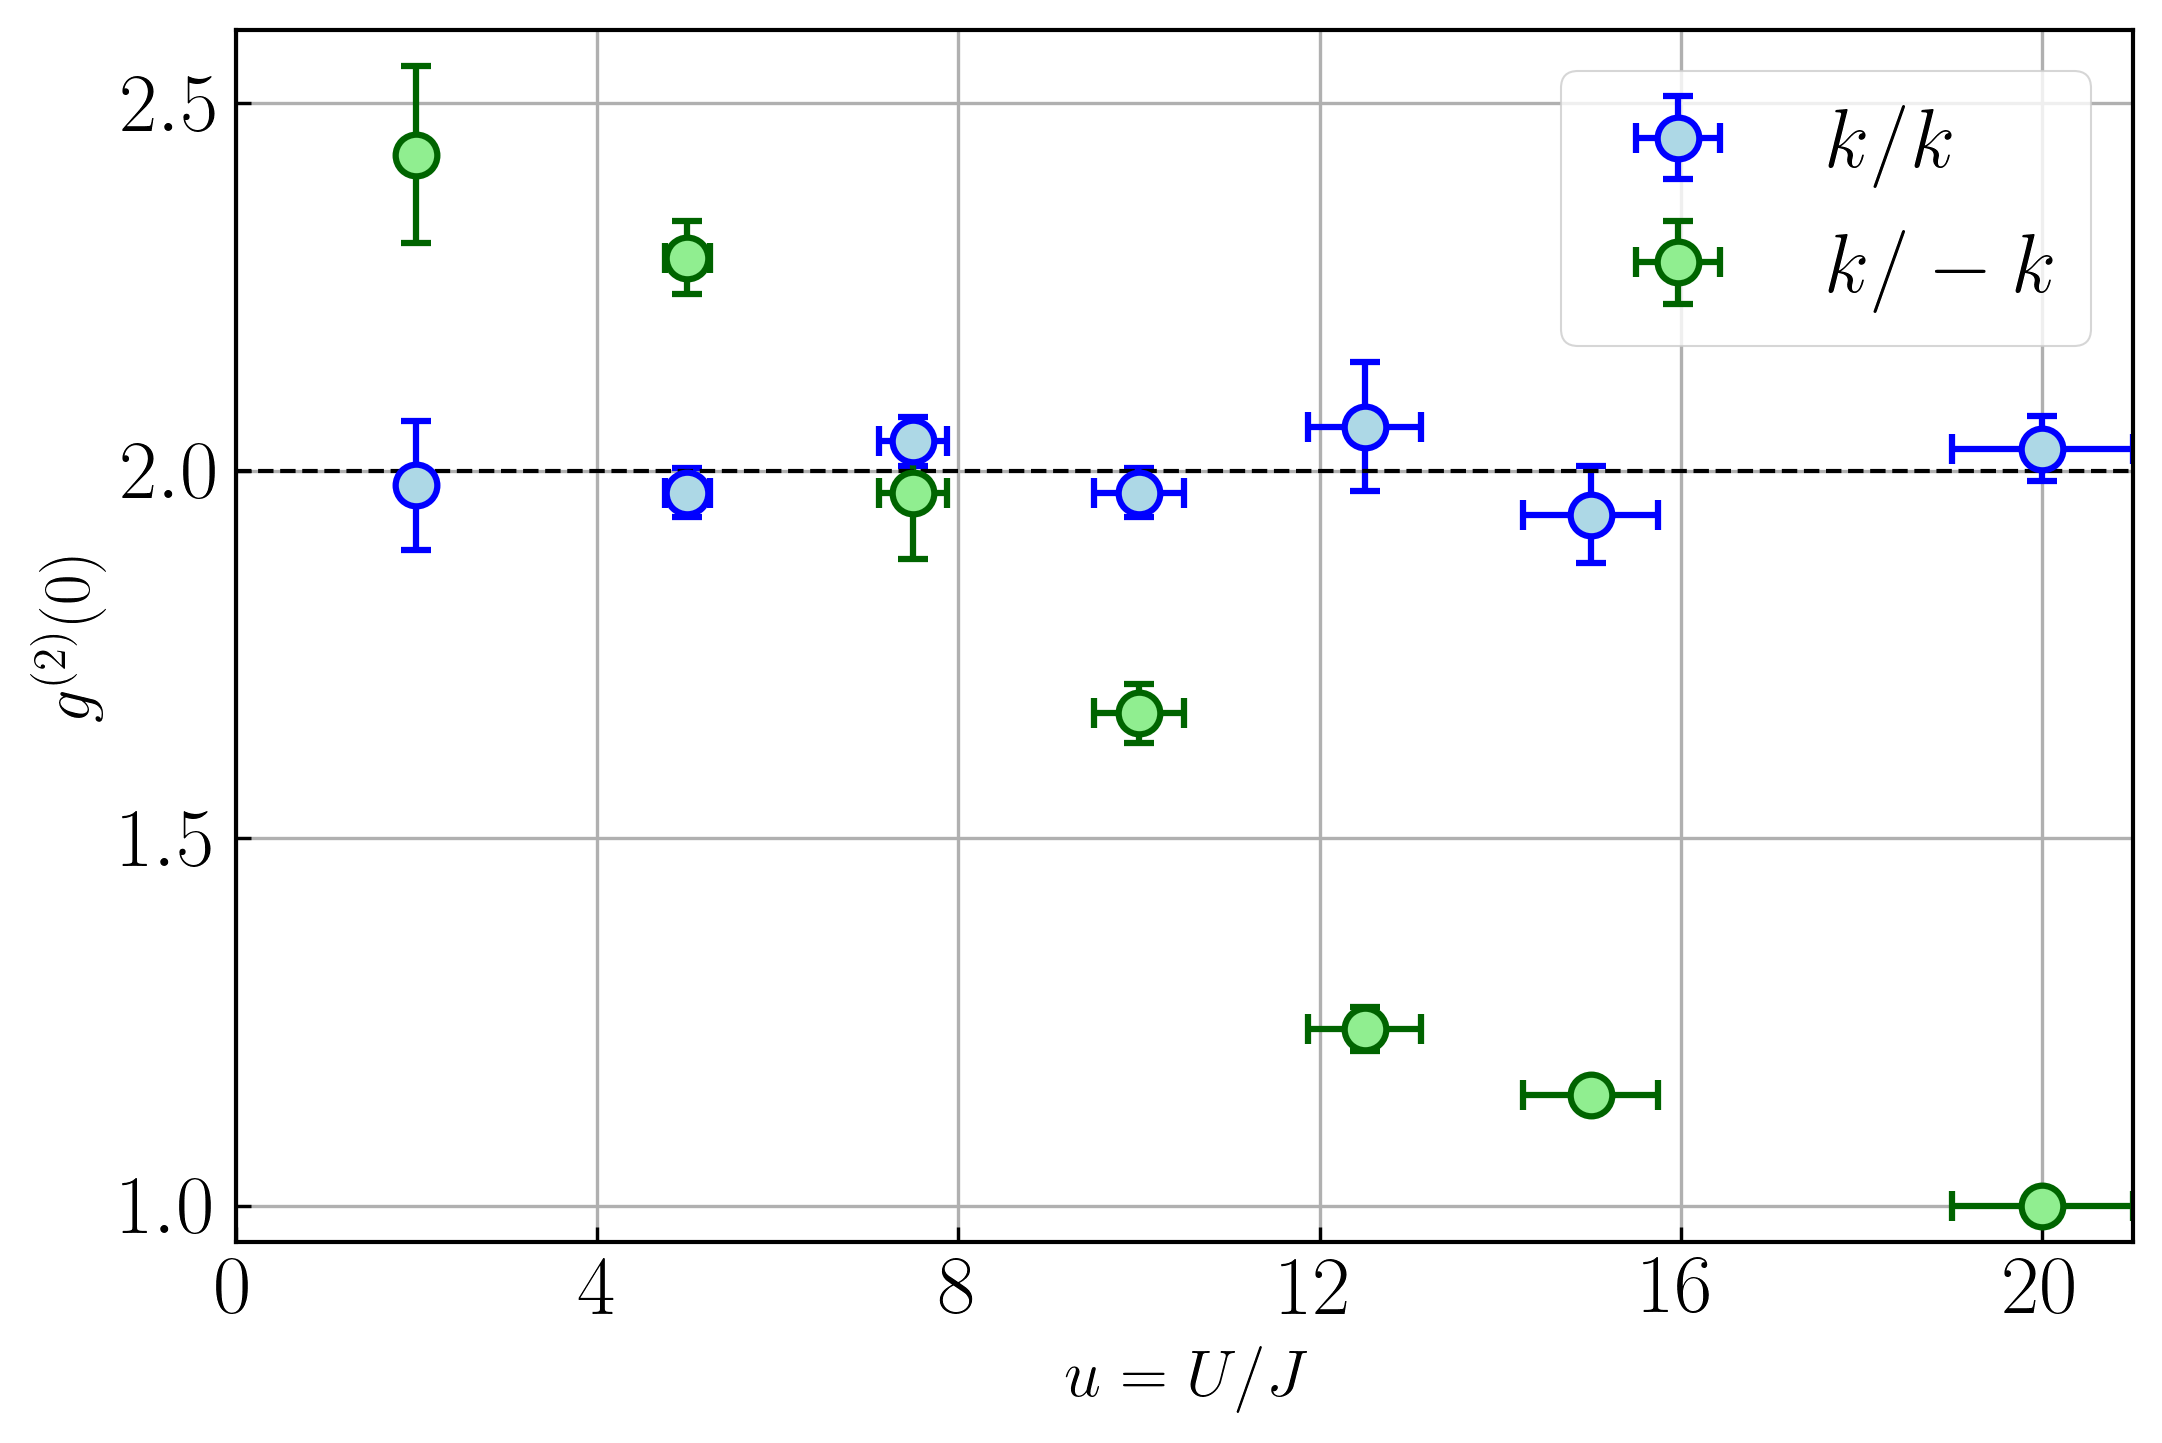

0.049999999999999996

In [29]:
fig,ax=plt.subplots(1,1,figsize=[1.1*fig_width,1.1*fig_height])

#plt.hlines(y=1, xmin=0, xmax=25, linewidth=1.5, linestyle='dashed', color='black')

plt.errorbar(U_J[1:8],1+amp_local_v5[0:7],yerr=1.1*err_amp_local_v5[0:7],xerr=U_J[1:8]*0.05,#xerr=err_fc_corr[1:8],
        marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5,
        linestyle='none',
        color='blue',
        markeredgecolor='blue',
        markerfacecolor='lightblue',
        markeredgewidth=1.5,lw=1.5,
        label=r'$k/k$'#label='$g^{(2)}_{N}(0)$'
        )

plt.errorbar(U_J[1:8],1+amp_kmk_bare[1:8],yerr=err_amp_kmk_bare[1:8],xerr=U_J[1:8]*0.05,#xerr=err_fc_corr[1:8],
        marker='o',markersize=10,capsize=3.5,elinewidth=1.5,capthick=1.5,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='lightgreen',
        markeredgewidth=1.5,lw=1.5,
        label=r'$k/-k$'#label='$g^{(2)}_{A}(0)$'
        )

plt.axhline(y=2, color='black', linestyle='--')
#plt.axhline(y=1, color='black', linestyle='-')
#plt.grid()
plt.legend(fontsize=20)
ax.xaxis.set_ticks(np.arange(0, 22, 4))
#ax.yaxis.set_ticks(np.arange(1.8, 2.2, 0.1))
ax.yaxis.set_ticks(np.arange(0, 2.7, 0.5))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.grid()
#plt.ylim(1.8,2.2)
plt.ylim(0.95,2.6)
plt.xlim(0.0,21)#plt.xlim(0.05,0.65)

plt.xlabel('$u=U/J$')#, fontsize = 24)
plt.ylabel('$g^{(2)}(0)$')#, fontsize = 24)

plt.tight_layout()
plt.savefig('Fig-g2-amplitudes.pdf', dpi=300,bbox_inches='tight')
plt.show()

(err_amp_local_v5[0]+err_amp_local_v5[1]+err_amp_local_v5[2]+err_amp_local_v5[3]+err_amp_local_v5[4]+err_amp_local_v5[5]+err_amp_local_v5[6])/7

## All widths

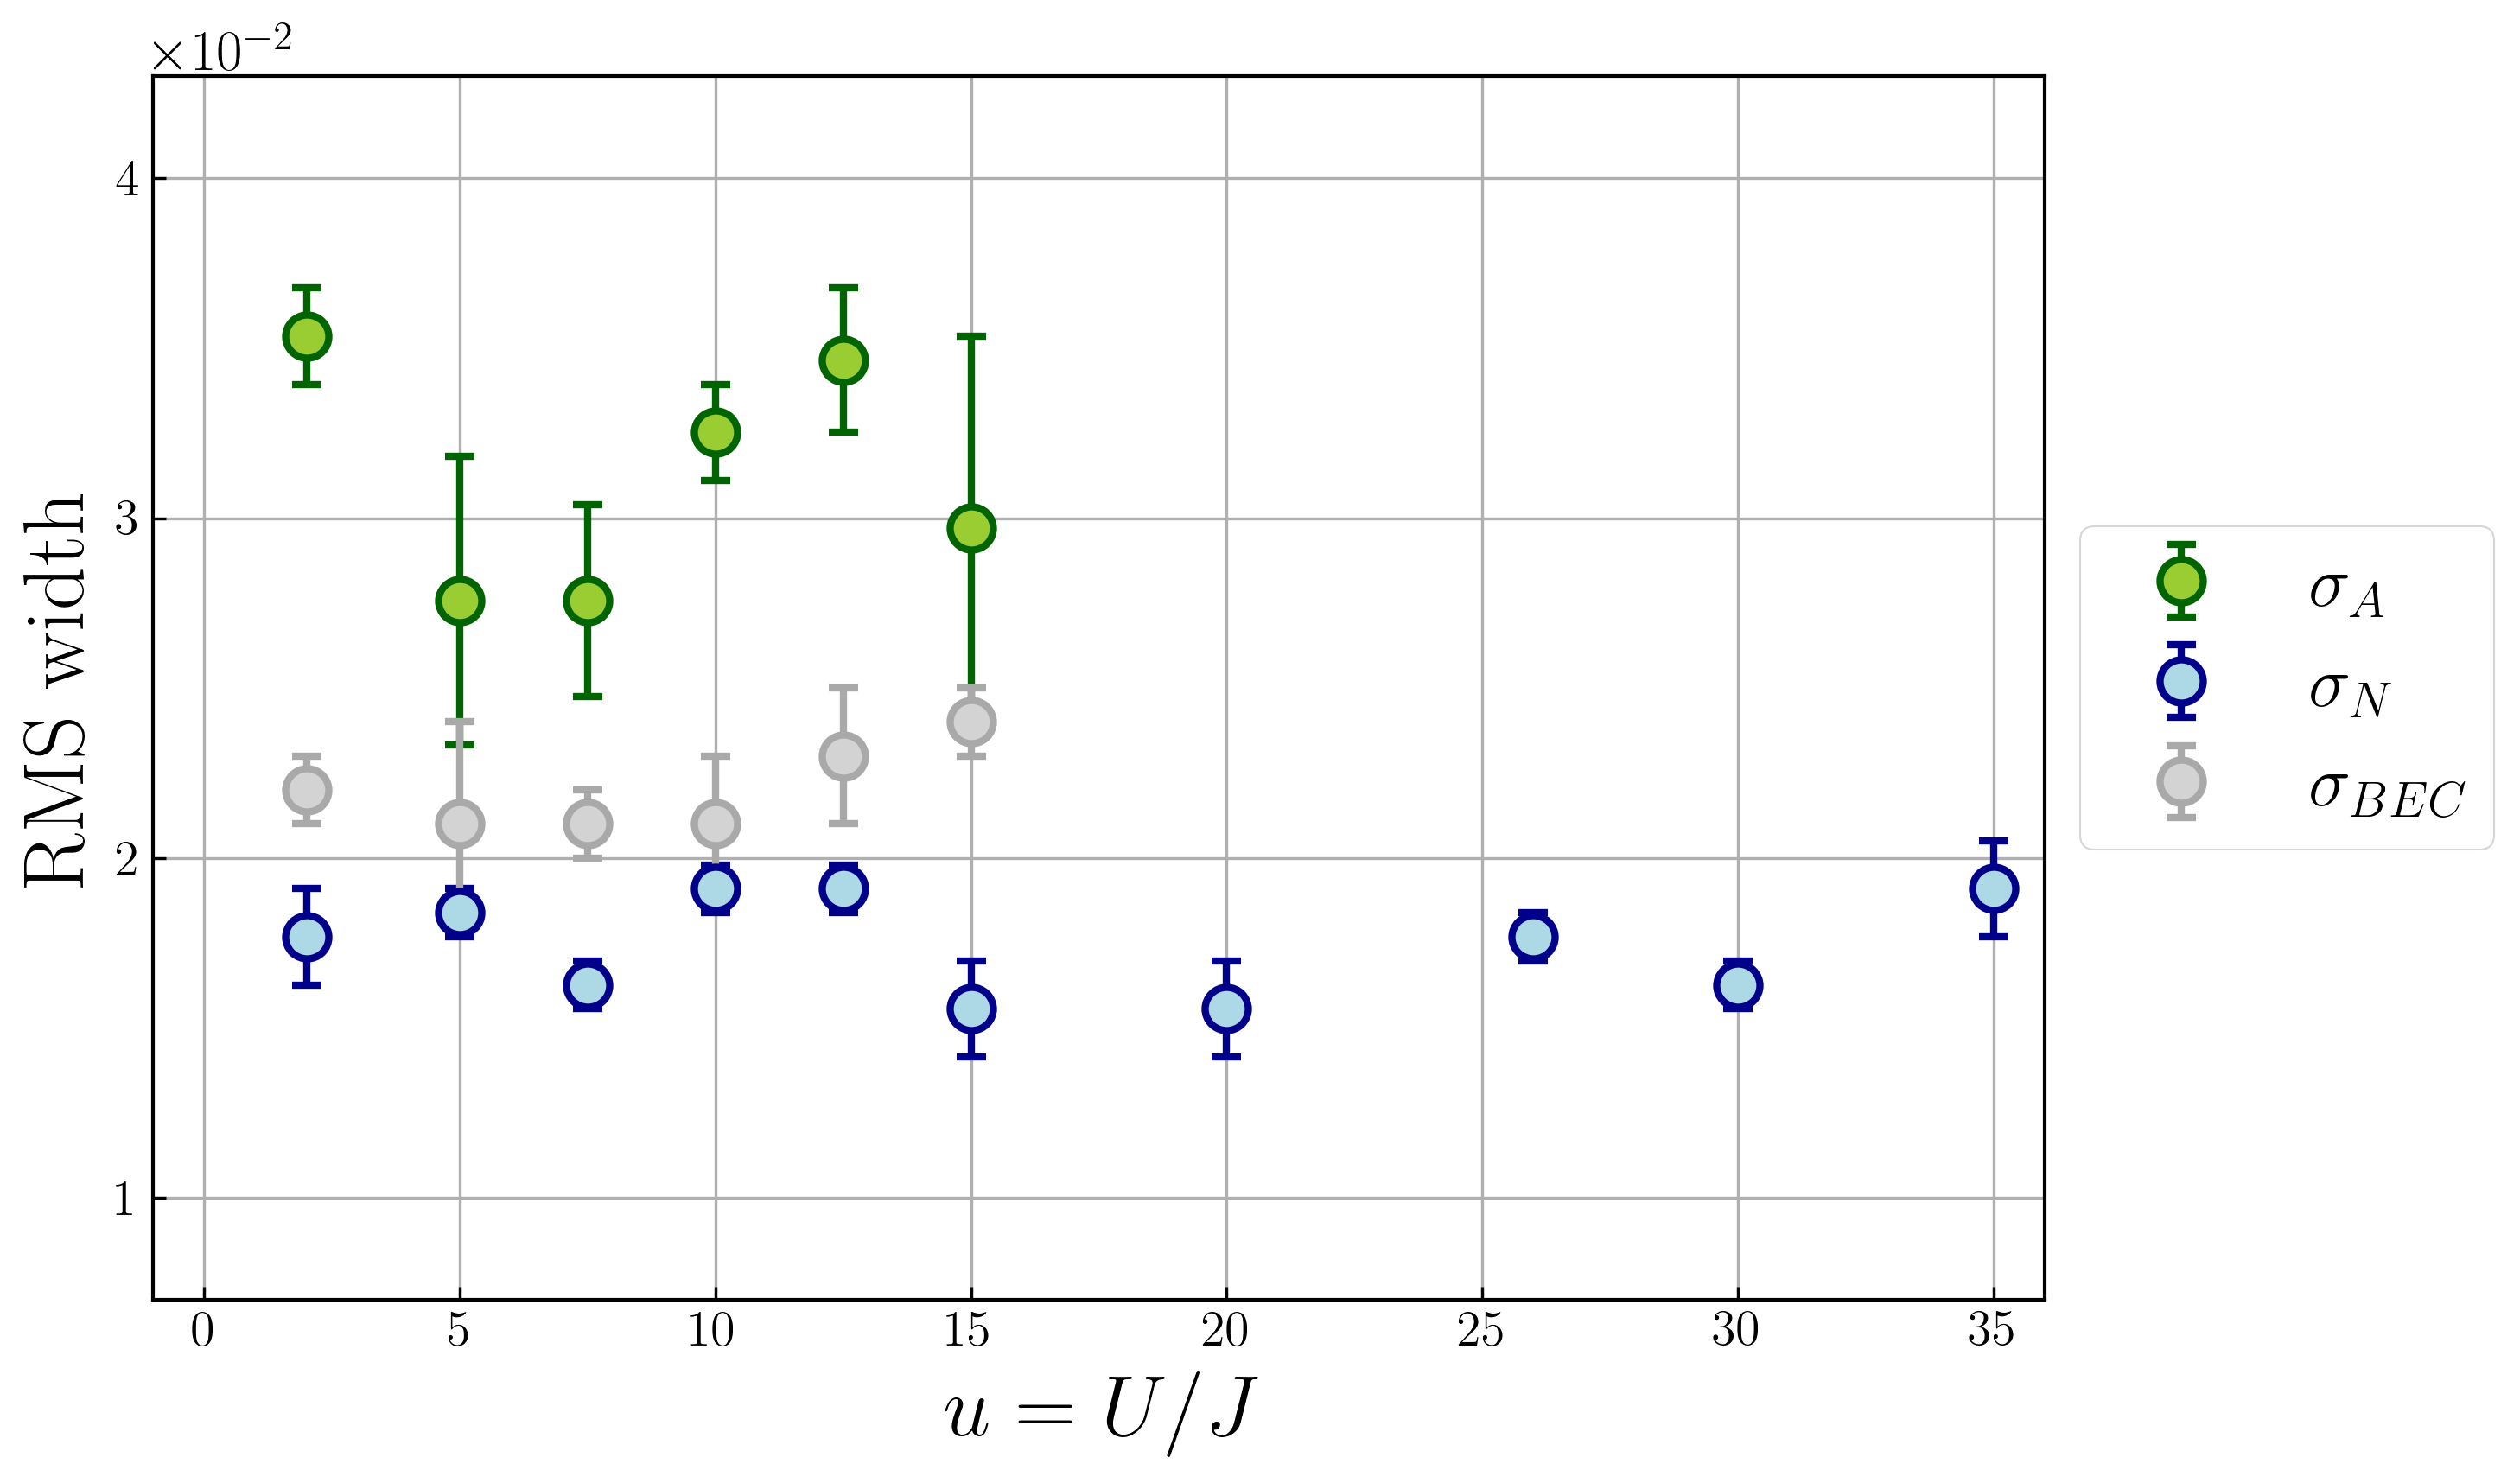

In [30]:
f, ax = plt.subplots(figsize=(10,6)) # set the size that you'd like (width, height)

plt.errorbar(U_J_lc,lc_kmk/np.sqrt(2),yerr=err_lc_kmk/np.sqrt(2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='yellowgreen',
        markeredgewidth=2.0,lw=2,
        label='$\sigma_A$'
        )

plt.errorbar(U_J_local_v5,lc_local_v5/np.sqrt(2),yerr=err_lc_local_v5/np.sqrt(2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkblue',
        markeredgecolor='darkblue',
        markerfacecolor='lightblue',
        markeredgewidth=2.0,lw=2,
        label='$\sigma_N$'
        )

plt.errorbar(U_J_BEC,sigma_BEC,yerr=err_sigma_BEC,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgrey',
        markeredgecolor='darkgrey',
        markerfacecolor='lightgrey',
        markeredgewidth=2.0,lw=2,
        label='$\sigma_{BEC}$'
        )

plt.grid()
ax.xaxis.set_ticks(np.arange(0, 36, 5))
ax.yaxis.set_ticks(np.arange(0.010, 0.043, 0.010))
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
plt.xlim([-1,36])
plt.ylim([0.007,0.043])

plt.xlabel('$u=U/J$', fontsize = 24)
plt.ylabel('RMS width', fontsize = 24)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 20)
plt.tight_layout()

## TEST : Bunching width

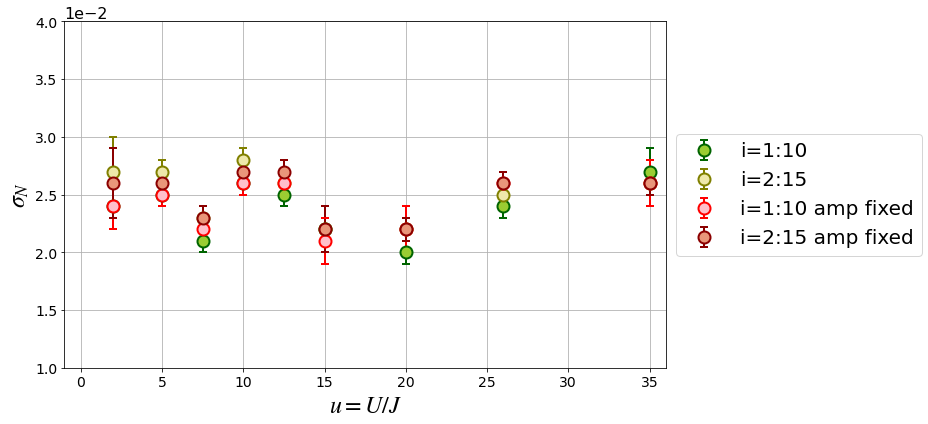

In [5]:
f, ax = plt.subplots(figsize=(13,6)) # set the size that you'd like (width, height)

plt.errorbar(U_J_local,lc_local,yerr=err_lc_local,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='yellowgreen',
        markeredgewidth=2.0,lw=2,
        label='i=1:10'
        )

plt.errorbar(U_J_local,lc_local_v2,yerr=err_lc_local_v2,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='olive',
        markeredgecolor='olive',
        markerfacecolor='palegoldenrod',
        markeredgewidth=2.0,lw=2,
        label='i=2:15'
        )

plt.errorbar(U_J_local,lc_local_v3,yerr=err_lc_local_v3,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='red',
        markeredgecolor='red',
        markerfacecolor='pink',
        markeredgewidth=2.0,lw=2,
        label='i=1:10 amp fixed'
        )

plt.errorbar(U_J_local,lc_local_v4,yerr=err_lc_local_v4,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkred',
        markeredgecolor='darkred',
        markerfacecolor='darksalmon',
        markeredgewidth=2.0,lw=2,
        label='i=2:15 amp fixed'
        )

plt.grid()
ax.xaxis.set_ticks(np.arange(0, 36, 5))
ax.yaxis.set_ticks(np.arange(0.005, 0.045, 0.005))
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
plt.xlim([-1,36])
plt.ylim([0.010,0.040])

plt.xlabel('$u=U/J$', fontsize = 24)
plt.ylabel(r"$\sigma_N$", fontsize = 24)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 20)
plt.tight_layout()

## TEST : Bunching amplitude

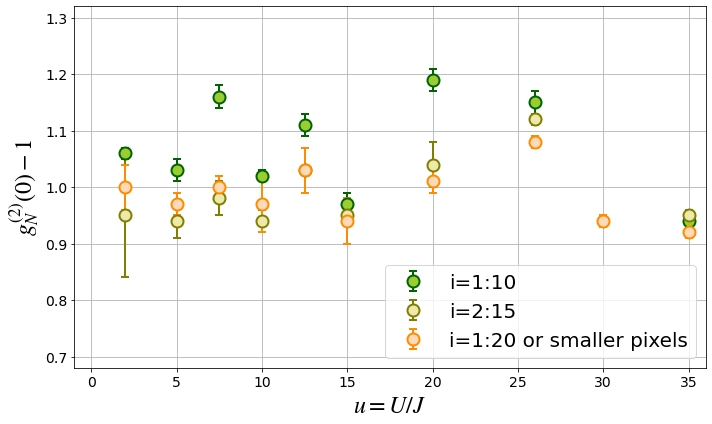

In [6]:
f, ax = plt.subplots(figsize=(10,6)) # set the size that you'd like (width, height)

plt.errorbar(U_J_local,amp_local,yerr=err_amp_local,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='yellowgreen',
        markeredgewidth=2.0,lw=2,
        label='i=1:10' 
        )

plt.errorbar(U_J_local,amp_local_v2,yerr=err_amp_local_v2,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='olive',
        markeredgecolor='olive',
        markerfacecolor='palegoldenrod',
        markeredgewidth=2.0,lw=2,
        label='i=2:15'
        )

plt.errorbar(U_J_local_v5,amp_local_v5,yerr=err_amp_local_v5,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkorange',
        markeredgecolor='darkorange',
        markerfacecolor='peachpuff',
        markeredgewidth=2.0,lw=2,
        label='i=1:20 or smaller pixels'
        )

plt.grid()
ax.xaxis.set_ticks(np.arange(0, 36, 5))
ax.yaxis.set_ticks(np.arange(0.7, 1.6, 0.1))
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
plt.xlim([-1,36])
plt.ylim([0.68,1.32])

plt.xlabel('$u=U/J$', fontsize = 24)
plt.ylabel(r"$g^{(2)}_{N}(0) - 1$", fontsize = 24)
plt.legend(fontsize = 20)
plt.tight_layout()

## Number of pairs per atom per shot vs U/J

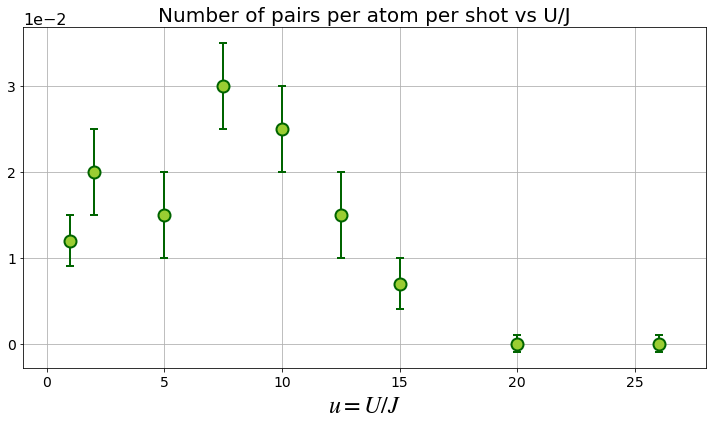

In [7]:
Npairs = np.array([0.012, 0.020, 0.015, 0.030, 0.025, 0.015, 0.007, 0, 0])
err_Npairs = np.array([0.003, 0.005, 0.005, 0.005, 0.005, 0.005, 0.003, 0.001, 0.001]) 

f, ax = plt.subplots(figsize=(10,6)) # set the size that you'd like (width, height)

plt.errorbar(U_J[0:9],Npairs,yerr=err_Npairs,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='yellowgreen',
        markeredgewidth=2.0,lw=2,
        )

plt.grid()
ax.xaxis.set_ticks(np.arange(0, 28, 5))
ax.yaxis.set_ticks(np.arange(0, 3.7*1e-2, 1*1e-2))
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
plt.xlim([-1,28])

plt.xlabel('$u=U/J$', fontsize = 24)
plt.title('Number of pairs per atom per shot vs U/J', fontsize = 20)
plt.tight_layout()
plt.show()


## Amp k/-k times rho_bar vs U/J

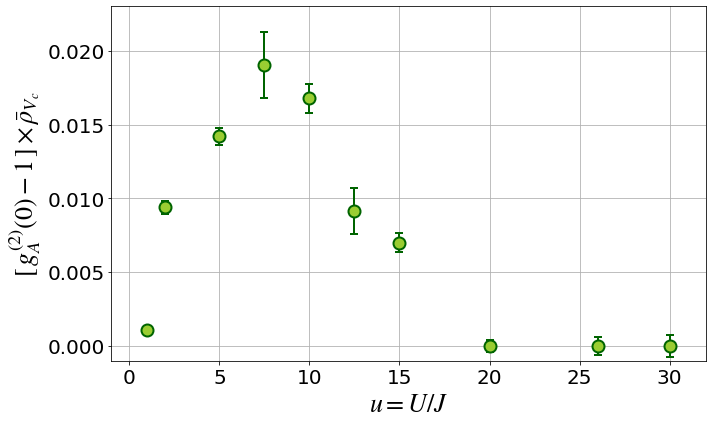

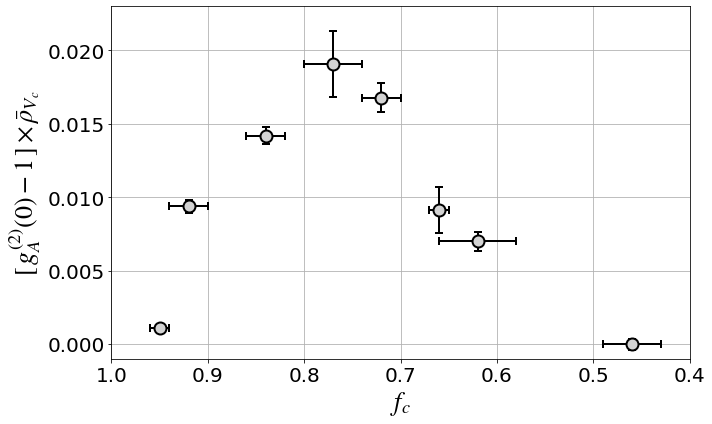

In [49]:
################### Plot amplitude k/-k times the mean density vs U/J #########################

# Bootstrap method except for U/J=5,10,12.5. Merged method for U/J=2,15 (peak too small) and 7,5 (not enough stat)

f, ax = plt.subplots(figsize=(10,6)) # set the size that you'd like (width, height)

plt.errorbar(U_J,amp_kmk*150,yerr=err_amp_kmk*250,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='yellowgreen',
        markeredgewidth=2.0,lw=2,
        )

plt.grid()
ax.xaxis.set_ticks(np.arange(0, 31, 5))
#ax.yaxis.set_ticks(np.arange(0, 1.6*1e-4, 0.5*1e-4))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
plt.xlim([-1,32])
plt.ylim([-1e-3,2.3e-2])

plt.xlabel('$u=U/J$', fontsize = 26)
plt.ylabel(r"$[\, g^{(2)}_{A}(0) - 1 \, ] \times \bar{\rho}_{V_c}$", fontsize = 26)
plt.tight_layout()

plt.savefig('fig-Pair-Amp-UsuJ.pdf', dpi=300,bbox_inches='tight')

#############


f, ax = plt.subplots(figsize=(10,6)) # set the size that you'd like (width, height)

plt.errorbar(fc[0:8],amp_kmk[0:8]*150,xerr=err_fc[0:8],yerr=err_amp_kmk[0:8]*250,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='black',
        markeredgecolor='black',
        markerfacecolor='lightgray',
        markeredgewidth=2.0,lw=2,
        )

plt.grid()
#ax.xaxis.set_ticks(np.arange(0, 31, 5))
#ax.yaxis.set_ticks(np.arange(0, 1.6*1e-4, 0.5*1e-4))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
plt.xlim([.4,1.0])
plt.ylim([-1e-3,2.3e-2])

ax.invert_xaxis()

plt.xlabel('$f_c$', fontsize = 26)
plt.ylabel(r"$[\, g^{(2)}_{A}(0) - 1 \, ] \times \bar{\rho}_{V_c}$", fontsize = 26)
plt.tight_layout()

plt.savefig('fig-Pair-Amp-fc.pdf', dpi=300,bbox_inches='tight')

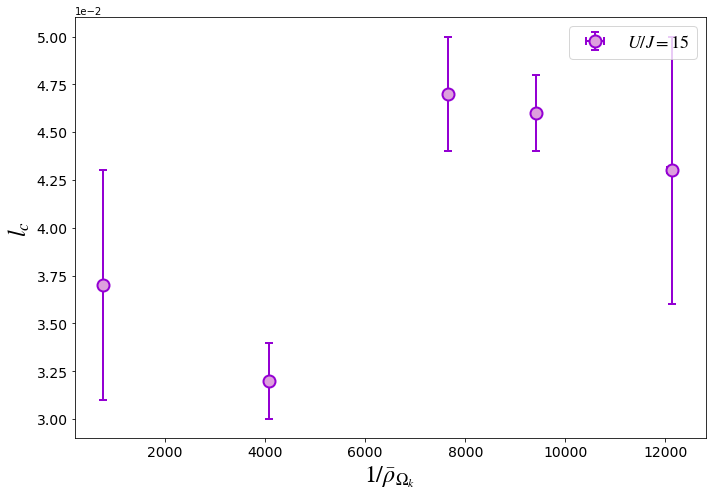

In [140]:
######### ls vs 1/rho_bar at U/J=15, 2.5k - 5k - 10k data sets #########

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(1/rho_bar_UJ_15_vs_N,lc_UJ_15_vs_N,yerr=err_lc_UJ_15_vs_N,xerr=err_rho_bar_UJ_15_vs_N/pow(rho_bar_UJ_15_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkviolet',
        markeredgecolor='darkviolet',
        markerfacecolor='plum',
        markeredgewidth=2.0,lw=2,
        label='$U/J=15$'
        )

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$1 / \bar{\rho}_{\Omega_k}$", fontsize = 24)
plt.ylabel(r"$l_c$", fontsize = 24)
plt.legend(loc='upper right',fontsize=18)
# plt.xlim(-1000,25000)
# plt.ylim(-0.5,4)

plt.tight_layout()


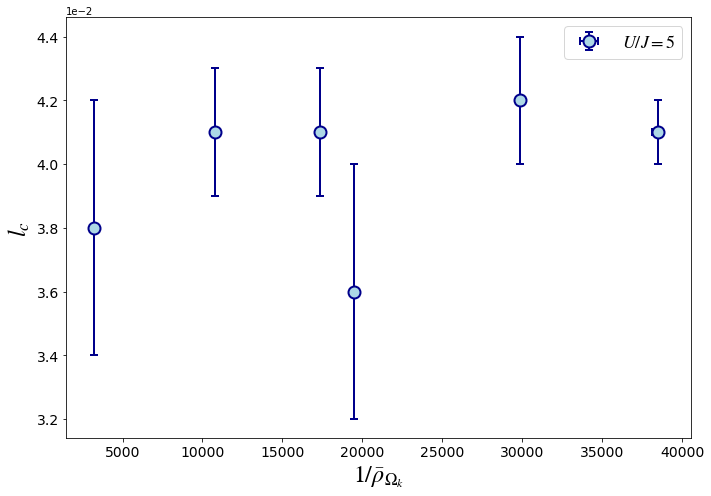

In [141]:
######### ls vs 1/rho_bar at U/J=5, 2.5k - 5k - 10k data sets #########

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(1/rho_bar_UJ_5_vs_N,lc_UJ_5_vs_N,yerr=err_lc_UJ_5_vs_N,xerr=err_rho_bar_UJ_5_vs_N/pow(rho_bar_UJ_5_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkblue',
        markeredgecolor='darkblue',
        markerfacecolor='lightblue',
        markeredgewidth=2.0,lw=2,
        label='$U/J=5$'
        )

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$1 / \bar{\rho}_{\Omega_k}$", fontsize = 24)
plt.ylabel(r"$l_c$", fontsize = 24)
plt.legend(loc='upper right',fontsize=18)
# plt.xlim(-1000,25000)
# plt.ylim(-0.5,4)

plt.tight_layout()


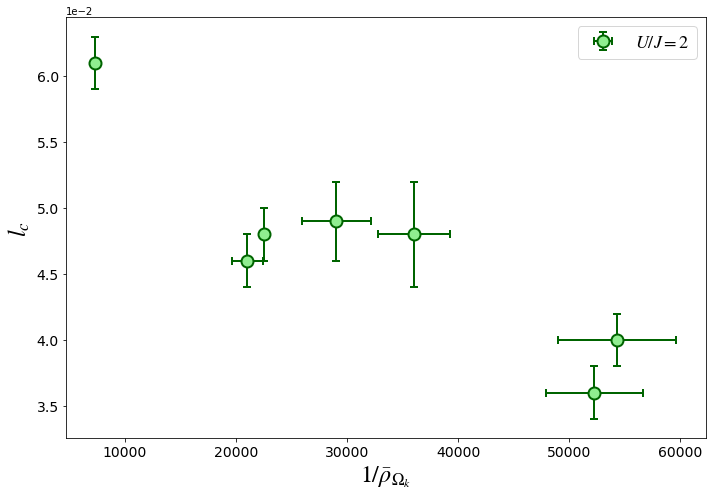

In [142]:
######### ls vs 1/rho_bar at U/J=2, 2.5k - 5k - 10k data sets #########

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(1/rho_bar_UJ_2_vs_N,lc_UJ_2_vs_N,yerr=err_lc_UJ_2_vs_N,xerr=err_rho_bar_UJ_2_vs_N/pow(rho_bar_UJ_2_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='lightgreen',
        markeredgewidth=2.0,lw=2,
        label='$U/J=2$'
        )

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$1 / \bar{\rho}_{\Omega_k}$", fontsize = 24)
plt.ylabel(r"$l_c$", fontsize = 24)
plt.legend(loc='upper right',fontsize=18)
# plt.xlim(-1000,25000)
# plt.ylim(-0.5,4)

plt.tight_layout()

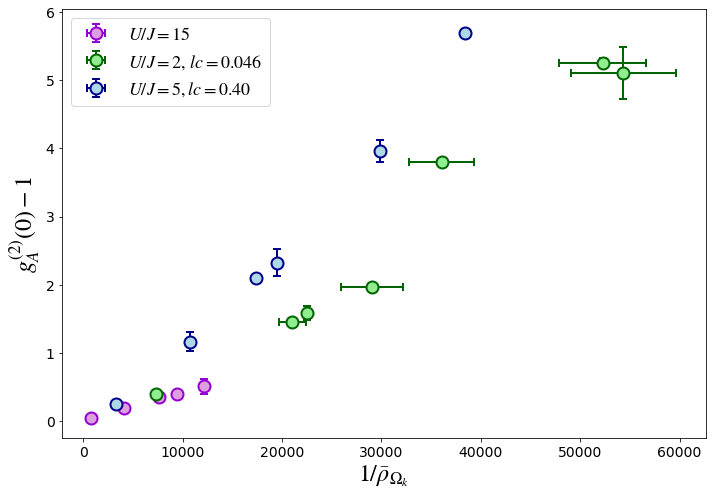

In [143]:
######### Compare amp_kmk vs 1/rho_bar between U/J=2 and U/J=5, 2.5k - 5k - 10k data sets #########

######### amp_kmk vs 1/rho_bar at U/J=15, 2.5k - 5k - 10k data sets #########

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(1/rho_bar_UJ_15_vs_N,amp_kmk_bare_UJ_15_vs_N,yerr=err_amp_kmk_bare_UJ_15_vs_N,xerr=err_rho_bar_UJ_15_vs_N/pow(rho_bar_UJ_15_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkviolet',
        markeredgecolor='darkviolet',
        markerfacecolor='plum',
        markeredgewidth=2.0,lw=2,
        label='$U/J=15$'
        )

plt.errorbar(1/rho_bar_UJ_2_vs_N,amp_kmk_bare_UJ_2_vs_N_46,yerr=err_amp_kmk_bare_UJ_2_vs_N_46,xerr=err_rho_bar_UJ_2_vs_N/pow(rho_bar_UJ_2_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='lightgreen',
        markeredgewidth=2.0,lw=2,
        label='$U/J=2, \, lc=0.046$'
        )

plt.errorbar(1/rho_bar_UJ_5_vs_N,amp_kmk_bare_UJ_5_vs_N_40,yerr=err_amp_kmk_bare_UJ_5_vs_N_40,xerr=err_rho_bar_UJ_5_vs_N/pow(rho_bar_UJ_5_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkblue',
        markeredgecolor='darkblue',
        markerfacecolor='lightblue',
        markeredgewidth=2.0,lw=2,
        label='$U/J=5, lc=0.40$'
        )

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$1 / \bar{\rho}_{\Omega_k}$", fontsize = 24)
plt.ylabel(r"$g^{(2)}_{A}(0) - 1$", fontsize = 24)
plt.legend(loc='upper left',fontsize=18)

plt.tight_layout()

Intercept = 0.006239 +/- 0.005704


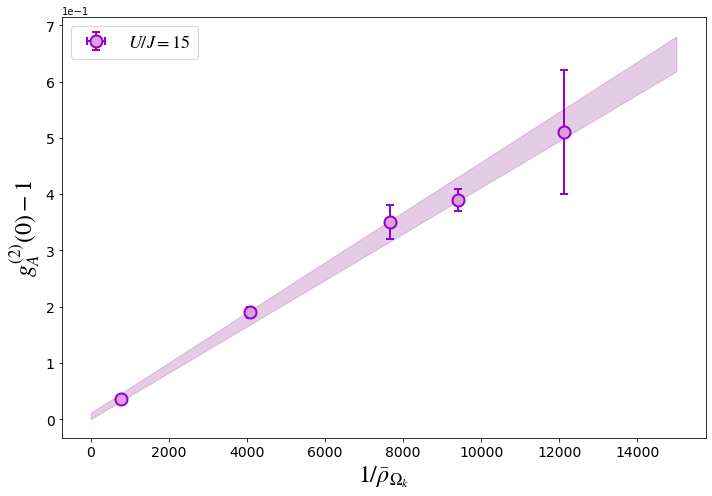

In [144]:
######### amp_kmk vs 1/rho_bar at U/J=15, 2.5k - 5k - 10k data sets #########

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(1/rho_bar_UJ_15_vs_N,amp_kmk_bare_UJ_15_vs_N,yerr=err_amp_kmk_bare_UJ_15_vs_N,xerr=err_rho_bar_UJ_15_vs_N/pow(rho_bar_UJ_15_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkviolet',
        markeredgecolor='darkviolet',
        markerfacecolor='plum',
        markeredgewidth=2.0,lw=2,
        label='$U/J=15$'
        )

####################### fit using both x and y error bars ########################

def linear_func(param, x):
   a, b = param
   return a*x + b

# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(1/rho_bar_UJ_15_vs_N, amp_kmk_bare_UJ_15_vs_N,sy=err_amp_kmk_bare_UJ_15_vs_N,sx=err_rho_bar_UJ_15_vs_N/pow(rho_bar_UJ_15_vs_N,2))

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Extract fit parameters
popt = out.beta
perr = out.sd_beta
print(f'Intercept = {popt[1]:.6f} +/- {perr[1]:.6f}')

# Plot extremal fits with nstd-sigma estimates
nstd=1
xfit = np.linspace(0,15000,100)
plt.fill_between(xfit, xfit*(popt[0]+nstd*perr[0]) + (popt[1]+nstd*perr[1]),
                 xfit*(popt[0]-nstd*perr[0]) + (popt[1]-nstd*perr[1]),
                 color='purple',alpha=0.2)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$1 / \bar{\rho}_{\Omega_k}$", fontsize = 24)
plt.ylabel(r"$g^{(2)}_{A}(0) - 1$", fontsize = 24)
plt.legend(loc='upper left',fontsize=18)

plt.tight_layout()

Intercept = -0.513 +/- 0.241


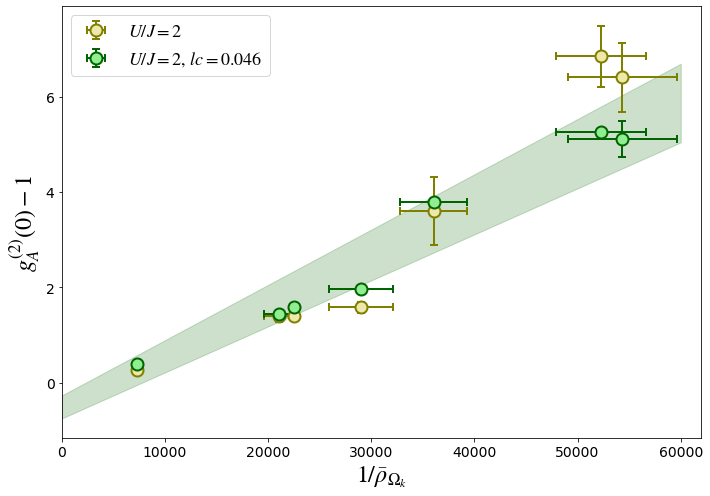

In [145]:
######### amp_kmk vs 1/rho_bar at U/J=2, 2.5k - 5k - 10k data sets #########

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(1/rho_bar_UJ_2_vs_N,amp_kmk_bare_UJ_2_vs_N,yerr=err_amp_kmk_bare_UJ_2_vs_N,xerr=err_rho_bar_UJ_2_vs_N/pow(rho_bar_UJ_2_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='olive',
        markeredgecolor='olive',
        markerfacecolor='palegoldenrod',
        markeredgewidth=2.0,lw=2,
        label='$U/J=2$'
        )

plt.errorbar(1/rho_bar_UJ_2_vs_N,amp_kmk_bare_UJ_2_vs_N_46,yerr=err_amp_kmk_bare_UJ_2_vs_N_46,xerr=err_rho_bar_UJ_2_vs_N/pow(rho_bar_UJ_2_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='lightgreen',
        markeredgewidth=2.0,lw=2,
        label='$U/J=2, \, lc=0.046$'
#         label='$U/J=2$'
        )

# plt.errorbar(1/rho_bar_UJ_2_vs_N,amp_kmk_bare_UJ_2_vs_N_50,yerr=err_amp_kmk_bare_UJ_2_vs_N_50,xerr=err_rho_bar_UJ_2_vs_N/pow(rho_bar_UJ_2_vs_N,2),
#         marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
#         linestyle='none',
#         color='teal',
#         markeredgecolor='teal',
#         markerfacecolor='lightcyan',
#         markeredgewidth=2.0,lw=2,
#         label='$U/J=2, \, lc=0.050$'
#         )

######################## fit using both x and y error bars ########################

def linear_func(param, x):
   a, b = param
   return a*x + b

# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(1/rho_bar_UJ_2_vs_N, amp_kmk_bare_UJ_2_vs_N_46,sy=err_amp_kmk_bare_UJ_2_vs_N_46)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Extract fit parameters
popt = out.beta
perr = out.sd_beta
print(f'Intercept = {popt[1]:.3f} +/- {perr[1]:.3f}')

# Plot extremal fits with nstd-sigma estimates
nstd=1
xfit = np.linspace(0,60000,100)
plt.fill_between(xfit, xfit*(popt[0]+nstd*perr[0]) + (popt[1]+nstd*perr[1]),
                 xfit*(popt[0]-nstd*perr[0]) + (popt[1]-nstd*perr[1]),
                 color='darkgreen',alpha=0.2)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

######################## Same for lc = 0.050 ########################

# def linear_func(param, x):
#    a, b = param
#    return a*x + b

# # Create a model for fitting.
# linear_model = Model(linear_func)

# # Create a RealData object using our initiated data from above.
# data = RealData(1/rho_bar_UJ_2_vs_N, amp_kmk_bare_UJ_2_vs_N_50,sy=err_amp_kmk_bare_UJ_2_vs_N_50)

# # Set up ODR with the model and data.
# odr = ODR(data, linear_model, beta0=[0., 1.])

# # Run the regression.
# out = odr.run()

# # Extract fit parameters
# popt = out.beta
# perr = out.sd_beta
# print(f'Intercept = {popt[1]:.3f} +/- {perr[1]:.3f}')

# # Plot extremal fits with nstd-sigma estimates
# nstd=1
# xfit = np.linspace(0,60000,100)
# plt.fill_between(xfit, xfit*(popt[0]+nstd*perr[0]) + (popt[1]+nstd*perr[1]),
#                  xfit*(popt[0]-nstd*perr[0]) + (popt[1]-nstd*perr[1]),
#                  color='teal',alpha=0.2)

# plt.tick_params(axis='x', labelsize=14)
# plt.tick_params(axis='y', labelsize=14)
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$1 / \bar{\rho}_{\Omega_k}$", fontsize = 24)
plt.ylabel(r"$g^{(2)}_{A}(0) - 1$", fontsize = 24)
plt.legend(loc='upper left',fontsize=18)
plt.xlim(0,62000)
plt.tight_layout()

Intercept = -0.353 +/- 0.130


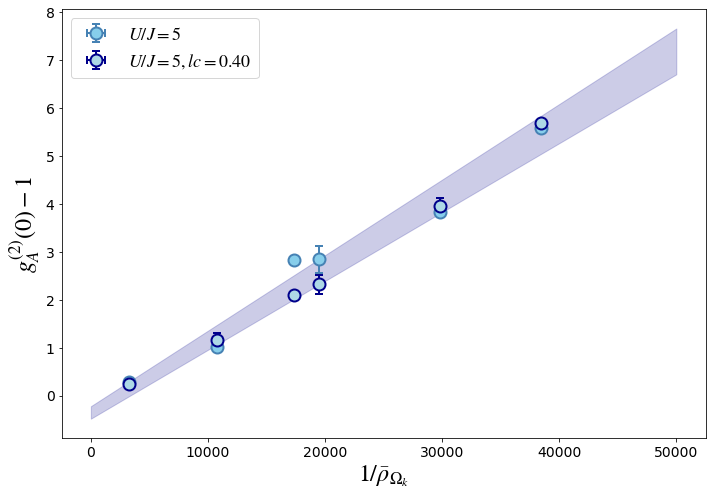

In [146]:
######### amp_kmk vs 1/rho_bar at U/J=5, 2.5k - 5k - 10k data sets #########

f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(1/rho_bar_UJ_5_vs_N,amp_kmk_bare_UJ_5_vs_N,yerr=err_amp_kmk_bare_UJ_5_vs_N,xerr=err_rho_bar_UJ_5_vs_N/pow(rho_bar_UJ_5_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='steelblue',
        markeredgecolor='steelblue',
        markerfacecolor='skyblue',
        markeredgewidth=2.0,lw=2,
        label='$U/J=5$'
        )

plt.errorbar(1/rho_bar_UJ_5_vs_N,amp_kmk_bare_UJ_5_vs_N_40,yerr=err_amp_kmk_bare_UJ_5_vs_N_40,xerr=err_rho_bar_UJ_5_vs_N/pow(rho_bar_UJ_5_vs_N,2),
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkblue',
        markeredgecolor='darkblue',
        markerfacecolor='lightblue',
        markeredgewidth=2.0,lw=2,
        label='$U/J=5, lc=0.40$'
#         label='$U/J=5$'
        )

######################## fit using both x and y error bars ########################

def linear_func(param, x):
   a, b = param
   return a*x + b

# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(1/rho_bar_UJ_5_vs_N, amp_kmk_bare_UJ_5_vs_N_40,sy=err_amp_kmk_bare_UJ_5_vs_N_40)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()

# Extract fit parameters
popt = out.beta
perr = out.sd_beta
print(f'Intercept = {popt[1]:.3f} +/- {perr[1]:.3f}')

# Plot extremal fits with nstd-sigma estimates
nstd=1
xfit = np.linspace(0,50000,100)
plt.fill_between(xfit, xfit*(popt[0]+nstd*perr[0]) + (popt[1]+nstd*perr[1]),
                 xfit*(popt[0]-nstd*perr[0]) + (popt[1]-nstd*perr[1]),
                 color='darkblue',alpha=0.2)

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$1 / \bar{\rho}_{\Omega_k}$", fontsize = 24)
plt.ylabel(r"$g^{(2)}_{A}(0) - 1$", fontsize = 24)
plt.legend(loc='upper left',fontsize=18)

plt.tight_layout()

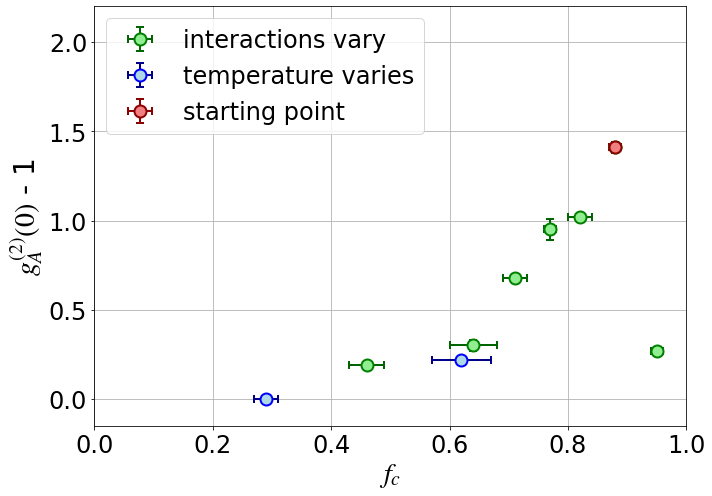

In [36]:
################### Plot amplitude k/-k vs fc(U/J) #########################


f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(fc_corr[1:8],amp_kmk_bare[0:7],yerr=err_amp_kmk_bare[0:7],xerr=err_fc_corr[1:8],           
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='green',
        markerfacecolor='lightgreen',
        markeredgewidth=2.0,lw=2,
        label='interactions vary')

################### Plot amplitude k/-k vs fc(T) #########################

plt.errorbar(fc_heated,amp_kmk_heated,yerr=err_amp_kmk_heated,xerr=err_fc_heated,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3, 
        linestyle='none',
        color='darkblue',
        markeredgecolor='blue',
        markerfacecolor='lightblue',
        markeredgewidth=2.0,lw=2,
        label='temperature varies')

plt.errorbar(fc_corr[2],amp_kmk_bare[1],yerr=err_amp_kmk_bare[1],xerr=err_fc_corr[2],
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3, 
        linestyle='none',
        color='darkred',
        markeredgecolor='darkred',
        markerfacecolor='lightcoral',
        markeredgewidth=2.0,lw=2,
        label='starting point')

plt.xlabel('$f_c$', fontsize = 28)
plt.ylabel('$g^{(2)}_{A}(0)$ - 1', fontsize = 28)

plt.grid()
plt.legend(fontsize=24,loc="upper left")
plt.xlim(0,1)
plt.ylim(-0.15,2.2)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.tight_layout()

## Condensed fraction vs U/J

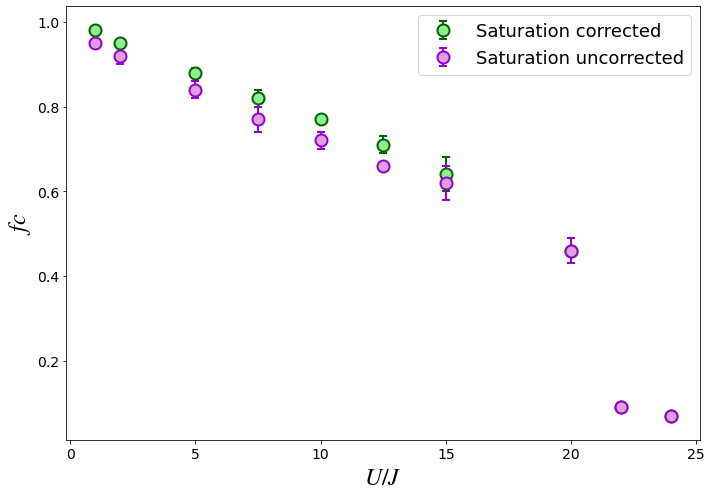

In [148]:
f, ax = plt.subplots(figsize=(10,7)) # set the size that you'd like (width, height)

plt.errorbar(U_J_fc,fc_corr,yerr=err_fc_corr,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkgreen',
        markeredgecolor='darkgreen',
        markerfacecolor='lightgreen',
        markeredgewidth=2.0,lw=2,
        label='Saturation corrected'
        )

plt.errorbar(U_J_fc,fc,yerr=err_fc,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkviolet',
        markeredgecolor='darkviolet',
        markerfacecolor='plum',
        markeredgewidth=2.0,lw=2,
        label='Saturation uncorrected'
        )


plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r"$U/J$", fontsize = 24)
plt.ylabel(r"$fc$", fontsize = 24)
plt.legend(loc='upper right',fontsize=18)
# plt.xlim(-1000,25000)
# plt.ylim(-0.5,4)

plt.tight_layout()

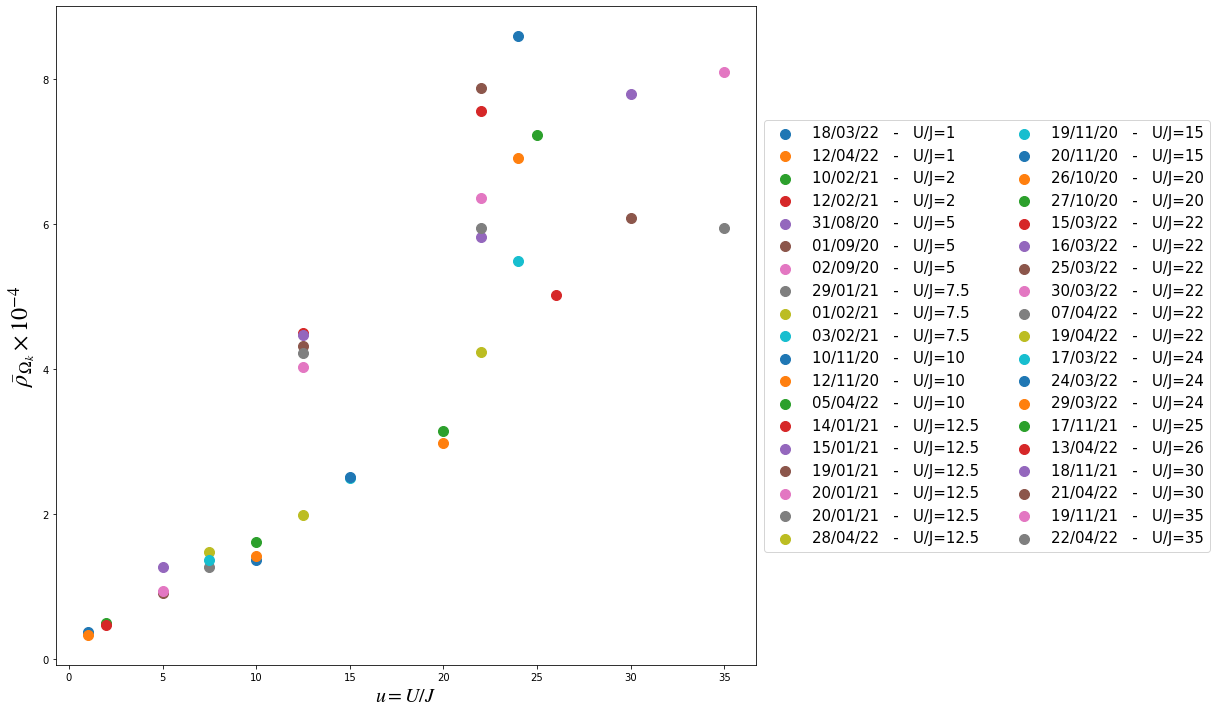

In [149]:
################### Rho_bar in the depletion [0.3 0.7]kd with pixelsize_long=0.008 kd #########################

# saturation slice of width 2*0.05 kd not takken into account here : Nb_modes = (kmax^3-kcut^3)/pixelsize_long^3

fig = plt.figure(figsize=(17, 10))
ax = fig.add_subplot(1,1,1)

marker_size = 100;

ax.scatter(1,0.3775, s=marker_size, label="18/03/22   -   U/J=1")
ax.scatter(1,0.3378, s=marker_size, label="12/04/22   -   U/J=1")
ax.scatter(2,0.5012, s=marker_size, label="10/02/21   -   U/J=2")
ax.scatter(2,0.4689, s=marker_size, label="12/02/21   -   U/J=2")
ax.scatter(5,1.267, s=marker_size, label="31/08/20   -   U/J=5")
ax.scatter(5,0.9165, s=marker_size, label="01/09/20   -   U/J=5")
ax.scatter(5,0.9390, s=marker_size, label="02/09/20   -   U/J=5")
ax.scatter(7.5,1.279, s=marker_size, label="29/01/21   -   U/J=7.5")
ax.scatter(7.5,1.485, s=marker_size, label="01/02/21   -   U/J=7.5")
ax.scatter(7.5,1.363, s=marker_size, label="03/02/21   -   U/J=7.5")
ax.scatter(10,1.367, s=marker_size, label="10/11/20   -   U/J=10")
ax.scatter(10,1.430, s=marker_size, label="12/11/20   -   U/J=10")
ax.scatter(10,1.624, s=marker_size, label="05/04/22   -   U/J=10")
ax.scatter(12.5,4.504, s=marker_size, label="14/01/21   -   U/J=12.5")
ax.scatter(12.5,4.476, s=marker_size, label="15/01/21   -   U/J=12.5")
ax.scatter(12.5,4.313, s=marker_size, label="19/01/21   -   U/J=12.5")
ax.scatter(12.5,4.036, s=marker_size, label="20/01/21   -   U/J=12.5")
ax.scatter(12.5,4.229, s=marker_size, label="20/01/21   -   U/J=12.5")
ax.scatter(12.5,1.995, s=marker_size, label="28/04/22   -   U/J=12.5")
ax.scatter(15,2.496, s=marker_size, label="19/11/20   -   U/J=15")
ax.scatter(15,2.508, s=marker_size, label="20/11/20   -   U/J=15")
ax.scatter(20,2.986, s=marker_size, label="26/10/20   -   U/J=20")
ax.scatter(20,3.144, s=marker_size, label="27/10/20   -   U/J=20")
ax.scatter(22,7.555, s=marker_size, label="15/03/22   -   U/J=22")
ax.scatter(22,5.822, s=marker_size, label="16/03/22   -   U/J=22")
ax.scatter(22,7.881, s=marker_size, label="25/03/22   -   U/J=22")
ax.scatter(22,6.358, s=marker_size, label="30/03/22   -   U/J=22")
ax.scatter(22,5.943, s=marker_size, label="07/04/22   -   U/J=22")
ax.scatter(22,4.239, s=marker_size, label="19/04/22   -   U/J=22")
ax.scatter(24,5.486, s=marker_size, label="17/03/22   -   U/J=24")
ax.scatter(24,8.588, s=marker_size, label="24/03/22   -   U/J=24")
ax.scatter(24,6.906, s=marker_size, label="29/03/22   -   U/J=24")
ax.scatter(25,7.233, s=marker_size, label="17/11/21   -   U/J=25")
ax.scatter(26,5.024, s=marker_size, label="13/04/22   -   U/J=26")
ax.scatter(30,7.787, s=marker_size, label="18/11/21   -   U/J=30")
ax.scatter(30,6.084, s=marker_size, label="21/04/22   -   U/J=30")
ax.scatter(35,8.092, s=marker_size, label="19/11/21   -   U/J=35")
ax.scatter(35,5.949, s=marker_size, label="22/04/22   -   U/J=35")


#plt.xlim(0,40)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15,ncol=2)
plt.xlabel('$u=U/J$', fontsize = 20)
plt.ylabel(r"$\bar{\rho}_{\Omega_k} \times 10^{-4}$", fontsize = 24)
plt.tight_layout()
plt.show()

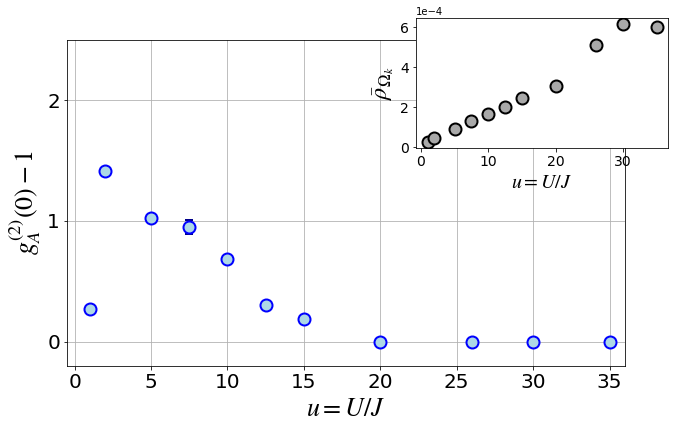

In [150]:
################### Bare amplitude k/-k vs U/J with rho_bar in inset #########################

f, ax = plt.subplots(figsize=(10,6)) # set the size that you'd like (width, height)

plt.errorbar(U_J,amp_kmk_bare,yerr=err_amp_kmk_bare,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkblue',
        markeredgecolor='blue',
        markerfacecolor='lightblue',
        markeredgewidth=2.0,lw=2,
        )

plt.grid()
plt.xlim(-0.5,36)
plt.ylim(-0.2,2.5)
ax.xaxis.set_ticks(np.arange(0, 36, 5))
ax.yaxis.set_ticks(np.arange(0, 3, 1))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.xlabel('$u=U/J$', fontsize = 26)
plt.ylabel(r"$g^{(2)}_{A}(0) - 1$", fontsize = 26)

################################## Inset ##################################

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.61, 0.63, 0.35, 0.3]
ax = f.add_axes([left, bottom, width, height])

plt.errorbar(U_J,rho_bar,yerr=err_rho_bar,
        marker='o',markersize=12,
        linestyle='none',
        color='black',
        markeredgecolor='black',
        markerfacecolor='darkgrey',
        markeredgewidth=2.0,lw=2,
        )

plt.xlabel('$u=U/J$', fontsize = 20)
plt.ylabel(r"$\bar{\rho}_{\Omega_k}$", fontsize = 24)
# plt.xlim(-0.5,22)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# plt.tight_layout()
plt.show()

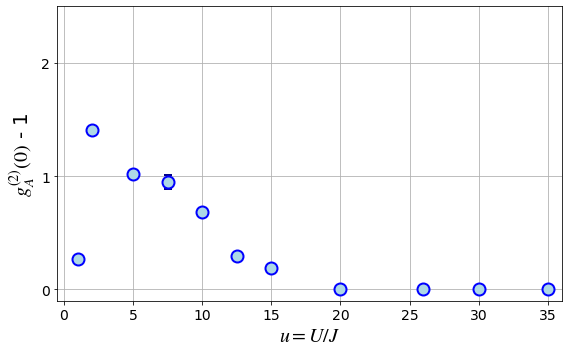

In [151]:
################### Plot amplitude k/-k vs U/J #########################

f, ax = plt.subplots(figsize=(8,5)) # set the size that you'd like (width, height)

plt.errorbar(U_J,amp_kmk_bare,yerr=err_amp_kmk_bare,
        marker='o',markersize=12,capsize=4.0,elinewidth=2,capthick=3,
        linestyle='none',
        color='darkblue',
        markeredgecolor='blue',
        markerfacecolor='lightblue',
        markeredgewidth=2.0,lw=2,
        )

plt.grid()
plt.xlim(-0.5,36)
plt.ylim(-0.1,2.5)
ax.xaxis.set_ticks(np.arange(0, 36, 5))
ax.yaxis.set_ticks(np.arange(0, 3, 1))
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.xlabel('$u=U/J$', fontsize = 20)
plt.ylabel('$g^{(2)}_{A}(0)$ - 1', fontsize = 20)

plt.tight_layout()
plt.show()

In [34]:
E2=5069093.656794-4984872.1739
E1=5069095.947973-4984872.1739
E0=5069125.564925-4984872.1739


print(E1-E2)
print(E0-E2)

2.291178999468684
31.90813099965453


In [ ]:
3e8*0.1e2